<a href="https://colab.research.google.com/github/stanislavfort/dissect-git-re-basin/blob/master/git_rebasin_Stan_ResNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Replicating the Git Re-Basin experiments by Stanislav Fort, starting from their codebase (ResNet on CIFAR-10)

I got excited about the Git Re-Basin paper (https://arxiv.org/abs/2209.04836) yesterday (Sep 14 2022) and since the claims seemed pretty strong I decided to replicate the key results. I started from the codebase the authors put on GitHub (https://github.com/samuela/git-re-basin), and took the relevant bits and pieces, put them into a Colab, and write a one-click-runnable replication.

**tldr: I wasn't able to replicate the key observation that the permutation applied to a network moves it to a linearly connected basin of another** 

I added a lot of analysis on top to make sure I knew what was going on. Some things that seem to be true that I wanted to verify: 

1) the permutation procedure preserves the network exactly as it was in terms of its input-ouput behavior, exactly as it should
2) the (network + permutation)'s weight vector gets non-randomly closer to the network towards which the permutation was developed, as it should

However, the key claim that after the permutation is applied the new network is now **within the same convex, linearly connected basin of the other network, I was not able to replicate**. This is unusual since I literally took bits of code from the author's codebase. If you find a problem with my replication, please let me know on Twitter (@stanislavfort) or via email.

Here's the money plot:
Explanation: I have two networks trained from init (model 1 and model 2), and the permutation from the paper applied to model 2 towards model 1. The model 2 + permutation should be in the same linearly connected basin as model 1, which would suggest a nice linear path of low loss between the aqua triangle and the red circle. However, as you can see, there is a bump! The yellow line isn't a nice connected bridge and  on top of that the loss on the weight space cut defined by the model 1, model 2 and model 2 + permutation shows clearly 3 different basins, not 2, as the key claim would suggest.
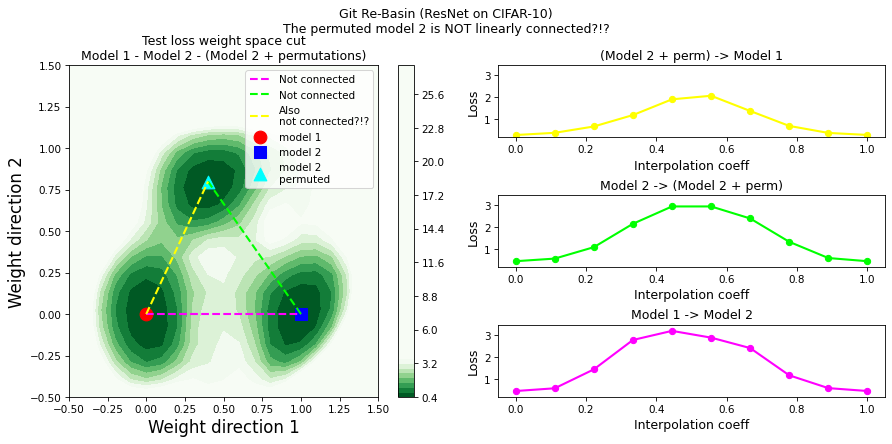


## Library imports

In [1]:
!pip install augmax
# Install the newest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.6 MB/s 
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 11.3 MB/s eta 0:00:00


## Permutation utils

In [2]:
from collections import defaultdict
from typing import NamedTuple

import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

# def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
#   """We assume that one permutation cannot appear in two axes of the same weight array."""
#   assert num_hidden_layers >= 1
#   return PermutationSpec(
#       perm_to_axes={
#           f"P_{i}": [(f"Dense_{i}/kernel", 1), (f"Dense_{i}/bias", 0), (f"Dense_{i+1}/kernel", 0)]
#           for i in range(num_hidden_layers)
#       },
#       axes_to_perm={
#           "Dense_0/kernel": (None, "P_0"),
#           **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
#              for i in range(1, num_hidden_layers)},
#           **{f"Dense_{i}/bias": (f"P_{i}", )
#              for i in range(num_hidden_layers)},
#           f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
#           f"Dense_{num_hidden_layers}/bias": (None, ),
#       })

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def vgg16_permutation_spec() -> PermutationSpec:
  return permutation_spec_from_axes_to_perm({
      "Conv_0/kernel": (None, None, None, "P_Conv_0"),
      **{f"Conv_{i}/kernel": (None, None, f"P_Conv_{i-1}", f"P_Conv_{i}")
         for i in range(1, 13)},
      **{f"Conv_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/scale": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      "Dense_0/kernel": ("P_Conv_12", "P_Dense_0"),
      "Dense_0/bias": ("P_Dense_0", ),
      "Dense_1/kernel": ("P_Dense_0", "P_Dense_1"),
      "Dense_1/bias": ("P_Dense_1", ),
      "Dense_2/kernel": ("P_Dense_1", None),
      "Dense_2/bias": (None, ),
  })

def resnet20_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}/kernel": (None, None, p_in, p_out)}
  norm = lambda name, p: {f"{name}/scale": (p, ), f"{name}/bias": (p, )}
  dense = lambda name, p_in, p_out: {f"{name}/kernel": (p_in, p_out), f"{name}/bias": (p_out, )}

  # This is for easy blocks that use a residual connection, without any change in the number of channels.
  easyblock = lambda name, p: {
      **conv(f"{name}/conv1", p, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p),
      **norm(f"{name}/norm2", p)
  }

  # This is for blocks that use a residual connection, but change the number of channels via a Conv.
  shortcutblock = lambda name, p_in, p_out: {
      **conv(f"{name}/conv1", p_in, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p_out),
      **norm(f"{name}/norm2", p_out),
      **conv(f"{name}/shortcut/layers_0", p_in, p_out),
      **norm(f"{name}/shortcut/layers_1", p_out),
  }

  return permutation_spec_from_axes_to_perm({
      **conv("conv1", None, "P_bg0"),
      **norm("norm1", "P_bg0"),
      #
      **easyblock("blockgroups_0/blocks_0", "P_bg0"),
      **easyblock("blockgroups_0/blocks_1", "P_bg0"),
      **easyblock("blockgroups_0/blocks_2", "P_bg0"),
      #
      **shortcutblock("blockgroups_1/blocks_0", "P_bg0", "P_bg1"),
      **easyblock("blockgroups_1/blocks_1", "P_bg1"),
      **easyblock("blockgroups_1/blocks_2", "P_bg1"),
      #
      **shortcutblock("blockgroups_2/blocks_0", "P_bg1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_2", "P_bg2"),
      #
      **dense("dense", "P_bg2", None),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm

def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)
  print(perm)



## Utils

In [3]:
import operator
import re
import time

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


## ResNet model and dataset

In [4]:
from einops import reduce
from flax import linen as nn

def reverse_compose(x, fs):
  for f in fs:
    x = f(x)
  return x

class Block(nn.Module):
  num_channels: int = None
  strides: int = None

  def setup(self):
    self.conv1 = nn.Conv(features=self.num_channels,
                         kernel_size=(3, 3),
                         strides=self.strides,
                         use_bias=False)
    self.norm1 = nn.LayerNorm()
    self.conv2 = nn.Conv(features=self.num_channels, kernel_size=(3, 3), strides=1, use_bias=False)
    self.norm2 = nn.LayerNorm()

    # When strides != 1, then it's 2, which means that we halve the width and height of the input, while doubling the
    # number of channels. Therefore we need to correspondingly halve the width and height of the residuals/shortcut.
    if self.strides != 1:
      assert self.strides == 2

      # Supposedly this is the original description, but it is not easily comaptible with our weight matching stuff
      # since it plays games with the channel structure by padding things around.
      # self.shortcut = lambda x: jnp.pad(x[:, ::2, ::2, :], (
      #     (0, 0), (0, 0), (0, 0), (self.num_channels // 4, self.num_channels // 4)),
      #                                   "constant",
      #                                   constant_values=0)

      # This is not the original, but is fairly common based on other implementations.
      self.shortcut = nn.Sequential([
          nn.Conv(features=self.num_channels,
                  kernel_size=(3, 3),
                  strides=self.strides,
                  use_bias=False),
          nn.LayerNorm()
      ])
    else:
      self.shortcut = lambda x: x

  def __call__(self, x):
    y = x
    y = self.conv1(y)
    y = self.norm1(y)
    y = nn.relu(y)
    y = self.conv2(y)
    y = self.norm2(y)
    return nn.relu(y + self.shortcut(x))

class BlockGroup(nn.Module):
  num_channels: int = None
  num_blocks: int = None
  strides: int = None

  def setup(self):
    assert self.num_blocks > 0
    self.blocks = (
        [Block(num_channels=self.num_channels, strides=self.strides)] +
        [Block(num_channels=self.num_channels, strides=1) for _ in range(self.num_blocks - 1)])

  def __call__(self, x):
    return reverse_compose(x, self.blocks)

class ResNet(nn.Module):
  blocks_per_group: int = None
  num_classes: int = None
  width_multiplier: int = 1

  def setup(self):
    wm = self.width_multiplier

    self.conv1 = nn.Conv(features=16 * wm, kernel_size=(3, 3), use_bias=False)
    self.norm1 = nn.LayerNorm()

    channels_per_group = (16 * wm, 32 * wm, 64 * wm)
    strides_per_group = (1, 2, 2)
    self.blockgroups = [
        BlockGroup(num_channels=c, num_blocks=b, strides=s)
        for c, b, s in zip(channels_per_group, self.blocks_per_group, strides_per_group)
    ]

    self.dense = nn.Dense(self.num_classes)

  def __call__(self, x):
    x = self.conv1(x)
    x = self.norm1(x)
    x = nn.relu(x)
    x = reverse_compose(x, self.blockgroups)
    x = reduce(x, "n h w c -> n c", "mean")
    x = self.dense(x)
    x = nn.log_softmax(x)
    return x

BLOCKS_PER_GROUP = {
    "resnet20": (3, 3, 3),
    "resnet32": (5, 5, 5),
    "resnet44": (7, 7, 7),
    "resnet56": (9, 9, 9),
    "resnet110": (18, 18, 18),
}

In [5]:
import numpy as np
import tensorflow_datasets as tfds

def load_cifar10():
  """Return the training and test datasets, as jnp.array's."""
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("cifar10", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("cifar10", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds

def load_cifar100():
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("cifar100", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("cifar100", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds

def _split_cifar(train_ds, label_split: int):
  """Split a CIFAR-ish dataset into two biased subsets."""
  assert train_ds["images_u8"].shape[0] == 50_000
  assert train_ds["labels"].shape[0] == 50_000

  # We randomly permute the training data, just in case there's some kind of
  # non-iid ordering coming out of tfds.
  perm = np.random.default_rng(123).permutation(50_000)
  train_images_u8 = train_ds["images_u8"][perm, :, :, :]
  train_labels = train_ds["labels"][perm]

  # This just so happens to be a clean 25000/25000 split.
  lt_images_u8 = train_images_u8[train_labels < label_split]
  lt_labels = train_labels[train_labels < label_split]
  gte_images_u8 = train_images_u8[train_labels >= label_split]
  gte_labels = train_labels[train_labels >= label_split]
  s1 = {
      "images_u8": np.concatenate((lt_images_u8[:5000], gte_images_u8[5000:]), axis=0),
      "labels": np.concatenate((lt_labels[:5000], gte_labels[5000:]), axis=0)
  }
  s2 = {
      "images_u8": np.concatenate((gte_images_u8[:5000], lt_images_u8[5000:]), axis=0),
      "labels": np.concatenate((gte_labels[:5000], lt_labels[5000:]), axis=0)
  }
  return s1, s2

def load_cifar10_split():
  train_ds, test_ds = load_cifar10()
  s1, s2 = _split_cifar(train_ds, label_split=5)
  return s1, s2, test_ds

def load_cifar100_split():
  train_ds, test_ds = load_cifar100()
  s1, s2 = _split_cifar(train_ds, label_split=50)
  return s1, s2, test_ds

In [6]:
import argparse

import augmax
import flax
import jax.nn
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
from flax.training.train_state import TrainState
from jax import jit, random, value_and_grad, vmap
from tqdm import tqdm


# See https://github.com/tensorflow/tensorflow/issues/53831.

# See https://github.com/google/jax/issues/9454.
tf.config.set_visible_devices([], "GPU")

NUM_CLASSES = 10

In [46]:
def make_stuff(model):
  train_transform = augmax.Chain(
      # augmax does not seem to support random crops with padding. See https://github.com/khdlr/augmax/issues/6.
      augmax.RandomSizedCrop(32, 32, zoom_range=(0.8, 1.2)),
      augmax.HorizontalFlip(),
      augmax.Rotate(),
  )
  # Applied to all input images, test and train.
  normalize_transform = augmax.Chain(augmax.ByteToFloat(), augmax.Normalize())

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    y_onehot = jax.nn.one_hot(labels, NUM_CLASSES)
    logits = model.apply({"params": params}, images_f32)
    l = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == labels)
    return l, {"num_correct": num_correct}

  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    y_onehot = jax.nn.one_hot(labels, NUM_CLASSES)
    logits = model.apply({"params": params}, images_f32)
    l = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == labels)
    return l, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(rng, train_state, images, labels):
    images_transformed = vmap(train_transform)(random.split(rng, images.shape[0]), images)
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_transformed,
                                                            labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
    )

  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits,onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        onehots,
    )

  return {
      "train_transform": train_transform,
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }

def init_train_state(rng, model, learning_rate, num_epochs, batch_size, num_train_examples,
                     weight_decay: float, config_optimizer = "sgd"):
  # See https://github.com/kuangliu/pytorch-cifar.
  warmup_epochs = 5
  steps_per_epoch = num_train_examples // batch_size
  lr_schedule = optax.warmup_cosine_decay_schedule(
      init_value=1e-6,
      peak_value=learning_rate,
      warmup_steps=warmup_epochs * steps_per_epoch,
      # Confusingly, `decay_steps` is actually the total number of steps,
      # including the warmup.
      decay_steps=num_epochs * steps_per_epoch,
  )
  if config_optimizer == "sgd":
    tx = optax.chain(optax.add_decayed_weights(weight_decay), optax.sgd(lr_schedule, momentum=0.9))
  elif config_optimizer == "adam":
    tx = optax.adamw(learning_rate=lr_schedule, weight_decay=5e-4)
  else:
    assert False
  vars = model.init(rng, jnp.zeros((1, 32, 32, 3)))
  return TrainState.create(apply_fn=model.apply, params=vars["params"], tx=tx)



## Runs details

In [8]:
num_epochs = 10 #100
batch_size = 500
seed = 324232323
config_optimizer = "sgd" #"adam"
learning_rate = 1e-1
weight_decay = 1e-4
width_multiplier = 1

runs_to_collect = 2 #Stan's new stuff

rng = random.PRNGKey(seed)

In [9]:
train_ds, test_ds = load_cifar10()

print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

num_train_examples = train_ds["images_u8"].shape[0]
num_test_examples = test_ds["images_u8"].shape[0]
assert num_train_examples % batch_size == 0
print("num_train_examples", num_train_examples)
print("num_test_examples", num_test_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete6KHM78/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete6KHM78/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
train_ds labels hash -7696492749535995776
test_ds labels hash -9123899674350535570
num_train_examples 50000
num_test_examples 10000


In [10]:
# storing model params after training
flattened_models_list = []

for run_i in range(runs_to_collect):

  rng = random.PRNGKey(seed+run_i)

  model = ResNet(blocks_per_group=BLOCKS_PER_GROUP["resnet20"],
                  num_classes=NUM_CLASSES,
                  width_multiplier=width_multiplier)

  stuff = make_stuff(model)

  print("--------------------------")
  print(f"Starting run {run_i}")


  train_state = init_train_state(rngmix(rng, f"init{run_i}"),
                                  model=model,
                                  learning_rate=learning_rate,
                                  num_epochs=num_epochs,
                                  batch_size=batch_size,
                                  num_train_examples=train_ds["images_u8"].shape[0],
                                  weight_decay=weight_decay)

  for epoch in tqdm(range(num_epochs)):
    infos = []

    batch_ix = random.permutation(rngmix(rng, f"{run_i}epoch-{epoch}"), num_train_examples).reshape(
        (-1, batch_size))
    batch_rngs = random.split(rngmix(rng, f"{run_i}batch_rngs-{epoch}"), batch_ix.shape[0])
    for i in range(batch_ix.shape[0]):
      p = batch_ix[i, :]
      images_u8 = train_ds["images_u8"][p, :, :, :]
      labels = train_ds["labels"][p]
      train_state, info = stuff["step"](batch_rngs[i], train_state, images_u8, labels)
      infos.append(info)

    train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
    train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples


    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                  1000)
    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                  1000)
    
    print(train_loss, train_accuracy, test_loss,test_accuracy)

  # summary
  print("-----------------")
  print(f"Run {run_i} DONE!")
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                10_000)
  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                50_000)
  print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

  flattened_models_list.append(flatten_params(train_state.params))


--------------------------
Starting run 0


 10%|█         | 1/10 [00:23<03:28, 23.14s/it]

2.0362277 0.23429999 2.0285912 0.23900001


 20%|██        | 2/10 [00:26<01:33, 11.66s/it]

1.8443979 0.32334 1.8366772 0.3285


 30%|███       | 3/10 [00:30<00:55,  7.99s/it]

1.699129 0.3782 1.6862327 0.3873


 40%|████      | 4/10 [00:34<00:37,  6.26s/it]

1.6417147 0.40298 1.6352676 0.40480003


 50%|█████     | 5/10 [00:37<00:26,  5.31s/it]

1.5814314 0.38742 1.5733503 0.3896


 60%|██████    | 6/10 [00:41<00:18,  4.74s/it]

1.5218246 0.43449998 1.5124433 0.42810002


 70%|███████   | 7/10 [00:44<00:13,  4.38s/it]

1.426236 0.46859998 1.4244757 0.46600002


 80%|████████  | 8/10 [00:48<00:08,  4.15s/it]

1.2253711 0.55072 1.2322227 0.5482


 90%|█████████ | 9/10 [00:52<00:04,  4.01s/it]

1.1544667 0.58063996 1.170294 0.5698


100%|██████████| 10/10 [00:55<00:00,  5.59s/it]

1.1302652 0.5905 1.1457876 0.58540004
-----------------
Run 0 DONE!


Run=0 test loss=1.1457875967025757 test accuracy=0.5854000449180603 train loss=1.130265235900879 train accuracy=0.590499997138977
--------------------------
Starting run 1


 10%|█         | 1/10 [00:10<01:36, 10.69s/it]

2.1429763 0.18642 2.1309001 0.18820001


 20%|██        | 2/10 [00:14<00:52,  6.54s/it]

1.8449359 0.31085998 1.8362013 0.3161


 30%|███       | 3/10 [00:17<00:36,  5.21s/it]

1.8655535 0.3214 1.8530755 0.32920003


 40%|████      | 4/10 [00:21<00:27,  4.58s/it]

1.6740203 0.3739 1.6720015 0.37870002


 50%|█████     | 5/10 [00:25<00:21,  4.24s/it]

1.6193823 0.4077 1.618432 0.4119


 60%|██████    | 6/10 [00:28<00:16,  4.03s/it]

1.5571221 0.43445998 1.5592134 0.43510002


 70%|███████   | 7/10 [00:32<00:11,  3.90s/it]

1.4128889 0.47368 1.4152595 0.4794


 80%|████████  | 8/10 [00:36<00:07,  3.83s/it]

1.2885699 0.52686 1.2914929 0.5212


 90%|█████████ | 9/10 [00:39<00:03,  3.77s/it]

1.1813545 0.5721 1.1844456 0.5712


100%|██████████| 10/10 [00:43<00:00,  4.34s/it]

1.167042 0.57676 1.1720484 0.57360005
-----------------
Run 1 DONE!


Run=1 test loss=1.1720483303070068 test accuracy=0.5736000537872314 train loss=1.1670420169830322 train accuracy=0.5767599940299988


In [11]:
# flattening params
assert len(flattened_models_list) >= 2
flattened_model1 = flattened_models_list[0]
flattened_model2 = flattened_models_list[1]

## Permuting the model

In [12]:
permutation_spec = resnet20_permutation_spec()
final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                    flattened_model1, flattened_model2)

0/P_blockgroups_1/blocks_1_inner: 4.689678192138672
0/P_blockgroups_0/blocks_1_inner: 3.394540786743164
0/P_bg1: 8.100028991699219
0/P_bg2: 28.760284423828125
0/P_blockgroups_2/blocks_0_inner: 8.401607513427734
0/P_blockgroups_1/blocks_0_inner: 4.950347900390625
0/P_blockgroups_1/blocks_2_inner: 3.010324478149414
0/P_blockgroups_2/blocks_1_inner: 7.469825744628906
0/P_blockgroups_0/blocks_0_inner: 3.890687942504883
0/P_bg0: 12.900650024414062
0/P_blockgroups_0/blocks_2_inner: 2.8368263244628906
0/P_blockgroups_2/blocks_2_inner: 6.534366607666016
1/P_blockgroups_0/blocks_0_inner: 3.2031078338623047
1/P_blockgroups_0/blocks_1_inner: 2.8832321166992188
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 1.9743804931640625
1/P_bg2: 0.08001708984375
1/P_bg1: 0.064697265625
1/P_blockgroups_1/blocks_2_inner: 0.5426139831542969
1/P_blockgroups_2/blocks_0_inner: 0.36298370361328125
1/P_bg0: 0.0
1/P_blockgroups_0/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_0_inner: 2.3127403

In [13]:
# applying the permutation to the second model
flattened_model1_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model1)
        )
flattened_model2_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model2)
        )

## Performance verification

### Model 1

In [14]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                  50_000)
print("Model 1")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1
train_loss=1.130265235900879 train_accuracy=0.590499997138977
test_loss=1.1457875967025757 test_accuracy=0.5854000449180603


### Model 2

In [15]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                  50_000)
print("Model 2")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2
train_loss=1.1670420169830322 train_accuracy=0.5767599940299988
test_loss=1.1720483303070068 test_accuracy=0.5736000537872314


### Model 1 with permutation

In [16]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), train_ds,
                                                                  50_000)
print("Model 1 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1 with permutation
train_loss=1.1302649974822998 train_accuracy=0.590499997138977
test_loss=1.1457875967025757 test_accuracy=0.5854000449180603


### Model 2 with permutation

In [17]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                  50_000)
print("Model 2 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2 with permutation
train_loss=1.1670420169830322 train_accuracy=0.5767599940299988
test_loss=1.1720483303070068 test_accuracy=0.5736000537872314


## Weight vector analysis

In [18]:
flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)

In [19]:
# all in long vectors
keys = flattened_model1.keys()

v1 = jnp.concatenate([flattened_model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([flattened_model2[key].reshape([-1]) for key in keys],axis=0)
v1_perm = jnp.concatenate([flattened_model1_permuted_flat[key].reshape([-1]) for key in keys],axis=0)
v2_perm = jnp.concatenate([flattened_model2_permuted_flat[key].reshape([-1]) for key in keys],axis=0)

In [20]:
vectors_to_show = [
    ("model 1", v1),
    ("model 2", v2),
    ("model 1 + perms", v1_perm),
    ("model 2 + perms", v2_perm), 
]

for vector_str, vector in vectors_to_show:
  print(f"{vector_str} length**2={(jnp.sum(vector**2))}")

# the permutation should preserve the length

model 1 length**2=1634.61181640625
model 2 length**2=1621.1680908203125
model 1 + perms length**2=1634.61181640625
model 2 + perms length**2=1621.1680908203125


In [21]:
coses_grid = np.zeros((len(vectors_to_show),len(vectors_to_show)))
for i,(vector_str1, vector1) in enumerate(vectors_to_show):
  for j,(vector_str2, vector2) in enumerate(vectors_to_show):
    cos_now = jnp.sum(vector1*vector2)/jnp.sqrt(jnp.sum(vector1**2))/jnp.sqrt(jnp.sum(vector2**2))
    print(f"cos({vector_str1},{vector_str2})={cos_now}")
    coses_grid[i,j] = cos_now

cos(model 1,model 1)=1.0
cos(model 1,model 2)=0.43203017115592957
cos(model 1,model 1 + perms)=0.43769073486328125
cos(model 1,model 2 + perms)=0.4985879361629486
cos(model 2,model 1)=0.43203017115592957
cos(model 2,model 2)=0.9999998807907104
cos(model 2,model 1 + perms)=0.42946547269821167
cos(model 2,model 2 + perms)=0.4439848065376282
cos(model 1 + perms,model 1)=0.43769073486328125
cos(model 1 + perms,model 2)=0.42946547269821167
cos(model 1 + perms,model 1 + perms)=1.0
cos(model 1 + perms,model 2 + perms)=0.4320301115512848
cos(model 2 + perms,model 1)=0.4985879063606262
cos(model 2 + perms,model 2)=0.4439848065376282
cos(model 2 + perms,model 1 + perms)=0.4320301115512848
cos(model 2 + perms,model 2 + perms)=0.9999998807907104


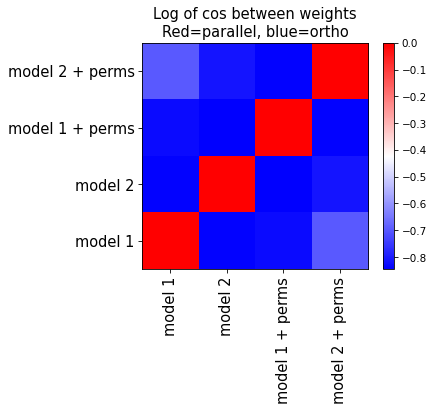

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,4),dpi=75)
fig.patch.set_facecolor('white')
plt.title("Log of cos between weights\nRed=parallel, blue=ortho",fontsize=14)
plt.imshow(np.log(np.abs(coses_grid)),cmap=plt.cm.bwr,origin="lower")
plt.xticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],rotation = 90,fontsize=14)
plt.yticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],fontsize=14)
plt.colorbar()
plt.show()


## Linear interpolations of weights = test for linear mode connectivity

In [23]:
def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )

### Model 1 -> Model 2

0 0.0 1.1457876
1 0.1111111111111111 1.2026373
2 0.2222222222222222 1.4842701
3 0.3333333333333333 2.1219745
4 0.4444444444444444 2.5252373
5 0.5555555555555556 2.2770793
6 0.6666666666666666 1.6832173
7 0.7777777777777777 1.3364491
8 0.8888888888888888 1.1969978
9 1.0 1.1720483


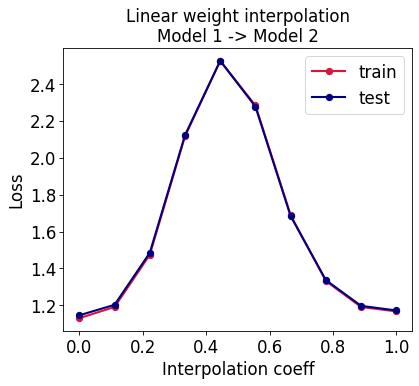

In [24]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2
name = "Model 1 -> Model 2"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 1.1457876
1 0.1111111111111111 1.1836898
2 0.2222222222222222 1.3302976
3 0.3333333333333333 1.6495097
4 0.4444444444444444 1.8748549
5 0.5555555555555556 1.6779089
6 0.6666666666666666 1.4385532
7 0.7777777777777777 1.2765499
8 0.8888888888888888 1.1992934
9 1.0 1.1720483


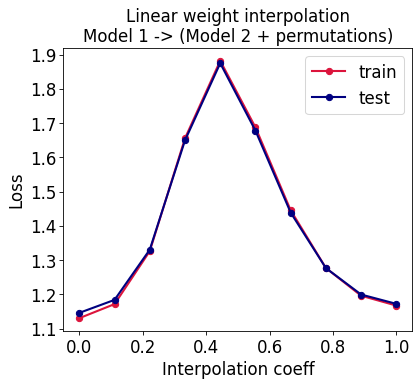

In [25]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2_permuted_flat
name = "Model 1 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 2 + permutations

0 0.0 1.1720483
1 0.1111111111111111 1.1932439
2 0.2222222222222222 1.425405
3 0.3333333333333333 2.391072
4 0.4444444444444444 3.9461493
5 0.5555555555555556 3.6262455
6 0.6666666666666666 2.6275628
7 0.7777777777777777 1.6468679
8 0.8888888888888888 1.237172
9 1.0 1.1720483


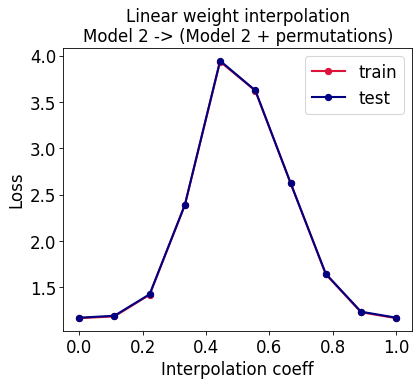

In [26]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model2_permuted_flat
name = "Model 2 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 1 + permutations

0 0.0 1.1720483
1 0.1111111111111111 1.1969173
2 0.2222222222222222 1.3197812
3 0.3333333333333333 1.6465974
4 0.4444444444444444 2.1899579
5 0.5555555555555556 2.4055977
6 0.6666666666666666 2.068039
7 0.7777777777777777 1.4291518
8 0.8888888888888888 1.1918606
9 1.0 1.1457876


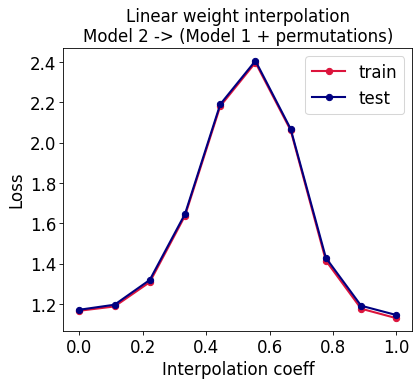

In [27]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model1_permuted_flat
name = "Model 2 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 1.1457876
1 0.1111111111111111 1.1657263
2 0.2222222222222222 1.3240827
3 0.3333333333333333 1.7702688
4 0.4444444444444444 2.4738555
5 0.5555555555555556 2.5224288
6 0.6666666666666666 1.8644776
7 0.7777777777777777 1.3447342
8 0.8888888888888888 1.1802837
9 1.0 1.1457876


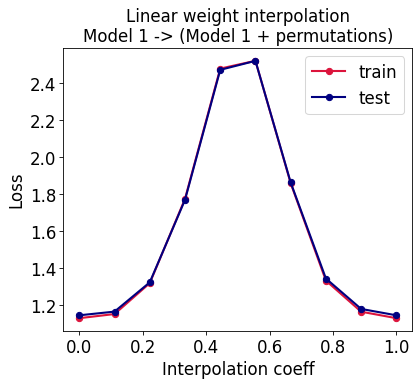

In [28]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model1_permuted_flat
name = "Model 1 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  50_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Predictions

In [29]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)
  
  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))
  


In [30]:
models_to_show = [
    ("model 1", flattened_model1),
    ("model 2", flattened_model2),
    ("model 1 + perms", flattened_model1_permuted_flat),
    ("model 2 + perms", flattened_model2_permuted_flat), 
]

disagreement_grid = np.zeros((len(models_to_show),len(models_to_show)))
for i,(vector_str1, vector1) in enumerate(models_to_show):
  for j,(vector_str2, vector2) in enumerate(models_to_show):
    disagreement_now = compare_predictions(
        unflatten_params(vector1),
        unflatten_params(vector2)
        )
    print(f"Disagreemnt {vector_str1} vs {vector_str2}={disagreement_now}")
    disagreement_grid[i,j] = disagreement_now

Disagreemnt model 1 vs model 1=0
Disagreemnt model 1 vs model 2=2665
Disagreemnt model 1 vs model 1 + perms=0
Disagreemnt model 1 vs model 2 + perms=2665
Disagreemnt model 2 vs model 1=2665
Disagreemnt model 2 vs model 2=0
Disagreemnt model 2 vs model 1 + perms=2665
Disagreemnt model 2 vs model 2 + perms=0
Disagreemnt model 1 + perms vs model 1=0
Disagreemnt model 1 + perms vs model 2=2665
Disagreemnt model 1 + perms vs model 1 + perms=0
Disagreemnt model 1 + perms vs model 2 + perms=2665
Disagreemnt model 2 + perms vs model 1=2665
Disagreemnt model 2 + perms vs model 2=0
Disagreemnt model 2 + perms vs model 1 + perms=2665
Disagreemnt model 2 + perms vs model 2 + perms=0


## Loss landscape cuts

In [31]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



In [32]:
# testing it, should get all 0.0
rec = reconstruct(v1, flattened_model1, flattened_model1.keys())
for key in rec.keys():
  print(jnp.max(jnp.abs(flattened_model1[key] - rec[key])))
  assert jnp.max(jnp.abs(flattened_model1[key] - rec[key])) == 0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


### Cut model1 - model2 - (model2+perm)

In [33]:
model1 = flattened_model1
model2 = flattened_model2
model3 = flattened_model2_permuted_flat
cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model1.keys()

v1 = jnp.concatenate([model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([model2[key].reshape([-1]) for key in keys],axis=0)
v3 = jnp.concatenate([model3[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / jnp.sqrt(jnp.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - jnp.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / jnp.sqrt(jnp.sum(basis2**2.0))

scale = jnp.sqrt(jnp.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

acc_grid = np.zeros((len(t1s),len(t2s)))
loss_grid = np.zeros((len(t1s),len(t2s)))
logits_grid = np.zeros((len(t1s),len(t2s), 10000, 10))

for i1,t1 in enumerate(t1s):
  print(f"{i1}/{len(t1s)}")
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model1, keys)
    actest_loss, test_accuracy, logits, onehots = stuff["dataset_predictions"](unflatten_params(reconstructed_flat), test_ds,
                                                                  10_000)
    logits_grid[i1,i2] = np.array(logits[0])
    
    acc_grid[i1,i2] = test_accuracy
    loss_grid[i1,i2] = actest_loss
  
def projection(vector):
  x = jnp.sum((vector - v1)*basis1_normed)/scale
  y = jnp.sum((vector - v1)*basis2_normed)/scale
  return x,y



0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21


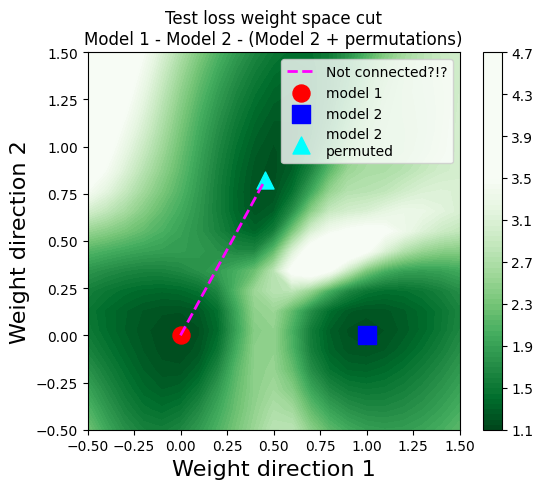

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6,5),dpi=100)
fig.patch.set_facecolor('white')
plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=3.5,levels=70)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="fuchsia",label="Not connected?!?")

plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)


plt.legend(fontsize=10,ncol=1)

plt.show()

## Combined plot

In [35]:
def get_linear_cut(start_vector, stop_vector, steps=10):

  ts = np.linspace(0.0,1.0,steps)

  test_losses_list = []
  test_accs_list = []
  train_losses_list = []
  train_accs_list = []

  for i,t in enumerate(ts):
    new_params = get_linear_combination(
        (1.0-t), start_vector, t, stop_vector
    )
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                    10_000)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_accuracy)

    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                    50_000)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_accuracy)

  return ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list


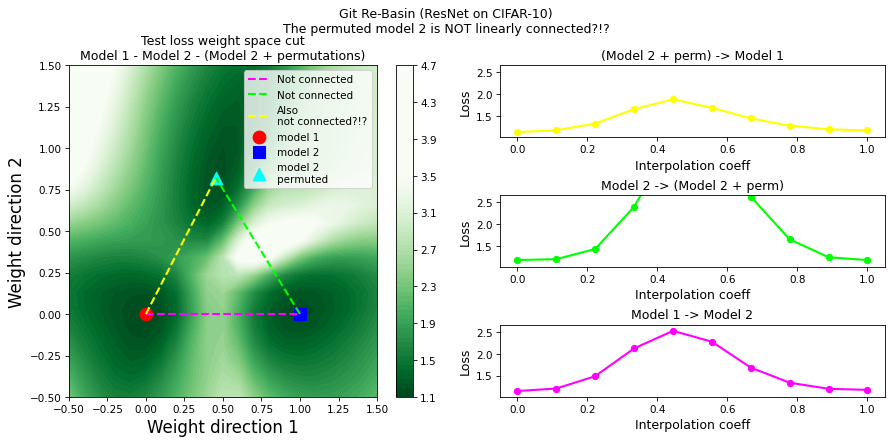

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi = 75)
fig.patch.set_facecolor('white')

plt.suptitle("Git Re-Basin (ResNet on CIFAR-10)\nThe permuted model 2 is NOT linearly connected?!?")

plt.subplot(1,2,1)

plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=3.5,levels=70)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2],[y1,y2],linewidth=2,linestyle="--",color="fuchsia",label="Not connected")
plt.plot([x2,x2p],[y2,y2p],linewidth=2,linestyle="--",color="lime",label="Not connected")
plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="yellow",label="Also\nnot connected?!?")


plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)

plt.legend(fontsize=10,ncol=1)

# getting the data
all_test_losses = []
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
all_test_losses += test_losses_list

lower_lim = np.min(test_losses_list)-(np.max(test_losses_list)-np.min(test_losses_list))*0.1
upper_lim = np.max(test_losses_list)+(np.max(test_losses_list)-np.min(test_losses_list))*0.1


plt.subplot(3,2,2)

ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)

plt.title(f"(Model 2 + perm) -> Model 1",fontsize=12)
plt.plot(ts,train_losses_list,label="train",marker="o",color="yellow",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])


plt.subplot(3,2,4)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
plt.title(f"Model 2 -> (Model 2 + perm)",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="lime",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])

plt.subplot(3,2,6)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
plt.title(f"Model 1 -> Model 2",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="fuchsia",linewidth=2)
plt.ylim([np.min(test_losses_list),np.max(test_losses_list)])
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)

plt.ylim([lower_lim, upper_lim])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Automating the full experiment to sweep over optimizers & LRs

## Wrappers

In [42]:
def get_optima(
  num_epochs = 20,
  batch_size = 500,
  seed = 12421,
  config_optimizer = "sgd", #"adam"
  learning_rate = 1e-3,
  runs_to_collect = 2,
):


  rng = random.PRNGKey(seed)


  # storing model params after training
  flattened_models_list = []

  for run_i in range(runs_to_collect):

    rng = random.PRNGKey(seed+run_i)
    rngmix = lambda rng, x: random.fold_in(rng, hash(x))

    model = ResNet(blocks_per_group=BLOCKS_PER_GROUP["resnet20"],
                    num_classes=NUM_CLASSES,
                    width_multiplier=width_multiplier)

    stuff = make_stuff(model)

    print("--------------------------")
    print(f"Starting run {run_i}")


    train_state = init_train_state(rngmix(rng, f"init{run_i}"),
                                    model=model,
                                    learning_rate=learning_rate,
                                    num_epochs=num_epochs,
                                    batch_size=batch_size,
                                    num_train_examples=train_ds["images_u8"].shape[0],
                                    weight_decay=weight_decay,
                                    config_optimizer=config_optimizer)

    for epoch in tqdm(range(num_epochs)):
      infos = []

      batch_ix = random.permutation(rngmix(rng, f"{run_i}epoch-{epoch}"), num_train_examples).reshape(
          (-1, batch_size))
      batch_rngs = random.split(rngmix(rng, f"{run_i}batch_rngs-{epoch}"), batch_ix.shape[0])
      for i in range(batch_ix.shape[0]):
        p = batch_ix[i, :]
        images_u8 = train_ds["images_u8"][p, :, :, :]
        labels = train_ds["labels"][p]
        train_state, info = stuff["step"](batch_rngs[i], train_state, images_u8, labels)
        infos.append(info)

      train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
      train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples


      test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                    1000)
      train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                    1000)
      
      print(train_loss, train_accuracy, test_loss,test_accuracy)

    # summary
    print("-----------------")
    print(f"Run {run_i} DONE!")
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                  10_000)
    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                  50_000)
    print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

    flattened_models_list.append(flatten_params(train_state.params))

  return flattened_models_list


In [43]:
def analyze_optima(
  flattened_model1,
  flattened_model2    
):

  permutation_spec = resnet20_permutation_spec()
  final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                      flattened_model1, flattened_model2)

  # applying the permutation to the second model
  flattened_model1_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model1)
          )
  flattened_model2_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model2)
          )
  
  flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
  flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)


  model1_test_loss, model1_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                    10_000)
  model1_train_loss, model1_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                    50_000)


  model2_test_loss, model2_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                    10_000)
  model2_train_loss, model2_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                    50_000)


  model2_permuted_test_loss, model2_permuted_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                    10_000)
  model2_permuted_train_loss, model2_permuted_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                    50_000)
  
  # get values in the middle
  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 3)
  bump_1_to_2 = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 3)
  bump_1_to_2perm = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 3)
  bump_2_to_2perm = test_losses_list[1]

  return {
    "model1_test_loss": model1_test_loss,
    "model2_test_loss": model2_test_loss,
    "model2_permuted_test_loss": model2_permuted_test_loss,
    "bump_1_to_2": bump_1_to_2,
    "bump_1_to_2perm": bump_1_to_2perm,
    "bump_2_to_2perm": bump_2_to_2perm,
  }


## SGD experiments sweep

In [61]:
reps = 1
LRs = np.exp(np.linspace(np.log(1e-4),np.log(0.1),6))
optimizers = ["sgd"]
epochs = 50

In [62]:
all_flattened_models_tuples = [] # collecting all solutions every
stored_results_dict = []

for rep in range(reps): # to get error bars
  for i_opt, optimizer in enumerate(optimizers):
    for i_LR, LR in enumerate(LRs):

      print("*****************************************")
      print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")

      flattened_models_list = get_optima(
          num_epochs = epochs,
          config_optimizer = optimizer,
          learning_rate = LR,
          seed = int(np.random.rand()*100000000),
          )
      
      flattened_model1 = flattened_models_list[0]
      flattened_model2 = flattened_models_list[1]
      results_dict = analyze_optima(flattened_model1,flattened_model2)

      results_dict["LR"] = LR
      results_dict["optimizer"] = optimizer
      results_dict["epochs"] = epochs
      
      stored_results_dict.append(results_dict)
      all_flattened_models_tuples.append(flattened_models_list)

      print(results_dict)

*****************************************
Experiment 0 / 6
--------------------------
Starting run 0


  2%|▏         | 1/50 [00:12<10:13, 12.52s/it]

2.4342933 0.11236 2.4360878 0.1106


  4%|▍         | 2/50 [00:16<05:50,  7.30s/it]

2.2844546 0.11904 2.2855859 0.116100006


  6%|▌         | 3/50 [00:19<04:24,  5.63s/it]

2.259778 0.15361999 2.2602012 0.1508


  8%|▊         | 4/50 [00:23<03:42,  4.84s/it]

2.2304666 0.17592 2.2299986 0.1694


 10%|█         | 5/50 [00:27<03:17,  4.40s/it]

2.19289 0.19974 2.1911936 0.1929


 12%|█▏        | 6/50 [00:30<03:02,  4.15s/it]

2.1485255 0.21772 2.146284 0.21570002


 14%|█▍        | 7/50 [00:34<02:51,  3.98s/it]

2.104533 0.23546 2.1027753 0.23590001


 16%|█▌        | 8/50 [00:38<02:42,  3.88s/it]

2.0644317 0.25378 2.0627618 0.2506


 18%|█▊        | 9/50 [00:41<02:35,  3.80s/it]

2.0296757 0.26824 2.0282214 0.2657


 20%|██        | 10/50 [00:45<02:30,  3.76s/it]

2.000071 0.28059998 1.9976997 0.2804


 22%|██▏       | 11/50 [00:48<02:25,  3.72s/it]

1.9763268 0.29158 1.9738212 0.296


 24%|██▍       | 12/50 [00:52<02:20,  3.70s/it]

1.9539291 0.2993 1.9499627 0.3032


 26%|██▌       | 13/50 [00:56<02:16,  3.69s/it]

1.931975 0.31285998 1.92782 0.31570002


 28%|██▊       | 14/50 [00:59<02:12,  3.68s/it]

1.9111452 0.31623998 1.9066085 0.3217


 30%|███       | 15/50 [01:03<02:08,  3.66s/it]

1.8927159 0.32573998 1.8871565 0.3298


 32%|███▏      | 16/50 [01:07<02:04,  3.65s/it]

1.8808516 0.32848 1.8765023 0.32930002


 34%|███▍      | 17/50 [01:10<02:00,  3.64s/it]

1.855755 0.33244 1.8508654 0.33400002


 36%|███▌      | 18/50 [01:14<01:56,  3.64s/it]

1.8437651 0.33523998 1.8392687 0.33690003


 38%|███▊      | 19/50 [01:18<01:52,  3.64s/it]

1.8284317 0.33986 1.8244481 0.34320003


 40%|████      | 20/50 [01:21<01:49,  3.64s/it]

1.8114718 0.34666 1.8072401 0.35130003


 42%|████▏     | 21/50 [01:25<01:45,  3.63s/it]

1.796607 0.35142 1.7920573 0.35340002


 44%|████▍     | 22/50 [01:28<01:41,  3.63s/it]

1.7914524 0.35002 1.7877505 0.35250002


 46%|████▌     | 23/50 [01:32<01:38,  3.64s/it]

1.7774808 0.35641998 1.7732263 0.35900003


 48%|████▊     | 24/50 [01:36<01:34,  3.64s/it]

1.7891803 0.34943998 1.7853073 0.3544


 50%|█████     | 25/50 [01:39<01:31,  3.64s/it]

1.764358 0.35792 1.7601143 0.36310002


 52%|█████▏    | 26/50 [01:43<01:27,  3.63s/it]

1.761978 0.35847998 1.7582788 0.3634


 54%|█████▍    | 27/50 [01:47<01:23,  3.63s/it]

1.7589527 0.36196 1.7547804 0.36670002


 56%|█████▌    | 28/50 [01:50<01:19,  3.63s/it]

1.7475681 0.36482 1.7432214 0.3673


 58%|█████▊    | 29/50 [01:54<01:16,  3.64s/it]

1.7424899 0.36694 1.7383825 0.372


 60%|██████    | 30/50 [01:58<01:12,  3.64s/it]

1.7391096 0.36815998 1.7348399 0.3738


 62%|██████▏   | 31/50 [02:01<01:09,  3.63s/it]

1.7353225 0.3699 1.7311077 0.37300003


 64%|██████▍   | 32/50 [02:05<01:05,  3.63s/it]

1.7357867 0.37017998 1.7315755 0.37320003


 66%|██████▌   | 33/50 [02:08<01:01,  3.63s/it]

1.7369268 0.37002 1.7330251 0.37070003


 68%|██████▊   | 34/50 [02:12<00:58,  3.63s/it]

1.726999 0.3728 1.7228415 0.37690002


 70%|███████   | 35/50 [02:16<00:54,  3.63s/it]

1.7261261 0.37322 1.7220684 0.3763


 72%|███████▏  | 36/50 [02:19<00:50,  3.62s/it]

1.725914 0.37245998 1.7219464 0.37660003


 74%|███████▍  | 37/50 [02:23<00:47,  3.63s/it]

1.7295054 0.3721 1.7256907 0.3747


 76%|███████▌  | 38/50 [02:27<00:43,  3.64s/it]

1.7279584 0.37342 1.7240634 0.3763


 78%|███████▊  | 39/50 [02:30<00:39,  3.63s/it]

1.729104 0.37311998 1.7250835 0.3758


 80%|████████  | 40/50 [02:34<00:36,  3.63s/it]

1.7206488 0.3753 1.7166765 0.37860003


 82%|████████▏ | 41/50 [02:37<00:32,  3.63s/it]

1.7178718 0.37618 1.7137792 0.37870002


 84%|████████▍ | 42/50 [02:41<00:29,  3.65s/it]

1.7197517 0.37592 1.7158319 0.37840003


 86%|████████▌ | 43/50 [02:45<00:25,  3.64s/it]

1.7175359 0.37726 1.71351 0.3797


 88%|████████▊ | 44/50 [02:48<00:21,  3.63s/it]

1.7156154 0.37763998 1.7116156 0.3799


 90%|█████████ | 45/50 [02:52<00:18,  3.63s/it]

1.7186989 0.3762 1.7147387 0.379


 92%|█████████▏| 46/50 [02:56<00:14,  3.63s/it]

1.718523 0.3761 1.7145674 0.3792


 94%|█████████▍| 47/50 [02:59<00:10,  3.63s/it]

1.7182647 0.37642 1.7143251 0.37890002


 96%|█████████▌| 48/50 [03:03<00:07,  3.63s/it]

1.7168612 0.37719998 1.7128868 0.3801


 98%|█████████▊| 49/50 [03:07<00:03,  3.63s/it]

1.7169505 0.37706 1.7129838 0.3801


100%|██████████| 50/50 [03:10<00:00,  3.81s/it]

1.717044 0.37704 1.7130802 0.38000003
-----------------
Run 0 DONE!


Run=0 test loss=1.7130801677703857 test accuracy=0.3800000250339508 train loss=1.7170439958572388 train accuracy=0.37703999876976013
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:11<09:02, 11.07s/it]

2.355966 0.1085 2.3551774 0.1106


  4%|▍         | 2/50 [00:14<05:21,  6.70s/it]

2.298732 0.124699995 2.2979977 0.12190001


  6%|▌         | 3/50 [00:18<04:08,  5.30s/it]

2.2814612 0.16932 2.2806916 0.16710001


  8%|▊         | 4/50 [00:21<03:33,  4.64s/it]

2.2519724 0.1928 2.2502382 0.19420001


 10%|█         | 5/50 [00:25<03:12,  4.28s/it]

2.1933043 0.21519999 2.189334 0.22420001


 12%|█▏        | 6/50 [00:29<02:58,  4.06s/it]

2.124783 0.24115999 2.1197126 0.24750002


 14%|█▍        | 7/50 [00:32<02:48,  3.93s/it]

2.0676115 0.24851999 2.063458 0.25190002


 16%|█▌        | 8/50 [00:36<02:41,  3.84s/it]

2.0290399 0.2644 2.0247817 0.26790002


 18%|█▊        | 9/50 [00:40<02:34,  3.77s/it]

2.0039365 0.27424 1.9996642 0.27780002


 20%|██        | 10/50 [00:43<02:29,  3.73s/it]

1.969596 0.29369998 1.9646829 0.29610002


 22%|██▏       | 11/50 [00:47<02:24,  3.70s/it]

1.9475297 0.299 1.9420407 0.29970002


 24%|██▍       | 12/50 [00:51<02:19,  3.68s/it]

1.9270643 0.30876 1.9205874 0.31070003


 26%|██▌       | 13/50 [00:54<02:15,  3.67s/it]

1.9091547 0.31559998 1.9025792 0.31620002


 28%|██▊       | 14/50 [00:58<02:11,  3.66s/it]

1.8942734 0.32028 1.8873823 0.3176


 30%|███       | 15/50 [01:01<02:07,  3.65s/it]

1.8789946 0.3223 1.8709621 0.3224


 32%|███▏      | 16/50 [01:05<02:04,  3.65s/it]

1.8642766 0.32276 1.8573097 0.32540002


 34%|███▍      | 17/50 [01:09<02:00,  3.65s/it]

1.8572586 0.32496 1.8500667 0.33040002


 36%|███▌      | 18/50 [01:12<01:56,  3.66s/it]

1.8382887 0.33462 1.8309634 0.33690003


 38%|███▊      | 19/50 [01:16<01:53,  3.66s/it]

1.8262134 0.33674 1.8190409 0.3409


 40%|████      | 20/50 [01:20<01:49,  3.65s/it]

1.8233917 0.34056 1.8169118 0.3436


 42%|████▏     | 21/50 [01:23<01:45,  3.65s/it]

1.8286765 0.33502 1.8222768 0.33990002


 44%|████▍     | 22/50 [01:27<01:41,  3.64s/it]

1.8044306 0.34447998 1.7977241 0.347


 46%|████▌     | 23/50 [01:31<01:38,  3.64s/it]

1.7943891 0.34695998 1.7870698 0.3526


 48%|████▊     | 24/50 [01:34<01:34,  3.64s/it]

1.7936065 0.34754 1.7875758 0.35090002


 50%|█████     | 25/50 [01:38<01:30,  3.64s/it]

1.8079343 0.34126 1.8028141 0.34680003


 52%|█████▏    | 26/50 [01:42<01:27,  3.63s/it]

1.7755523 0.3531 1.7692909 0.35920003


 54%|█████▍    | 27/50 [01:45<01:23,  3.63s/it]

1.7721597 0.35463998 1.7663198 0.36


 56%|█████▌    | 28/50 [01:49<01:19,  3.63s/it]

1.7751268 0.35378 1.7698774 0.35770002


 58%|█████▊    | 29/50 [01:52<01:16,  3.63s/it]

1.7673484 0.35626 1.7604392 0.36290002


 60%|██████    | 30/50 [01:56<01:12,  3.63s/it]

1.7633287 0.35894 1.7581731 0.363


 62%|██████▏   | 31/50 [02:00<01:08,  3.63s/it]

1.758638 0.36056 1.753375 0.36470002


 64%|██████▍   | 32/50 [02:03<01:05,  3.65s/it]

1.7546118 0.36132 1.7492317 0.36470002


 66%|██████▌   | 33/50 [02:07<01:02,  3.65s/it]

1.7529927 0.3629 1.7476624 0.36530003


 68%|██████▊   | 34/50 [02:11<00:58,  3.64s/it]

1.7588665 0.36082 1.7539909 0.3661


 70%|███████   | 35/50 [02:14<00:54,  3.64s/it]

1.7474822 0.36337999 1.7423198 0.3688


 72%|███████▏  | 36/50 [02:18<00:50,  3.63s/it]

1.7650096 0.35821998 1.7604907 0.365


 74%|███████▍  | 37/50 [02:22<00:47,  3.63s/it]

1.7435564 0.36569998 1.7382815 0.37010002


 76%|███████▌  | 38/50 [02:25<00:43,  3.64s/it]

1.7406409 0.36686 1.7348781 0.3722


 78%|███████▊  | 39/50 [02:29<00:40,  3.64s/it]

1.7512474 0.3635 1.7464521 0.36780003


 80%|████████  | 40/50 [02:32<00:36,  3.63s/it]

1.7411896 0.36714 1.7358495 0.37120003


 82%|████████▏ | 41/50 [02:36<00:32,  3.63s/it]

1.7474653 0.36536 1.7425609 0.3688


 84%|████████▍ | 42/50 [02:40<00:29,  3.63s/it]

1.7388427 0.36804 1.7335482 0.3713


 86%|████████▌ | 43/50 [02:43<00:25,  3.63s/it]

1.742146 0.3676 1.7371298 0.36960003


 88%|████████▊ | 44/50 [02:47<00:21,  3.62s/it]

1.7395636 0.36861998 1.7343223 0.3709


 90%|█████████ | 45/50 [02:51<00:18,  3.63s/it]

1.7376882 0.36874 1.7323707 0.37160003


 92%|█████████▏| 46/50 [02:54<00:14,  3.63s/it]

1.73732 0.36888 1.731978 0.372


 94%|█████████▍| 47/50 [02:58<00:10,  3.63s/it]

1.7380704 0.36883998 1.7327971 0.37210003


 96%|█████████▌| 48/50 [03:01<00:07,  3.62s/it]

1.7385987 0.36876 1.7333812 0.37150002


 98%|█████████▊| 49/50 [03:05<00:03,  3.62s/it]

1.7379433 0.36874 1.7326716 0.37190002


100%|██████████| 50/50 [03:09<00:00,  3.78s/it]

1.7379606 0.36879998 1.7326903 0.372
-----------------
Run 1 DONE!


Run=1 test loss=1.7326903343200684 test accuracy=0.3720000088214874 train loss=1.7379605770111084 train accuracy=0.36879998445510864
0/P_blockgroups_1/blocks_1_inner: 4.113006591796875
0/P_blockgroups_0/blocks_1_inner: 2.748868942260742
0/P_bg1: 6.182830810546875
0/P_bg2: 15.503509521484375
0/P_blockgroups_2/blocks_0_inner: 6.422325134277344
0/P_blockgroups_1/blocks_0_inner: 5.810455322265625
0/P_blockgroups_1/blocks_2_inner: 3.394012451171875
0/P_blockgroups_2/blocks_1_inner: 4.464508056640625
0/P_blockgroups_0/blocks_0_inner: 3.1772212982177734
0/P_bg0: 0.0
0/P_blockgroups_0/blocks_2_inner: 2.547883987426758
0/P_blockgroups_2/blocks_2_inner: 3.8733062744140625
1/P_blockgroups_0/blocks_0_inner: 0.0
1/P_blockgroups_0/blocks_1_inner: 0.0
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 2.1572799682617188
1/P_bg2: 0.0
1/P_bg1: 0.0
1/P_blockgroups_1/blocks_2_inner: 0.0
1/P_blockgroups_2/blocks_0_inner: 0.0
1/P_bg0: 0.0
1/P_blockgroups_0/blocks_2_inner: 0.0
1/P_block

  2%|▏         | 1/50 [00:11<09:14, 11.33s/it]

2.2993288 0.116519995 2.2996156 0.1164


  4%|▍         | 2/50 [00:14<05:26,  6.80s/it]

2.2884328 0.1291 2.2882886 0.1331


  6%|▌         | 3/50 [00:18<04:11,  5.36s/it]

2.2627106 0.18382 2.2614417 0.18740001


  8%|▊         | 4/50 [00:22<03:35,  4.69s/it]

2.176042 0.20877999 2.1711967 0.2159


 10%|█         | 5/50 [00:25<03:13,  4.31s/it]

2.0336056 0.2564 2.028681 0.2613


 12%|█▏        | 6/50 [00:29<02:59,  4.08s/it]

1.9395784 0.28496 1.9343128 0.2942


 14%|█▍        | 7/50 [00:33<02:49,  3.93s/it]

1.8853742 0.30442 1.8799714 0.31300002


 16%|█▌        | 8/50 [00:36<02:41,  3.84s/it]

1.8509963 0.32862 1.8460025 0.33310002


 18%|█▊        | 9/50 [00:40<02:35,  3.78s/it]

1.7903253 0.34952 1.7863663 0.3578


 20%|██        | 10/50 [00:44<02:29,  3.74s/it]

1.7901902 0.35575998 1.7901622 0.36240003


 22%|██▏       | 11/50 [00:47<02:24,  3.70s/it]

1.7075051 0.38801998 1.706731 0.38810003


 24%|██▍       | 12/50 [00:51<02:19,  3.68s/it]

1.6826053 0.39411998 1.6838204 0.39720002


 26%|██▌       | 13/50 [00:54<02:15,  3.66s/it]

1.6985736 0.39299998 1.6993196 0.39190003


 28%|██▊       | 14/50 [00:58<02:11,  3.66s/it]

1.6540667 0.40293998 1.6509975 0.4022


 30%|███       | 15/50 [01:02<02:07,  3.66s/it]

1.6239853 0.41546 1.6218586 0.41450003


 32%|███▏      | 16/50 [01:05<02:03,  3.65s/it]

1.6160597 0.41823998 1.6159904 0.41700003


 34%|███▍      | 17/50 [01:09<02:00,  3.64s/it]

1.5872537 0.42584 1.584121 0.4255


 36%|███▌      | 18/50 [01:13<01:56,  3.64s/it]

1.5779812 0.4289 1.574198 0.42650002


 38%|███▊      | 19/50 [01:16<01:52,  3.64s/it]

1.5792172 0.42766 1.5779738 0.42620003


 40%|████      | 20/50 [01:20<01:49,  3.64s/it]

1.5327476 0.44686 1.5321337 0.44380003


 42%|████▏     | 21/50 [01:24<01:45,  3.65s/it]

1.5664899 0.43107998 1.5679501 0.43070003


 44%|████▍     | 22/50 [01:27<01:42,  3.65s/it]

1.5190969 0.45047998 1.5180017 0.44830003


 46%|████▌     | 23/50 [01:31<01:38,  3.65s/it]

1.5307165 0.44149998 1.5280713 0.4435


 48%|████▊     | 24/50 [01:35<01:34,  3.64s/it]

1.5205015 0.4511 1.5222764 0.45010003


 50%|█████     | 25/50 [01:38<01:31,  3.64s/it]

1.5031434 0.45826 1.504871 0.4541


 52%|█████▏    | 26/50 [01:42<01:27,  3.64s/it]

1.5026543 0.45626 1.5049802 0.45540002


 54%|█████▍    | 27/50 [01:45<01:23,  3.64s/it]

1.4761952 0.46508 1.479724 0.4663


 56%|█████▌    | 28/50 [01:49<01:20,  3.65s/it]

1.4555963 0.47594 1.4593678 0.47540003


 58%|█████▊    | 29/50 [01:53<01:16,  3.64s/it]

1.459626 0.473 1.462555 0.47360003


 60%|██████    | 30/50 [01:56<01:12,  3.63s/it]

1.4995884 0.4588 1.5026537 0.45800003


 62%|██████▏   | 31/50 [02:00<01:09,  3.63s/it]

1.4617594 0.46982 1.4630753 0.4661


 64%|██████▍   | 32/50 [02:04<01:05,  3.63s/it]

1.4262836 0.48634 1.4317359 0.48430002


 66%|██████▌   | 33/50 [02:07<01:01,  3.63s/it]

1.4461563 0.4752 1.4495986 0.47450003


 68%|██████▊   | 34/50 [02:11<00:58,  3.63s/it]

1.4447546 0.47856 1.4509289 0.47470003


 70%|███████   | 35/50 [02:15<00:54,  3.63s/it]

1.4441466 0.4719 1.4495366 0.4706


 72%|███████▏  | 36/50 [02:18<00:50,  3.63s/it]

1.4376665 0.48141998 1.4443448 0.4769


 74%|███████▍  | 37/50 [02:22<00:47,  3.63s/it]

1.4301234 0.48275998 1.4365581 0.48060003


 76%|███████▌  | 38/50 [02:25<00:43,  3.63s/it]

1.4205484 0.4867 1.4268583 0.483


 78%|███████▊  | 39/50 [02:29<00:39,  3.63s/it]

1.4396132 0.47912 1.4458094 0.47200003


 80%|████████  | 40/50 [02:33<00:36,  3.63s/it]

1.4366959 0.48112 1.4435259 0.47820002


 82%|████████▏ | 41/50 [02:36<00:32,  3.63s/it]

1.4299759 0.48457998 1.4369894 0.47930002


 84%|████████▍ | 42/50 [02:40<00:29,  3.63s/it]

1.4140474 0.48931998 1.4213216 0.48760003


 86%|████████▌ | 43/50 [02:44<00:25,  3.64s/it]

1.41019 0.48979998 1.4174191 0.48740003


 88%|████████▊ | 44/50 [02:47<00:21,  3.64s/it]

1.4147036 0.48929998 1.4222733 0.48270002


 90%|█████████ | 45/50 [02:51<00:18,  3.63s/it]

1.4161556 0.48878 1.4238924 0.48490003


 92%|█████████▏| 46/50 [02:54<00:14,  3.63s/it]

1.4122524 0.49089998 1.4196476 0.48520002


 94%|█████████▍| 47/50 [02:58<00:10,  3.63s/it]

1.4144424 0.49016 1.4218086 0.48400003


 96%|█████████▌| 48/50 [03:02<00:07,  3.63s/it]

1.4132252 0.49065998 1.4207208 0.48380002


 98%|█████████▊| 49/50 [03:05<00:03,  3.63s/it]

1.4139344 0.49052 1.4213749 0.48350003


100%|██████████| 50/50 [03:09<00:00,  3.79s/it]

1.4140441 0.4904 1.4215105 0.48330003
-----------------
Run 0 DONE!


Run=0 test loss=1.4215104579925537 test accuracy=0.48330003023147583 train loss=1.4140440225601196 train accuracy=0.4903999865055084
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:10<08:51, 10.85s/it]

2.3051174 0.0982 2.3050828 0.1023


  4%|▍         | 2/50 [00:14<05:17,  6.61s/it]

2.2563286 0.17322 2.2532165 0.18290001


  6%|▌         | 3/50 [00:18<04:06,  5.25s/it]

2.1253781 0.20986 2.1184142 0.21650001


  8%|▊         | 4/50 [00:21<03:32,  4.62s/it]

2.033687 0.24214 2.0262547 0.2515


 10%|█         | 5/50 [00:25<03:12,  4.27s/it]

1.9328983 0.28656 1.9230337 0.28640002


 12%|█▏        | 6/50 [00:29<02:58,  4.06s/it]

1.8703029 0.30942 1.8564899 0.31550002


 14%|█▍        | 7/50 [00:32<02:48,  3.92s/it]

1.837988 0.33532 1.8233665 0.3438


 16%|█▌        | 8/50 [00:36<02:40,  3.83s/it]

1.803593 0.34284 1.7928026 0.34690002


 18%|█▊        | 9/50 [00:39<02:34,  3.77s/it]

1.8023599 0.34766 1.7841529 0.3542


 20%|██        | 10/50 [00:43<02:29,  3.73s/it]

1.7508812 0.36721998 1.7356175 0.37030002


 22%|██▏       | 11/50 [00:47<02:24,  3.71s/it]

1.7379999 0.3714 1.72619 0.3711


 24%|██▍       | 12/50 [00:50<02:20,  3.70s/it]

1.7177093 0.37022 1.7041388 0.3704


 26%|██▌       | 13/50 [00:54<02:16,  3.68s/it]

1.6875181 0.38696 1.674442 0.39100003


 28%|██▊       | 14/50 [00:58<02:12,  3.67s/it]

1.7137641 0.36756 1.6977465 0.3693


 30%|███       | 15/50 [01:01<02:08,  3.66s/it]

1.6742971 0.39455998 1.6651019 0.3964


 32%|███▏      | 16/50 [01:05<02:04,  3.65s/it]

1.6463397 0.40476 1.6364868 0.40340003


 34%|███▍      | 17/50 [01:09<02:00,  3.65s/it]

1.648171 0.40337998 1.6381165 0.40440002


 36%|███▌      | 18/50 [01:12<01:56,  3.64s/it]

1.6393865 0.40126 1.6269165 0.4049


 38%|███▊      | 19/50 [01:16<01:53,  3.65s/it]

1.6168548 0.41182 1.6065345 0.41360003


 40%|████      | 20/50 [01:20<01:49,  3.64s/it]

1.6074457 0.41454 1.5960103 0.4205


 42%|████▏     | 21/50 [01:23<01:45,  3.64s/it]

1.6978704 0.38498 1.6951704 0.3873


 44%|████▍     | 22/50 [01:27<01:41,  3.64s/it]

1.5641034 0.43243998 1.5543271 0.4329


 46%|████▌     | 23/50 [01:30<01:38,  3.64s/it]

1.5886933 0.42255998 1.579832 0.42580003


 48%|████▊     | 24/50 [01:34<01:34,  3.63s/it]

1.5351504 0.44452 1.5237898 0.44570002


 50%|█████     | 25/50 [01:38<01:30,  3.64s/it]

1.5616674 0.4366 1.5529783 0.43930003


 52%|█████▏    | 26/50 [01:41<01:27,  3.64s/it]

1.5192844 0.44992 1.5112787 0.45250002


 54%|█████▍    | 27/50 [01:45<01:23,  3.64s/it]

1.5287309 0.44526 1.5191474 0.44630003


 56%|█████▌    | 28/50 [01:49<01:19,  3.63s/it]

1.5307531 0.44467998 1.5260712 0.44470003


 58%|█████▊    | 29/50 [01:52<01:16,  3.63s/it]

1.4985343 0.45771998 1.4901806 0.45700002


 60%|██████    | 30/50 [01:56<01:12,  3.63s/it]

1.5118028 0.4497 1.5030315 0.453


 62%|██████▏   | 31/50 [02:00<01:08,  3.63s/it]

1.4956812 0.45808 1.488533 0.46130002


 64%|██████▍   | 32/50 [02:03<01:05,  3.63s/it]

1.4920775 0.46196 1.4854727 0.45870003


 66%|██████▌   | 33/50 [02:07<01:01,  3.63s/it]

1.4828681 0.46332 1.4760659 0.46370003


 68%|██████▊   | 34/50 [02:10<00:58,  3.63s/it]

1.5000714 0.45707998 1.4928544 0.45650002


 70%|███████   | 35/50 [02:14<00:54,  3.63s/it]

1.4742142 0.46701998 1.4665227 0.4665


 72%|███████▏  | 36/50 [02:18<00:50,  3.63s/it]

1.4698257 0.46984 1.4630512 0.4681


 74%|███████▍  | 37/50 [02:21<00:47,  3.63s/it]

1.4659331 0.46804 1.4572982 0.47000003


 76%|███████▌  | 38/50 [02:25<00:43,  3.63s/it]

1.4625875 0.47232 1.4571073 0.47230002


 78%|███████▊  | 39/50 [02:29<00:39,  3.63s/it]

1.4612684 0.47035998 1.4526961 0.47380003


 80%|████████  | 40/50 [02:32<00:36,  3.63s/it]

1.4640428 0.46934 1.457349 0.47050002


 82%|████████▏ | 41/50 [02:36<00:32,  3.63s/it]

1.4556768 0.47307998 1.4492031 0.4724


 84%|████████▍ | 42/50 [02:39<00:29,  3.63s/it]

1.458814 0.47094 1.4506897 0.47070003


 86%|████████▌ | 43/50 [02:43<00:25,  3.63s/it]

1.4569846 0.47254 1.4496319 0.47250003


 88%|████████▊ | 44/50 [02:47<00:21,  3.63s/it]

1.457428 0.47197998 1.4493712 0.46940002


 90%|█████████ | 45/50 [02:50<00:18,  3.63s/it]

1.4570884 0.47158 1.4495838 0.469


 92%|█████████▏| 46/50 [02:54<00:14,  3.63s/it]

1.4501787 0.47443998 1.4425646 0.47500002


 94%|█████████▍| 47/50 [02:58<00:10,  3.63s/it]

1.4534347 0.47342 1.4461114 0.47370002


 96%|█████████▌| 48/50 [03:01<00:07,  3.63s/it]

1.4539338 0.473 1.4464651 0.47370002


 98%|█████████▊| 49/50 [03:05<00:03,  3.63s/it]

1.4539474 0.47311997 1.4463079 0.47400004


100%|██████████| 50/50 [03:09<00:00,  3.78s/it]

1.4540234 0.47287998 1.4464833 0.47370002
-----------------
Run 1 DONE!


Run=1 test loss=1.4464831352233887 test accuracy=0.47370001673698425 train loss=1.4540232419967651 train accuracy=0.47287997603416443
0/P_blockgroups_1/blocks_1_inner: 5.36952018737793
0/P_blockgroups_0/blocks_1_inner: 3.350627899169922
0/P_bg1: 5.679962158203125
0/P_bg2: 15.1221923828125
0/P_blockgroups_2/blocks_0_inner: 6.555854797363281
0/P_blockgroups_1/blocks_0_inner: 5.888511657714844
0/P_blockgroups_1/blocks_2_inner: 2.986053466796875
0/P_blockgroups_2/blocks_1_inner: 4.6943511962890625
0/P_blockgroups_0/blocks_0_inner: 2.7963733673095703
0/P_bg0: 0.5870285034179688
0/P_blockgroups_0/blocks_2_inner: 2.5554580688476562
0/P_blockgroups_2/blocks_2_inner: 4.3818511962890625
1/P_blockgroups_0/blocks_0_inner: 0.4025077819824219
1/P_blockgroups_0/blocks_1_inner: 0.5604248046875
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 1.9250297546386719
1/P_bg2: 0.0
1/P_bg1: 0.0
1/P_blockgroups_1/blocks_2_inner: 0.0
1/P_blockgroups_2/blocks_0_inner: 0.0
1/P_bg0: 0.0
1/P_b

  2%|▏         | 1/50 [00:11<09:19, 11.41s/it]

2.2477677 0.17108 2.2443511 0.17520002


  4%|▍         | 2/50 [00:15<05:28,  6.84s/it]

2.0509298 0.23016 2.0484738 0.23020001


  6%|▌         | 3/50 [00:18<04:12,  5.38s/it]

1.9654137 0.27335998 1.9661117 0.268


  8%|▊         | 4/50 [00:22<03:35,  4.69s/it]

1.8408068 0.33012 1.8337588 0.3402


 10%|█         | 5/50 [00:25<03:14,  4.31s/it]

1.7668443 0.35702 1.7570757 0.3639


 12%|█▏        | 6/50 [00:29<02:59,  4.08s/it]

1.7108765 0.38294 1.7072872 0.384


 14%|█▍        | 7/50 [00:33<02:49,  3.94s/it]

1.6750622 0.3929 1.6723759 0.39370003


 16%|█▌        | 8/50 [00:36<02:41,  3.84s/it]

1.5753887 0.42552 1.5688381 0.42800003


 18%|█▊        | 9/50 [00:40<02:34,  3.78s/it]

1.5623242 0.43194 1.5579971 0.4275


 20%|██        | 10/50 [00:44<02:29,  3.73s/it]

1.5177423 0.45104 1.5145166 0.45370004


 22%|██▏       | 11/50 [00:47<02:24,  3.71s/it]

1.49455 0.45211998 1.4929628 0.45470002


 24%|██▍       | 12/50 [00:51<02:20,  3.69s/it]

1.4628595 0.46016 1.4623685 0.46600002


 26%|██▌       | 13/50 [00:55<02:15,  3.67s/it]

1.4593427 0.4696 1.4570837 0.4654


 28%|██▊       | 14/50 [00:58<02:11,  3.66s/it]

1.4137563 0.48549998 1.4161631 0.48130003


 30%|███       | 15/50 [01:02<02:07,  3.65s/it]

1.4071144 0.48749998 1.4069885 0.48540002


 32%|███▏      | 16/50 [01:05<02:04,  3.65s/it]

1.4511528 0.47912 1.4523176 0.47470003


 34%|███▍      | 17/50 [01:09<02:00,  3.64s/it]

1.3821478 0.50067997 1.3783665 0.4979


 36%|███▌      | 18/50 [01:13<01:56,  3.64s/it]

1.34354 0.51378 1.342886 0.5133


 38%|███▊      | 19/50 [01:16<01:52,  3.64s/it]

1.4381284 0.49218 1.4363306 0.48870003


 40%|████      | 20/50 [01:20<01:49,  3.64s/it]

1.2831453 0.53764 1.2846946 0.5343


 42%|████▏     | 21/50 [01:24<01:45,  3.64s/it]

1.2699407 0.5401 1.2694751 0.5413


 44%|████▍     | 22/50 [01:27<01:41,  3.64s/it]

1.3162762 0.51822 1.3187608 0.5191


 46%|████▌     | 23/50 [01:31<01:38,  3.64s/it]

1.2974746 0.53889996 1.3014238 0.5363


 48%|████▊     | 24/50 [01:35<01:34,  3.63s/it]

1.2600243 0.543 1.2663553 0.5407


 50%|█████     | 25/50 [01:38<01:30,  3.64s/it]

1.2423084 0.55228 1.2472134 0.5515


 52%|█████▏    | 26/50 [01:42<01:27,  3.63s/it]

1.252812 0.54782 1.2562732 0.5449


 54%|█████▍    | 27/50 [01:45<01:23,  3.63s/it]

1.2002062 0.56334 1.2038997 0.55840003


 56%|█████▌    | 28/50 [01:49<01:19,  3.63s/it]

1.2542608 0.54902 1.2593013 0.54950005


 58%|█████▊    | 29/50 [01:53<01:16,  3.63s/it]

1.2081181 0.56472 1.2200873 0.56310004


 60%|██████    | 30/50 [01:56<01:12,  3.64s/it]

1.2538289 0.54682 1.2590337 0.54230005


 62%|██████▏   | 31/50 [02:00<01:09,  3.64s/it]

1.1526475 0.58603996 1.1634678 0.5813


 64%|██████▍   | 32/50 [02:04<01:05,  3.64s/it]

1.1873479 0.57291996 1.1970056 0.56740004


 66%|██████▌   | 33/50 [02:07<01:01,  3.64s/it]

1.2317702 0.56119996 1.2430035 0.55850005


 68%|██████▊   | 34/50 [02:11<00:58,  3.64s/it]

1.1435517 0.59014 1.1547053 0.5884


 70%|███████   | 35/50 [02:15<00:54,  3.63s/it]

1.1608187 0.5847 1.1715941 0.58360004


 72%|███████▏  | 36/50 [02:18<00:50,  3.64s/it]

1.1408143 0.58958 1.1537085 0.58430004


 74%|███████▍  | 37/50 [02:22<00:47,  3.64s/it]

1.1575577 0.58478 1.1716638 0.5799


 76%|███████▌  | 38/50 [02:25<00:43,  3.64s/it]

1.1603621 0.58454 1.1762673 0.5784


 78%|███████▊  | 39/50 [02:29<00:40,  3.64s/it]

1.142794 0.59099996 1.1563917 0.5873


 80%|████████  | 40/50 [02:33<00:36,  3.64s/it]

1.1681927 0.58184 1.1839324 0.5773


 82%|████████▏ | 41/50 [02:36<00:32,  3.64s/it]

1.1579326 0.58628 1.1734138 0.58290005


 84%|████████▍ | 42/50 [02:40<00:29,  3.64s/it]

1.1536688 0.58698 1.1696299 0.58290005


 86%|████████▌ | 43/50 [02:44<00:25,  3.65s/it]

1.1573902 0.58444 1.1739913 0.57820004


 88%|████████▊ | 44/50 [02:47<00:21,  3.65s/it]

1.128228 0.59749997 1.1441122 0.5903


 90%|█████████ | 45/50 [02:51<00:18,  3.65s/it]

1.1409612 0.59261996 1.1565843 0.58750004


 92%|█████████▏| 46/50 [02:55<00:14,  3.64s/it]

1.1340702 0.59516 1.1508206 0.5878


 94%|█████████▍| 47/50 [02:58<00:10,  3.64s/it]

1.1298699 0.59676 1.145896 0.5903


 96%|█████████▌| 48/50 [03:02<00:07,  3.64s/it]

1.1331351 0.59586 1.1494769 0.59000003


 98%|█████████▊| 49/50 [03:06<00:03,  3.64s/it]

1.1337404 0.59576 1.1500417 0.59040004


100%|██████████| 50/50 [03:09<00:00,  3.79s/it]

1.1344424 0.59518 1.1507636 0.59010005
-----------------
Run 0 DONE!


Run=0 test loss=1.1507633924484253 test accuracy=0.5901000499725342 train loss=1.1344424486160278 train accuracy=0.5951799750328064
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:10<08:45, 10.73s/it]

2.2911503 0.14292 2.2900915 0.14960001


  4%|▍         | 2/50 [00:14<05:14,  6.56s/it]

2.0972865 0.20998 2.0924423 0.21260001


  6%|▌         | 3/50 [00:17<04:05,  5.22s/it]

1.9641134 0.27754 1.9595193 0.28170002


  8%|▊         | 4/50 [00:21<03:31,  4.59s/it]

1.8239912 0.33742 1.8178374 0.34080002


 10%|█         | 5/50 [00:25<03:11,  4.25s/it]

1.7573247 0.36574 1.7527952 0.372


 12%|█▏        | 6/50 [00:28<02:58,  4.05s/it]

1.73304 0.36718 1.7257198 0.37140003


 14%|█▍        | 7/50 [00:32<02:48,  3.92s/it]

1.6800905 0.38527998 1.6768245 0.38590002


 16%|█▌        | 8/50 [00:36<02:40,  3.83s/it]

1.586352 0.4238 1.5825002 0.42240003


 18%|█▊        | 9/50 [00:39<02:34,  3.78s/it]

1.5917386 0.42376 1.5883245 0.4286


 20%|██        | 10/50 [00:43<02:29,  3.73s/it]

1.5142845 0.45688 1.5127552 0.45530003


 22%|██▏       | 11/50 [00:47<02:24,  3.71s/it]

1.5146365 0.45005998 1.5143172 0.45020002


 24%|██▍       | 12/50 [00:50<02:19,  3.68s/it]

1.4499301 0.4711 1.4550934 0.46620002


 26%|██▌       | 13/50 [00:54<02:15,  3.66s/it]

1.4228426 0.47737998 1.4275297 0.47650003


 28%|██▊       | 14/50 [00:58<02:11,  3.65s/it]

1.4920819 0.46126 1.4985931 0.4591


 30%|███       | 15/50 [01:01<02:07,  3.65s/it]

1.3826822 0.49587998 1.3876002 0.49300003


 32%|███▏      | 16/50 [01:05<02:03,  3.64s/it]

1.3724159 0.50184 1.3765656 0.4981


 34%|███▍      | 17/50 [01:08<01:59,  3.63s/it]

1.3653427 0.50022 1.3705119 0.49390003


 36%|███▌      | 18/50 [01:12<01:56,  3.63s/it]

1.3101348 0.52436 1.3221836 0.52360004


 38%|███▊      | 19/50 [01:16<01:52,  3.63s/it]

1.3344593 0.51348 1.3435616 0.5102


 40%|████      | 20/50 [01:19<01:49,  3.63s/it]

1.3140591 0.52426 1.3254682 0.5162


 42%|████▏     | 21/50 [01:23<01:45,  3.63s/it]

1.2474153 0.55289996 1.2571673 0.5447


 44%|████▍     | 22/50 [01:27<01:41,  3.63s/it]

1.2306358 0.55796 1.2444537 0.5514


 46%|████▌     | 23/50 [01:30<01:37,  3.62s/it]

1.2703288 0.54083997 1.286411 0.53150004


 48%|████▊     | 24/50 [01:34<01:34,  3.62s/it]

1.2697617 0.5361 1.2846707 0.52930003


 50%|█████     | 25/50 [01:37<01:30,  3.62s/it]

1.2840662 0.54032 1.2974442 0.5345


 52%|█████▏    | 26/50 [01:41<01:27,  3.63s/it]

1.1951337 0.56733996 1.211371 0.5616


 54%|█████▍    | 27/50 [01:45<01:23,  3.62s/it]

1.2473667 0.5453 1.2659235 0.5386


 56%|█████▌    | 28/50 [01:48<01:19,  3.62s/it]

1.1775968 0.57778 1.1952093 0.57030004


 58%|█████▊    | 29/50 [01:52<01:16,  3.63s/it]

1.2030236 0.5654 1.2215744 0.55630004


 60%|██████    | 30/50 [01:56<01:12,  3.63s/it]

1.2040263 0.56646 1.2208512 0.5611


 62%|██████▏   | 31/50 [01:59<01:09,  3.64s/it]

1.1473826 0.58511996 1.1679373 0.5817


 64%|██████▍   | 32/50 [02:03<01:05,  3.63s/it]

1.1699224 0.57563996 1.1922963 0.56710005


 66%|██████▌   | 33/50 [02:06<01:01,  3.63s/it]

1.2091419 0.56294 1.2327771 0.5501


 68%|██████▊   | 34/50 [02:10<00:58,  3.65s/it]

1.1694155 0.5816 1.1926898 0.5654


 70%|███████   | 35/50 [02:14<00:54,  3.64s/it]

1.1635885 0.58198 1.1871011 0.5709


 72%|███████▏  | 36/50 [02:17<00:50,  3.64s/it]

1.1207412 0.59819996 1.1430161 0.58760005


 74%|███████▍  | 37/50 [02:21<00:47,  3.63s/it]

1.1884242 0.57228 1.2155792 0.5553


 76%|███████▌  | 38/50 [02:25<00:43,  3.63s/it]

1.1393931 0.5915 1.1629934 0.577


 78%|███████▊  | 39/50 [02:28<00:39,  3.62s/it]

1.0993167 0.60644 1.1223204 0.59550005


 80%|████████  | 40/50 [02:32<00:36,  3.62s/it]

1.1127398 0.59992 1.1387373 0.5889


 82%|████████▏ | 41/50 [02:36<00:32,  3.62s/it]

1.1204468 0.59882 1.1456573 0.5838


 84%|████████▍ | 42/50 [02:39<00:28,  3.62s/it]

1.1270887 0.59705997 1.1512011 0.58070004


 86%|████████▌ | 43/50 [02:43<00:25,  3.62s/it]

1.1126293 0.6034 1.1361196 0.59110004


 88%|████████▊ | 44/50 [02:46<00:21,  3.62s/it]

1.121656 0.59898 1.1450119 0.5867


 90%|█████████ | 45/50 [02:50<00:18,  3.62s/it]

1.1076771 0.60495996 1.1327018 0.5917


 92%|█████████▏| 46/50 [02:54<00:14,  3.62s/it]

1.1277546 0.59632 1.1526923 0.5809


 94%|█████████▍| 47/50 [02:57<00:10,  3.62s/it]

1.105698 0.60458 1.1305716 0.5906


 96%|█████████▌| 48/50 [03:01<00:07,  3.62s/it]

1.1120352 0.60308 1.1369026 0.5867


 98%|█████████▊| 49/50 [03:05<00:03,  3.63s/it]

1.1138816 0.60266 1.138748 0.5867


100%|██████████| 50/50 [03:08<00:00,  3.77s/it]

1.113257 0.60266 1.1381599 0.587
-----------------
Run 1 DONE!


Run=1 test loss=1.1381598711013794 test accuracy=0.5870000123977661 train loss=1.1132570505142212 train accuracy=0.6026600003242493
0/P_blockgroups_1/blocks_1_inner: 5.838361740112305
0/P_blockgroups_0/blocks_1_inner: 2.8186111450195312
0/P_bg1: 7.707427978515625
0/P_bg2: 17.963958740234375
0/P_blockgroups_2/blocks_0_inner: 5.824180603027344
0/P_blockgroups_1/blocks_0_inner: 4.767425537109375
0/P_blockgroups_1/blocks_2_inner: 3.350799560546875
0/P_blockgroups_2/blocks_1_inner: 4.626007080078125
0/P_blockgroups_0/blocks_0_inner: 3.0735931396484375
0/P_bg0: 1.061126708984375
0/P_blockgroups_0/blocks_2_inner: 2.1211090087890625
0/P_blockgroups_2/blocks_2_inner: 4.5612030029296875
1/P_blockgroups_0/blocks_0_inner: 0.4307270050048828
1/P_blockgroups_0/blocks_1_inner: 0.7668590545654297
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 3.105327606201172
1/P_bg2: 0.0
1/P_bg1: 0.0
1/P_blockgroups_1/blocks_2_inner: 0.0
1/P_blockgroups_2/blocks_0_inner: 0.0
1/P_bg0: 0.0
1/P

  2%|▏         | 1/50 [00:11<09:00, 11.03s/it]

2.1574795 0.19256 2.1522396 0.19150001


  4%|▍         | 2/50 [00:14<05:20,  6.67s/it]

1.9739423 0.24396 1.9688554 0.245


  6%|▌         | 3/50 [00:18<04:07,  5.27s/it]

1.8026781 0.3408 1.7937349 0.33980003


  8%|▊         | 4/50 [00:21<03:32,  4.62s/it]

1.9875287 0.2814 1.9806592 0.28590003


 10%|█         | 5/50 [00:25<03:11,  4.26s/it]

1.6588773 0.39598 1.6539018 0.40010002


 12%|█▏        | 6/50 [00:29<02:57,  4.04s/it]

1.589976 0.4193 1.5871421 0.42190003


 14%|█▍        | 7/50 [00:32<02:47,  3.90s/it]

1.5254464 0.44213998 1.5212108 0.43890002


 16%|█▌        | 8/50 [00:36<02:39,  3.81s/it]

1.362323 0.50886 1.3646053 0.5052


 18%|█▊        | 9/50 [00:39<02:33,  3.74s/it]

1.5049143 0.4628 1.5128157 0.45800003


 20%|██        | 10/50 [00:43<02:28,  3.70s/it]

1.296929 0.53024 1.3043737 0.5289


 22%|██▏       | 11/50 [00:47<02:23,  3.68s/it]

1.2768248 0.53892 1.284576 0.5388


 24%|██▍       | 12/50 [00:50<02:18,  3.66s/it]

1.2849082 0.54766 1.3028232 0.5453


 26%|██▌       | 13/50 [00:54<02:15,  3.65s/it]

1.185815 0.57133996 1.2085063 0.5651


 28%|██▊       | 14/50 [00:58<02:11,  3.64s/it]

1.2061292 0.56286 1.2256391 0.5562


 30%|███       | 15/50 [01:01<02:07,  3.63s/it]

1.1345189 0.5977 1.1561744 0.5884


 32%|███▏      | 16/50 [01:05<02:03,  3.64s/it]

1.1853595 0.57456 1.2119247 0.5713


 34%|███▍      | 17/50 [01:08<01:59,  3.63s/it]

1.0433611 0.62751997 1.0679338 0.6189


 36%|███▌      | 18/50 [01:12<01:56,  3.63s/it]

1.0904484 0.60722 1.1181339 0.59790003


 38%|███▊      | 19/50 [01:16<01:52,  3.63s/it]

1.0750839 0.61556 1.0980101 0.61130005


 40%|████      | 20/50 [01:19<01:48,  3.63s/it]

1.0633409 0.61608 1.0984666 0.6017


 42%|████▏     | 21/50 [01:23<01:45,  3.65s/it]

1.0932581 0.60675997 1.1293259 0.5959


 44%|████▍     | 22/50 [01:27<01:42,  3.65s/it]

1.0016385 0.64348 1.0350267 0.63140005


 46%|████▌     | 23/50 [01:30<01:38,  3.64s/it]

0.98465097 0.64874 1.0189391 0.6376


 48%|████▊     | 24/50 [01:34<01:34,  3.63s/it]

0.98255527 0.64835995 1.0180731 0.6365


 50%|█████     | 25/50 [01:37<01:30,  3.62s/it]

1.0349935 0.63304 1.0796094 0.619


 52%|█████▏    | 26/50 [01:41<01:27,  3.63s/it]

1.0815471 0.62079996 1.1227285 0.60940003


 54%|█████▍    | 27/50 [01:45<01:23,  3.62s/it]

0.93547153 0.6663 0.9778114 0.6545


 56%|█████▌    | 28/50 [01:48<01:19,  3.62s/it]

0.93554944 0.66862 0.98330396 0.65550005


 58%|█████▊    | 29/50 [01:52<01:15,  3.62s/it]

0.9729126 0.65226 1.0243814 0.63670003


 60%|██████    | 30/50 [01:56<01:12,  3.62s/it]

0.97835803 0.6527 1.0252231 0.6437


 62%|██████▏   | 31/50 [01:59<01:08,  3.61s/it]

0.9066533 0.67806 0.9553216 0.6632


 64%|██████▍   | 32/50 [02:03<01:05,  3.61s/it]

0.9383081 0.66946 0.98334223 0.6578


 66%|██████▌   | 33/50 [02:06<01:01,  3.61s/it]

0.9705806 0.6552 1.0229956 0.64080006


 68%|██████▊   | 34/50 [02:10<00:57,  3.61s/it]

0.8395484 0.70164 0.8889005 0.6848


 70%|███████   | 35/50 [02:14<00:54,  3.61s/it]

0.87739664 0.68608 0.9265818 0.67550004


 72%|███████▏  | 36/50 [02:17<00:50,  3.61s/it]

0.8959608 0.68088 0.9515429 0.6674


 74%|███████▍  | 37/50 [02:21<00:46,  3.61s/it]

0.8816776 0.68908 0.93616974 0.6721


 76%|███████▌  | 38/50 [02:24<00:43,  3.62s/it]

0.85214746 0.6996 0.9098486 0.68310004


 78%|███████▊  | 39/50 [02:28<00:39,  3.62s/it]

0.8745256 0.69317997 0.93105686 0.67660004


 80%|████████  | 40/50 [02:32<00:36,  3.61s/it]

0.85263294 0.69787997 0.90934074 0.6826


 82%|████████▏ | 41/50 [02:35<00:32,  3.61s/it]

0.8482285 0.69966 0.9068361 0.6866


 84%|████████▍ | 42/50 [02:39<00:28,  3.61s/it]

0.8277393 0.70624 0.88690025 0.69310004


 86%|████████▌ | 43/50 [02:42<00:25,  3.61s/it]

0.8309555 0.70497996 0.8871809 0.6905


 88%|████████▊ | 44/50 [02:46<00:21,  3.61s/it]

0.83424175 0.70486 0.89065856 0.6909


 90%|█████████ | 45/50 [02:50<00:18,  3.61s/it]

0.8282499 0.70717996 0.8870419 0.6904


 92%|█████████▏| 46/50 [02:53<00:14,  3.62s/it]

0.8541867 0.69861996 0.91266936 0.6825


 94%|█████████▍| 47/50 [02:57<00:10,  3.61s/it]

0.85651386 0.69754 0.91554713 0.68230003


 96%|█████████▌| 48/50 [03:01<00:07,  3.62s/it]

0.84325266 0.70133996 0.902208 0.68600005


 98%|█████████▊| 49/50 [03:04<00:03,  3.61s/it]

0.8386496 0.7036 0.897357 0.68850005


100%|██████████| 50/50 [03:08<00:00,  3.77s/it]

0.8375531 0.70397997 0.8962093 0.6886
-----------------
Run 0 DONE!


Run=0 test loss=0.8962092399597168 test accuracy=0.6886000037193298 train loss=0.8375530242919922 train accuracy=0.7039799690246582
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:10<08:44, 10.71s/it]

2.1424258 0.19924 2.1391506 0.19900002


  4%|▍         | 2/50 [00:14<05:13,  6.54s/it]

1.9768608 0.2785 1.968283 0.28660002


  6%|▌         | 3/50 [00:17<04:04,  5.20s/it]

1.7890954 0.35434 1.7752427 0.3632


  8%|▊         | 4/50 [00:21<03:30,  4.57s/it]

1.7167939 0.3672 1.7110739 0.36740002


 10%|█         | 5/50 [00:25<03:10,  4.24s/it]

1.6179087 0.40994 1.6095585 0.4124


 12%|█▏        | 6/50 [00:28<02:57,  4.03s/it]

1.5264709 0.44276 1.5231271 0.44210002


 14%|█▍        | 7/50 [00:32<02:47,  3.89s/it]

1.4741901 0.46216 1.4779016 0.45720002


 16%|█▌        | 8/50 [00:36<02:39,  3.80s/it]

1.3908108 0.49444 1.394618 0.49150002


 18%|█▊        | 9/50 [00:39<02:33,  3.74s/it]

1.3727006 0.5024 1.3834774 0.4981


 20%|██        | 10/50 [00:43<02:28,  3.70s/it]

1.2970538 0.52944 1.3092501 0.522


 22%|██▏       | 11/50 [00:46<02:23,  3.68s/it]

1.2883793 0.53656 1.3000497 0.5325


 24%|██▍       | 12/50 [00:50<02:19,  3.67s/it]

1.2347057 0.56084 1.2525516 0.55480003


 26%|██▌       | 13/50 [00:54<02:15,  3.65s/it]

1.3376126 0.52028 1.3514235 0.5165


 28%|██▊       | 14/50 [00:57<02:11,  3.64s/it]

1.1395347 0.59301996 1.1558506 0.5841


 30%|███       | 15/50 [01:01<02:07,  3.63s/it]

1.1381046 0.5872 1.1547036 0.58040005


 32%|███▏      | 16/50 [01:05<02:03,  3.63s/it]

1.2702081 0.53554 1.2863696 0.5263


 34%|███▍      | 17/50 [01:08<01:59,  3.63s/it]

1.3081301 0.55252 1.3229128 0.5465


 36%|███▌      | 18/50 [01:12<01:55,  3.62s/it]

1.0367397 0.62894 1.0574168 0.6193


 38%|███▊      | 19/50 [01:15<01:52,  3.62s/it]

1.0461848 0.62935996 1.0648345 0.62340003


 40%|████      | 20/50 [01:19<01:48,  3.62s/it]

1.0180178 0.63984 1.0317575 0.62920004


 42%|████▏     | 21/50 [01:23<01:45,  3.62s/it]

1.1198182 0.59734 1.1486917 0.5867


 44%|████▍     | 22/50 [01:26<01:41,  3.62s/it]

0.97091466 0.657 0.9915018 0.64460003


 46%|████▌     | 23/50 [01:30<01:37,  3.62s/it]

1.0732466 0.62176 1.0974877 0.614


 48%|████▊     | 24/50 [01:33<01:34,  3.63s/it]

0.9680279 0.65686 0.98704576 0.65250003


 50%|█████     | 25/50 [01:37<01:30,  3.63s/it]

1.0242468 0.63272 1.0516127 0.6215


 52%|█████▏    | 26/50 [01:41<01:27,  3.63s/it]

0.9454325 0.66341996 0.96967816 0.6556


 54%|█████▍    | 27/50 [01:44<01:23,  3.63s/it]

0.97794014 0.65342 1.0159757 0.6376


 56%|█████▌    | 28/50 [01:48<01:19,  3.63s/it]

1.0282947 0.63188 1.0561504 0.61850005


 58%|█████▊    | 29/50 [01:52<01:16,  3.63s/it]

1.0540403 0.63266 1.0890032 0.61810005


 60%|██████    | 30/50 [01:55<01:12,  3.63s/it]

0.92129964 0.67122 0.9562573 0.65620005


 62%|██████▏   | 31/50 [01:59<01:09,  3.63s/it]

0.8957872 0.68729997 0.9237381 0.67980003


 64%|██████▍   | 32/50 [02:03<01:05,  3.63s/it]

0.8799881 0.6899 0.91532856 0.67560005


 66%|██████▌   | 33/50 [02:06<01:01,  3.64s/it]

0.84730875 0.69927996 0.8828909 0.688


 68%|██████▊   | 34/50 [02:10<00:58,  3.64s/it]

0.94929725 0.66473997 0.9826866 0.6517


 70%|███████   | 35/50 [02:13<00:54,  3.64s/it]

0.87054694 0.69211996 0.9069582 0.6811


 72%|███████▏  | 36/50 [02:17<00:50,  3.63s/it]

0.8196578 0.70897996 0.854058 0.69560003


 74%|███████▍  | 37/50 [02:21<00:47,  3.63s/it]

0.8313856 0.70379996 0.8732314 0.68840003


 76%|███████▌  | 38/50 [02:24<00:43,  3.62s/it]

0.81005335 0.71098 0.85034484 0.6962


 78%|███████▊  | 39/50 [02:28<00:39,  3.62s/it]

0.85154605 0.69772 0.896515 0.6822


 80%|████████  | 40/50 [02:32<00:36,  3.62s/it]

0.84233516 0.70352 0.8836853 0.6891


 82%|████████▏ | 41/50 [02:35<00:32,  3.62s/it]

0.8361339 0.70528 0.87886775 0.6922


 84%|████████▍ | 42/50 [02:39<00:28,  3.62s/it]

0.8184797 0.71146 0.86177 0.69820005


 86%|████████▌ | 43/50 [02:42<00:25,  3.62s/it]

0.8201059 0.70934 0.86147386 0.69350004


 88%|████████▊ | 44/50 [02:46<00:21,  3.62s/it]

0.82539093 0.70875996 0.86963296 0.6937


 90%|█████████ | 45/50 [02:50<00:18,  3.62s/it]

0.8064299 0.71502 0.85165745 0.69810003


 92%|█████████▏| 46/50 [02:53<00:14,  3.62s/it]

0.8148686 0.71248 0.8587138 0.6988


 94%|█████████▍| 47/50 [02:57<00:10,  3.62s/it]

0.81987953 0.71076 0.8648716 0.69680005


 96%|█████████▌| 48/50 [03:01<00:07,  3.62s/it]

0.80855477 0.71458 0.85264987 0.69900006


 98%|█████████▊| 49/50 [03:04<00:03,  3.62s/it]

0.8153334 0.71173996 0.85961664 0.6977


100%|██████████| 50/50 [03:08<00:00,  3.77s/it]

0.8139764 0.71221995 0.8579092 0.69860005
-----------------
Run 1 DONE!


Run=1 test loss=0.8579092025756836 test accuracy=0.6986000537872314 train loss=0.8139764070510864 train accuracy=0.7122199535369873
0/P_blockgroups_1/blocks_1_inner: 4.546178817749023
0/P_blockgroups_0/blocks_1_inner: 3.351459503173828
0/P_bg1: 5.3201446533203125
0/P_bg2: 18.737396240234375
0/P_blockgroups_2/blocks_0_inner: 7.603782653808594
0/P_blockgroups_1/blocks_0_inner: 5.098300933837891
0/P_blockgroups_1/blocks_2_inner: 4.138271331787109
0/P_blockgroups_2/blocks_1_inner: 4.983421325683594
0/P_blockgroups_0/blocks_0_inner: 3.2728490829467773
0/P_bg0: 1.2764205932617188
0/P_blockgroups_0/blocks_2_inner: 2.3978538513183594
0/P_blockgroups_2/blocks_2_inner: 5.4641265869140625
1/P_blockgroups_0/blocks_0_inner: 0.4114570617675781
1/P_blockgroups_0/blocks_1_inner: 0.61029052734375
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 1.7575111389160156
1/P_bg2: 0.0
1/P_bg1: 0.0
1/P_blockgroups_1/blocks_2_inner: 0.0
1/P_blockgroups_2/blocks_0_inner: 0.0
1/P_bg0: 0.0
1/P

  2%|▏         | 1/50 [00:11<09:25, 11.54s/it]

1.9777943 0.278 1.9690953 0.2845


  4%|▍         | 2/50 [00:15<05:30,  6.88s/it]

1.835715 0.31956 1.8263274 0.3251


  6%|▌         | 3/50 [00:18<04:13,  5.39s/it]

1.7577529 0.33412 1.748376 0.34050003


  8%|▊         | 4/50 [00:22<03:35,  4.69s/it]

1.5971094 0.4215 1.5896825 0.423


 10%|█         | 5/50 [00:26<03:13,  4.30s/it]

1.4646112 0.47278 1.4591441 0.467


 12%|█▏        | 6/50 [00:29<02:59,  4.07s/it]

1.4743087 0.46723998 1.4755712 0.46230003


 14%|█▍        | 7/50 [00:33<02:48,  3.93s/it]

1.3521916 0.50764 1.3584249 0.50280005


 16%|█▌        | 8/50 [00:36<02:40,  3.83s/it]

1.4903026 0.47026 1.4958822 0.46930003


 18%|█▊        | 9/50 [00:40<02:34,  3.77s/it]

1.2034444 0.55898 1.2138238 0.55170006


 20%|██        | 10/50 [00:44<02:28,  3.72s/it]

1.1892756 0.57405996 1.1973182 0.5719


 22%|██▏       | 11/50 [00:47<02:23,  3.69s/it]

1.2175303 0.56614 1.2304051 0.56200004


 24%|██▍       | 12/50 [00:51<02:19,  3.67s/it]

1.219342 0.56372 1.2274362 0.5593


 26%|██▌       | 13/50 [00:54<02:15,  3.65s/it]

1.0521973 0.63022 1.0707635 0.6233


 28%|██▊       | 14/50 [00:58<02:11,  3.64s/it]

1.0727926 0.61472 1.0855789 0.6118


 30%|███       | 15/50 [01:02<02:07,  3.63s/it]

1.0117735 0.63918 1.0335522 0.6327


 32%|███▏      | 16/50 [01:05<02:03,  3.62s/it]

0.99728006 0.64628 1.0255204 0.6366


 34%|███▍      | 17/50 [01:09<01:59,  3.62s/it]

0.9575428 0.65812 0.98025876 0.651


 36%|███▌      | 18/50 [01:13<01:55,  3.62s/it]

0.9061161 0.6767 0.93080413 0.66800004


 38%|███▊      | 19/50 [01:16<01:52,  3.62s/it]

1.1472903 0.59617996 1.1808982 0.58570004


 40%|████      | 20/50 [01:20<01:48,  3.62s/it]

0.9351992 0.66514 0.96567494 0.65830004


 42%|████▏     | 21/50 [01:23<01:44,  3.62s/it]

0.88420266 0.6852 0.9211388 0.6733


 44%|████▍     | 22/50 [01:27<01:41,  3.62s/it]

0.84212625 0.6993 0.8805108 0.68590003


 46%|████▌     | 23/50 [01:31<01:37,  3.62s/it]

0.78733015 0.72194 0.82635474 0.70530003


 48%|████▊     | 24/50 [01:34<01:33,  3.61s/it]

0.8837383 0.68795997 0.9262078 0.67090005


 50%|█████     | 25/50 [01:38<01:30,  3.62s/it]

0.7727424 0.72578 0.81858605 0.7095


 52%|█████▏    | 26/50 [01:41<01:26,  3.62s/it]

0.9241603 0.6699 0.9760665 0.65190005


 54%|█████▍    | 27/50 [01:45<01:23,  3.61s/it]

0.8461268 0.7021 0.90222985 0.68390006


 56%|█████▌    | 28/50 [01:49<01:19,  3.61s/it]

0.78252214 0.71867996 0.8284596 0.70460004


 58%|█████▊    | 29/50 [01:52<01:15,  3.62s/it]

0.7391397 0.74083996 0.7923528 0.7231


 60%|██████    | 30/50 [01:56<01:12,  3.62s/it]

0.75012046 0.73846 0.8064544 0.72020006


 62%|██████▏   | 31/50 [02:00<01:08,  3.61s/it]

0.760641 0.7346 0.8131104 0.71510005


 64%|██████▍   | 32/50 [02:03<01:05,  3.61s/it]

0.71405077 0.74846 0.77413553 0.7297


 66%|██████▌   | 33/50 [02:07<01:01,  3.61s/it]

0.78665745 0.72946 0.8506657 0.7106


 68%|██████▊   | 34/50 [02:10<00:57,  3.61s/it]

0.7321751 0.74328 0.7960232 0.7225


 70%|███████   | 35/50 [02:14<00:54,  3.61s/it]

0.6547488 0.77018 0.7179044 0.7498


 72%|███████▏  | 36/50 [02:18<00:50,  3.61s/it]

0.68002576 0.76084 0.7465985 0.74240005


 74%|███████▍  | 37/50 [02:21<00:46,  3.61s/it]

0.65876544 0.77143997 0.7197055 0.75630003


 76%|███████▌  | 38/50 [02:25<00:43,  3.61s/it]

0.65964085 0.76783997 0.72976303 0.74450004


 78%|███████▊  | 39/50 [02:28<00:39,  3.61s/it]

0.7123363 0.75444 0.78625274 0.73240006


 80%|████████  | 40/50 [02:32<00:36,  3.62s/it]

0.6821536 0.76287997 0.75210065 0.7419


 82%|████████▏ | 41/50 [02:36<00:32,  3.62s/it]

0.6316443 0.77992 0.70015764 0.7605


 84%|████████▍ | 42/50 [02:39<00:29,  3.63s/it]

0.6424424 0.77684 0.7150869 0.7562


 86%|████████▌ | 43/50 [02:43<00:25,  3.64s/it]

0.6310477 0.77992 0.70074457 0.76070005


 88%|████████▊ | 44/50 [02:47<00:21,  3.63s/it]

0.61946803 0.78436 0.6878766 0.763


 90%|█████████ | 45/50 [02:50<00:18,  3.63s/it]

0.63671935 0.77753997 0.7098798 0.75860006


 92%|█████████▏| 46/50 [02:54<00:14,  3.62s/it]

0.611473 0.78628 0.68295103 0.7637


 94%|█████████▍| 47/50 [02:57<00:10,  3.62s/it]

0.62478775 0.78246 0.6967082 0.76070005


 96%|█████████▌| 48/50 [03:01<00:07,  3.62s/it]

0.6243031 0.78274 0.69601446 0.76060003


 98%|█████████▊| 49/50 [03:05<00:03,  3.62s/it]

0.61948144 0.78426 0.69135076 0.762


100%|██████████| 50/50 [03:08<00:00,  3.78s/it]

0.6218572 0.78345996 0.69392073 0.76220006
-----------------
Run 0 DONE!


Run=0 test loss=0.6939206719398499 test accuracy=0.7622000575065613 train loss=0.6218571066856384 train accuracy=0.7834599614143372
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:10<08:49, 10.80s/it]

1.9996418 0.21186 1.9964327 0.2187


  4%|▍         | 2/50 [00:14<05:15,  6.58s/it]

1.8880419 0.30672 1.888669 0.30710003


  6%|▌         | 3/50 [00:18<04:05,  5.23s/it]

1.7295787 0.34442 1.7255014 0.3494


  8%|▊         | 4/50 [00:21<03:31,  4.60s/it]

1.6988729 0.3694 1.6969975 0.3682


 10%|█         | 5/50 [00:25<03:10,  4.24s/it]

1.5118523 0.44112 1.5102636 0.43800002


 12%|█▏        | 6/50 [00:28<02:57,  4.03s/it]

1.4290577 0.48139998 1.4341816 0.4796


 14%|█▍        | 7/50 [00:32<02:47,  3.89s/it]

1.6305841 0.41439998 1.6294849 0.4167


 16%|█▌        | 8/50 [00:36<02:39,  3.80s/it]

1.3000227 0.52932 1.3126572 0.5212


 18%|█▊        | 9/50 [00:39<02:33,  3.75s/it]

1.2838956 0.54328 1.3019189 0.53650004


 20%|██        | 10/50 [00:43<02:28,  3.71s/it]

1.2392452 0.55702 1.2496405 0.5522


 22%|██▏       | 11/50 [00:46<02:23,  3.68s/it]

1.2698393 0.53854 1.2919302 0.5314


 24%|██▍       | 12/50 [00:50<02:18,  3.66s/it]

1.2680972 0.54767996 1.29072 0.54020005


 26%|██▌       | 13/50 [00:54<02:14,  3.64s/it]

1.0524029 0.62336 1.0772394 0.6107


 28%|██▊       | 14/50 [00:57<02:10,  3.63s/it]

1.1492736 0.5945 1.1713344 0.58830005


 30%|███       | 15/50 [01:01<02:06,  3.62s/it]

1.0544512 0.62034 1.0844175 0.6143


 32%|███▏      | 16/50 [01:05<02:03,  3.63s/it]

1.0689362 0.61406 1.1033812 0.60550004


 34%|███▍      | 17/50 [01:08<01:59,  3.63s/it]

1.0305405 0.63868 1.0574696 0.6308


 36%|███▌      | 18/50 [01:12<01:55,  3.62s/it]

0.99579453 0.6428 1.0217899 0.6395


 38%|███▊      | 19/50 [01:15<01:52,  3.62s/it]

0.95078707 0.66422 0.9949651 0.65410006


 40%|████      | 20/50 [01:19<01:48,  3.62s/it]

0.974141 0.65911996 1.0023478 0.6542


 42%|████▏     | 21/50 [01:23<01:44,  3.62s/it]

0.9716558 0.65713996 1.00499 0.6491


 44%|████▍     | 22/50 [01:26<01:41,  3.61s/it]

0.93924284 0.66888 0.98332584 0.65840006


 46%|████▌     | 23/50 [01:30<01:37,  3.62s/it]

0.9105066 0.6806 0.95310056 0.67060006


 48%|████▊     | 24/50 [01:33<01:34,  3.62s/it]

0.9456118 0.66622 0.99344075 0.66


 50%|█████     | 25/50 [01:37<01:30,  3.62s/it]

0.90072113 0.68112 0.9449942 0.6668


 52%|█████▏    | 26/50 [01:41<01:26,  3.62s/it]

0.83038765 0.7061 0.8799993 0.6894


 54%|█████▍    | 27/50 [01:44<01:23,  3.62s/it]

0.84564984 0.70502 0.8924378 0.693


 56%|█████▌    | 28/50 [01:48<01:19,  3.62s/it]

0.9331042 0.67398 0.9832598 0.6617


 58%|█████▊    | 29/50 [01:52<01:15,  3.61s/it]

0.79962 0.71896 0.8585558 0.703


 60%|██████    | 30/50 [01:55<01:12,  3.62s/it]

0.8105446 0.71768 0.8729018 0.698


 62%|██████▏   | 31/50 [01:59<01:08,  3.62s/it]

0.7638716 0.73039997 0.8298558 0.7073


 64%|██████▍   | 32/50 [02:02<01:05,  3.64s/it]

0.82023996 0.71568 0.8825922 0.69670004


 66%|██████▌   | 33/50 [02:06<01:01,  3.63s/it]

0.75192153 0.73596 0.81758696 0.71940005


 68%|██████▊   | 34/50 [02:10<00:58,  3.63s/it]

0.72133607 0.74496 0.7892573 0.72300005


 70%|███████   | 35/50 [02:13<00:54,  3.62s/it]

0.73467433 0.74347997 0.8004764 0.7261


 72%|███████▏  | 36/50 [02:17<00:50,  3.62s/it]

0.730804 0.7439 0.800545 0.72550005


 74%|███████▍  | 37/50 [02:21<00:47,  3.62s/it]

0.6839603 0.76198 0.7538833 0.73990005


 76%|███████▌  | 38/50 [02:24<00:43,  3.61s/it]

0.6676349 0.76544 0.7396749 0.74120003


 78%|███████▊  | 39/50 [02:28<00:39,  3.61s/it]

0.6695813 0.76567996 0.7382084 0.74280006


 80%|████████  | 40/50 [02:31<00:36,  3.61s/it]

0.63209474 0.78025997 0.705893 0.7555


 82%|████████▏ | 41/50 [02:35<00:32,  3.61s/it]

0.69117165 0.75931996 0.77084064 0.73630005


 84%|████████▍ | 42/50 [02:39<00:28,  3.61s/it]

0.7464467 0.74338 0.82643014 0.7192


 86%|████████▌ | 43/50 [02:42<00:25,  3.62s/it]

0.66730297 0.76886 0.74894553 0.74280006


 88%|████████▊ | 44/50 [02:46<00:21,  3.61s/it]

0.66749084 0.76772 0.7462081 0.73990005


 90%|█████████ | 45/50 [02:49<00:18,  3.62s/it]

0.6433925 0.7765 0.72318053 0.74770004


 92%|█████████▏| 46/50 [02:53<00:14,  3.61s/it]

0.65343505 0.77257997 0.7324584 0.7479


 94%|█████████▍| 47/50 [02:57<00:10,  3.61s/it]

0.65067184 0.77309996 0.7309661 0.7447


 96%|█████████▌| 48/50 [03:00<00:07,  3.61s/it]

0.6578831 0.77068 0.7381195 0.7437


 98%|█████████▊| 49/50 [03:04<00:03,  3.62s/it]

0.65821975 0.77077997 0.7391393 0.74420005


100%|██████████| 50/50 [03:08<00:00,  3.76s/it]

0.6568195 0.77098 0.737813 0.744
-----------------
Run 1 DONE!


Run=1 test loss=0.7378129959106445 test accuracy=0.7440000176429749 train loss=0.6568195223808289 train accuracy=0.7709800004959106
0/P_blockgroups_1/blocks_1_inner: 6.029903411865234
0/P_blockgroups_0/blocks_1_inner: 5.156307220458984
0/P_bg1: 9.104080200195312
0/P_bg2: 33.40690612792969
0/P_blockgroups_2/blocks_0_inner: 6.99072265625
0/P_blockgroups_1/blocks_0_inner: 5.976415634155273
0/P_blockgroups_1/blocks_2_inner: 3.2377548217773438
0/P_blockgroups_2/blocks_1_inner: 6.913906097412109
0/P_blockgroups_0/blocks_0_inner: 6.473665237426758
0/P_bg0: 2.865753173828125
0/P_blockgroups_0/blocks_2_inner: 2.153982162475586
0/P_blockgroups_2/blocks_2_inner: 7.8897705078125
1/P_blockgroups_0/blocks_0_inner: 1.1525020599365234
1/P_blockgroups_0/blocks_1_inner: 1.514059066772461
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 2.2926673889160156
1/P_bg2: 0.0
1/P_bg1: 0.0
1/P_blockgroups_1/blocks_2_inner: 0.0
1/P_blockgroups_2/blocks_0_inner: 0.0
1/P_bg0: 0.0
1/P_blockgrou

  2%|▏         | 1/50 [00:11<09:12, 11.28s/it]

2.0363653 0.22418 2.0298092 0.22880001


  4%|▍         | 2/50 [00:14<05:25,  6.77s/it]

1.9143618 0.26678 1.904779 0.264


  6%|▌         | 3/50 [00:18<04:10,  5.34s/it]

1.7385925 0.35549998 1.7309902 0.3576


  8%|▊         | 4/50 [00:22<03:34,  4.66s/it]

1.7146015 0.36771998 1.709172 0.36920002


 10%|█         | 5/50 [00:25<03:12,  4.29s/it]

1.5691074 0.41268 1.5640339 0.4171


 12%|█▏        | 6/50 [00:29<02:59,  4.08s/it]

1.4726653 0.45951998 1.4750125 0.45400003


 14%|█▍        | 7/50 [00:33<02:48,  3.93s/it]

1.3931609 0.49793997 1.3991342 0.49140003


 16%|█▌        | 8/50 [00:36<02:40,  3.83s/it]

1.3293412 0.51331997 1.3303398 0.508


 18%|█▊        | 9/50 [00:40<02:34,  3.76s/it]

1.1822013 0.57008 1.193479 0.5684


 20%|██        | 10/50 [00:43<02:28,  3.72s/it]

1.2087212 0.5584 1.2237363 0.5561


 22%|██▏       | 11/50 [00:47<02:23,  3.69s/it]

1.2494999 0.55776 1.2605342 0.5572


 24%|██▍       | 12/50 [00:51<02:19,  3.67s/it]

1.0485923 0.62592 1.0677487 0.6189


 26%|██▌       | 13/50 [00:54<02:15,  3.66s/it]

1.0199008 0.6333 1.0481018 0.63070005


 28%|██▊       | 14/50 [00:58<02:11,  3.64s/it]

1.1409433 0.60491997 1.1713802 0.5909


 30%|███       | 15/50 [01:02<02:07,  3.63s/it]

0.8996246 0.67877996 0.93327093 0.665


 32%|███▏      | 16/50 [01:05<02:03,  3.63s/it]

0.9774649 0.65143996 1.0164568 0.6351


 34%|███▍      | 17/50 [01:09<01:59,  3.63s/it]

0.8944715 0.68486 0.92758083 0.6764


 36%|███▌      | 18/50 [01:12<01:56,  3.63s/it]

1.0491276 0.61802 1.0849721 0.60910004


 38%|███▊      | 19/50 [01:16<01:52,  3.63s/it]

0.881352 0.6899 0.93036675 0.6765


 40%|████      | 20/50 [01:20<01:49,  3.64s/it]

0.8910349 0.6882 0.94121987 0.67050004


 42%|████▏     | 21/50 [01:23<01:45,  3.63s/it]

0.8684176 0.69606 0.9177574 0.68060005


 44%|████▍     | 22/50 [01:27<01:41,  3.63s/it]

0.83562833 0.70317996 0.88366264 0.6876


 46%|████▌     | 23/50 [01:31<01:37,  3.63s/it]

0.86040497 0.6997 0.9258353 0.67910004


 48%|████▊     | 24/50 [01:34<01:34,  3.62s/it]

0.8293548 0.70488 0.88521636 0.689


 50%|█████     | 25/50 [01:38<01:30,  3.62s/it]

0.72639805 0.74583995 0.7950665 0.7225


 52%|█████▏    | 26/50 [01:41<01:27,  3.63s/it]

0.7347725 0.74122 0.80588794 0.71970004


 54%|█████▍    | 27/50 [01:45<01:23,  3.63s/it]

0.71504086 0.74508 0.78104204 0.7228


 56%|█████▌    | 28/50 [01:49<01:19,  3.62s/it]

0.66706586 0.76541996 0.73730874 0.74140006


 58%|█████▊    | 29/50 [01:52<01:16,  3.62s/it]

0.72096115 0.74766 0.79984796 0.72410005


 60%|██████    | 30/50 [01:56<01:12,  3.62s/it]

0.6698022 0.76545995 0.74273777 0.7401


 62%|██████▏   | 31/50 [02:00<01:08,  3.62s/it]

0.6565252 0.76949996 0.7305218 0.7465


 64%|██████▍   | 32/50 [02:03<01:05,  3.62s/it]

0.67532843 0.7643 0.7514266 0.74210006


 66%|██████▌   | 33/50 [02:07<01:01,  3.62s/it]

0.6016383 0.78998 0.6856318 0.7595


 68%|██████▊   | 34/50 [02:10<00:57,  3.62s/it]

0.61129457 0.78608 0.6971281 0.7595


 70%|███████   | 35/50 [02:14<00:54,  3.61s/it]

0.5796896 0.79627997 0.6688716 0.7655


 72%|███████▏  | 36/50 [02:18<00:50,  3.61s/it]

0.5671611 0.80142 0.65869915 0.76890004


 74%|███████▍  | 37/50 [02:21<00:46,  3.61s/it]

0.616502 0.78424 0.71373546 0.75240004


 76%|███████▌  | 38/50 [02:25<00:43,  3.61s/it]

0.598809 0.79306 0.69702613 0.76400006


 78%|███████▊  | 39/50 [02:28<00:39,  3.61s/it]

0.5660479 0.80218 0.661634 0.7695


 80%|████████  | 40/50 [02:32<00:36,  3.62s/it]

0.534319 0.81188 0.6271734 0.78120005


 82%|████████▏ | 41/50 [02:36<00:32,  3.62s/it]

0.5450057 0.80974 0.64547336 0.77610004


 84%|████████▍ | 42/50 [02:39<00:28,  3.62s/it]

0.52331436 0.81747997 0.62660235 0.78150004


 86%|████████▌ | 43/50 [02:43<00:25,  3.62s/it]

0.55736226 0.80575997 0.6597937 0.7728


 88%|████████▊ | 44/50 [02:47<00:21,  3.63s/it]

0.5221462 0.81707996 0.62843657 0.78340006


 90%|█████████ | 45/50 [02:50<00:18,  3.62s/it]

0.51791126 0.81946 0.6230132 0.78330004


 92%|█████████▏| 46/50 [02:54<00:14,  3.62s/it]

0.50853825 0.82236 0.6142681 0.78770006


 94%|█████████▍| 47/50 [02:57<00:10,  3.62s/it]

0.51039 0.82258 0.6186695 0.78740007


 96%|█████████▌| 48/50 [03:01<00:07,  3.62s/it]

0.51449686 0.82 0.62306774 0.78440005


 98%|█████████▊| 49/50 [03:05<00:03,  3.62s/it]

0.5106599 0.82104 0.6188664 0.78740007


100%|██████████| 50/50 [03:08<00:00,  3.78s/it]

0.5106017 0.82067996 0.61883044 0.7864
-----------------
Run 0 DONE!


Run=0 test loss=0.6188303828239441 test accuracy=0.7864000201225281 train loss=0.5106016993522644 train accuracy=0.8206799626350403
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:10<08:41, 10.64s/it]

1.9851948 0.23952 1.9790851 0.2363


  4%|▍         | 2/50 [00:14<05:12,  6.50s/it]

1.8599789 0.31216 1.8488677 0.3192


  6%|▌         | 3/50 [00:17<04:03,  5.18s/it]

1.6933088 0.3672 1.6831056 0.37350002


  8%|▊         | 4/50 [00:21<03:29,  4.56s/it]

1.6197534 0.40958 1.6092403 0.4124


 10%|█         | 5/50 [00:25<03:10,  4.22s/it]

1.4996718 0.4524 1.495066 0.45420003


 12%|█▏        | 6/50 [00:28<02:56,  4.02s/it]

1.4361233 0.46945998 1.429971 0.46960002


 14%|█▍        | 7/50 [00:32<02:47,  3.88s/it]

1.4262534 0.48889998 1.4345436 0.48190004


 16%|█▌        | 8/50 [00:35<02:39,  3.80s/it]

1.2678252 0.53213996 1.2782525 0.527


 18%|█▊        | 9/50 [00:39<02:33,  3.75s/it]

1.3720362 0.50448 1.3848653 0.5033


 20%|██        | 10/50 [00:43<02:28,  3.71s/it]

1.1014799 0.5999 1.1201509 0.59290004


 22%|██▏       | 11/50 [00:46<02:23,  3.69s/it]

1.1305574 0.5913 1.1582732 0.5856


 24%|██▍       | 12/50 [00:50<02:19,  3.67s/it]

1.1827235 0.58988 1.2098203 0.57680005


 26%|██▌       | 13/50 [00:54<02:15,  3.66s/it]

1.0228561 0.63754 1.0533911 0.62630004


 28%|██▊       | 14/50 [00:57<02:11,  3.64s/it]

1.0032427 0.63703996 1.0348468 0.6255


 30%|███       | 15/50 [01:01<02:07,  3.64s/it]

1.0812418 0.62614 1.1120204 0.61730003


 32%|███▏      | 16/50 [01:04<02:03,  3.64s/it]

0.92545754 0.66815996 0.9609085 0.657


 34%|███▍      | 17/50 [01:08<01:59,  3.63s/it]

0.91200334 0.6741 0.94498646 0.66200006


 36%|███▌      | 18/50 [01:12<01:55,  3.62s/it]

0.8905706 0.68864 0.93275154 0.6764


 38%|███▊      | 19/50 [01:15<01:52,  3.62s/it]

0.91550654 0.68299997 0.9513979 0.6661


 40%|████      | 20/50 [01:19<01:48,  3.62s/it]

0.8678085 0.69632 0.90565324 0.68530005


 42%|████▏     | 21/50 [01:22<01:44,  3.61s/it]

0.7285888 0.74241996 0.7704992 0.7246


 44%|████▍     | 22/50 [01:26<01:41,  3.61s/it]

0.7133736 0.75093997 0.75363964 0.73440003


 46%|████▌     | 23/50 [01:30<01:37,  3.61s/it]

0.8134909 0.71404 0.85360795 0.69970006


 48%|████▊     | 24/50 [01:33<01:33,  3.61s/it]

0.6804227 0.76052 0.722923 0.7455


 50%|█████     | 25/50 [01:37<01:30,  3.61s/it]

0.6532869 0.76993996 0.7003778 0.754


 52%|█████▏    | 26/50 [01:41<01:26,  3.61s/it]

0.7160903 0.75112 0.7703682 0.7332


 54%|█████▍    | 27/50 [01:44<01:22,  3.61s/it]

0.694919 0.7578 0.7535904 0.73910004


 56%|█████▌    | 28/50 [01:48<01:19,  3.61s/it]

0.68140763 0.76076 0.7366863 0.74380004


 58%|█████▊    | 29/50 [01:51<01:15,  3.60s/it]

0.6475669 0.77599996 0.7191814 0.75090003


 60%|██████    | 30/50 [01:55<01:12,  3.61s/it]

0.6163099 0.78528 0.68146867 0.76530004


 62%|██████▏   | 31/50 [01:59<01:08,  3.60s/it]

0.62333006 0.78617996 0.688361 0.7656


 64%|██████▍   | 32/50 [02:02<01:04,  3.60s/it]

0.59417224 0.79424 0.66652614 0.7684


 66%|██████▌   | 33/50 [02:06<01:01,  3.60s/it]

0.6106468 0.78762 0.6806636 0.7667


 68%|██████▊   | 34/50 [02:09<00:57,  3.60s/it]

0.6044397 0.79051995 0.68536454 0.76850003


 70%|███████   | 35/50 [02:13<00:54,  3.60s/it]

0.5334416 0.8138 0.61151934 0.7871


 72%|███████▏  | 36/50 [02:17<00:50,  3.62s/it]

0.53010875 0.81674 0.6115631 0.7896


 74%|███████▍  | 37/50 [02:20<00:47,  3.62s/it]

0.5830091 0.79924 0.66932064 0.77220005


 76%|███████▌  | 38/50 [02:24<00:43,  3.61s/it]

0.56795937 0.80689996 0.6553693 0.7817


 78%|███████▊  | 39/50 [02:27<00:39,  3.61s/it]

0.5246265 0.81645995 0.6110535 0.78810006


 80%|████████  | 40/50 [02:31<00:36,  3.61s/it]

0.5260716 0.81838 0.6160631 0.79600006


 82%|████████▏ | 41/50 [02:35<00:32,  3.61s/it]

0.49522647 0.82773995 0.5890992 0.8026


 84%|████████▍ | 42/50 [02:38<00:28,  3.61s/it]

0.4817946 0.83383995 0.5821085 0.80340004


 86%|████████▌ | 43/50 [02:42<00:25,  3.61s/it]

0.49439117 0.82979995 0.59337085 0.80130005


 88%|████████▊ | 44/50 [02:45<00:21,  3.61s/it]

0.47471216 0.83629996 0.5757913 0.80670005


 90%|█████████ | 45/50 [02:49<00:18,  3.61s/it]

0.48055217 0.83533996 0.5782625 0.804


 92%|█████████▏| 46/50 [02:53<00:14,  3.61s/it]

0.48201627 0.83493996 0.5829581 0.80550003


 94%|█████████▍| 47/50 [02:56<00:10,  3.61s/it]

0.4719935 0.83866 0.5761339 0.80730003


 96%|█████████▌| 48/50 [03:00<00:07,  3.60s/it]

0.4739085 0.83764 0.5780413 0.80590004


 98%|█████████▊| 49/50 [03:03<00:03,  3.60s/it]

0.46950963 0.83882 0.57434547 0.80710006


100%|██████████| 50/50 [03:07<00:00,  3.75s/it]

0.46737385 0.83904 0.57184327 0.8076
-----------------
Run 1 DONE!


Run=1 test loss=0.5718432068824768 test accuracy=0.8076000213623047 train loss=0.4673738181591034 train accuracy=0.8390399813652039
0/P_blockgroups_1/blocks_1_inner: 7.457731246948242
0/P_blockgroups_0/blocks_1_inner: 4.220675468444824
0/P_bg1: 16.738746643066406
0/P_bg2: 83.56953430175781
0/P_blockgroups_2/blocks_0_inner: 15.924705505371094
0/P_blockgroups_1/blocks_0_inner: 11.60995864868164
0/P_blockgroups_1/blocks_2_inner: 4.8120574951171875
0/P_blockgroups_2/blocks_1_inner: 15.369617462158203
0/P_blockgroups_0/blocks_0_inner: 12.435934066772461
0/P_bg0: 28.958999633789062
0/P_blockgroups_0/blocks_2_inner: 4.869169235229492
0/P_blockgroups_2/blocks_2_inner: 15.389328002929688
1/P_blockgroups_0/blocks_0_inner: 8.182741165161133
1/P_blockgroups_0/blocks_1_inner: 5.052186965942383
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 5.372041702270508
1/P_bg2: 0.0
1/P_bg1: 1.6445693969726562
1/P_blockgroups_1/blocks_2_inner: 1.6092777252197266
1/P_blockgroups_2/blocks

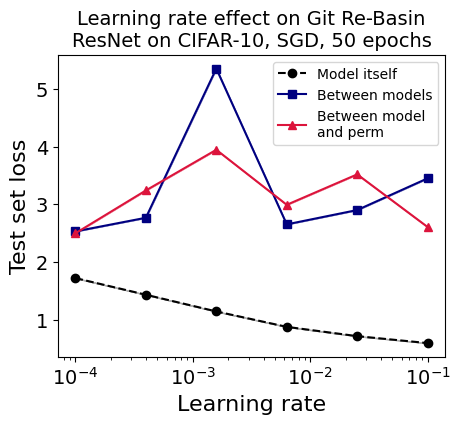

In [66]:
standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])

standard_bumps = np.reshape(standard_bumps,[reps,-1])
permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
model1_loss = np.reshape(model1_loss,[reps,-1])
model2_loss = np.reshape(model2_loss,[reps,-1])

def get_mean_and_error(vals):
  return np.mean(vals,axis=0), np.std(vals,axis=0)

mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)

fig = plt.figure(figsize = (5,4),dpi=100)
fig.patch.set_facecolor('white')

plt.title(f"Learning rate effect on Git Re-Basin\nResNet on CIFAR-10, SGD, {epochs} epochs",fontsize=14)

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",color="black",linestyle="--",label="Model itself")
plt.fill_between(LRs[:len(mean_standard_bumps)],
                 (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                 (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                 color=line.get_color(),
                 alpha=0.3
                 )

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",label="Between models")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",color="crimson",label="Between model\nand perm")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())

# from matplotlib.patches import Rectangle
# currentAxis = plt.gca()
# currentAxis.add_patch(Rectangle((LRs[-3], 0.0),0.1,2.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)

plt.legend(fontsize=10)
plt.show()

## Adam experiments sweep

In [55]:
reps = 1
LRs = np.exp(np.linspace(np.log(1e-3),np.log(0.04),6))
optimizers = ["adam"]
epochs = 50

In [56]:
all_flattened_models_tuples = [] # collecting all solutions every
stored_results_dict = []

for rep in range(reps): # to get error bars
  for i_opt, optimizer in enumerate(optimizers):
    for i_LR, LR in enumerate(LRs):

      print("*****************************************")
      print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")

      flattened_models_list = get_optima(
          num_epochs = epochs,
          config_optimizer = optimizer,
          learning_rate = LR,
          seed = int(np.random.rand()*100000000),
          )
      
      flattened_model1 = flattened_models_list[0]
      flattened_model2 = flattened_models_list[1]
      results_dict = analyze_optima(flattened_model1,flattened_model2)

      results_dict["LR"] = LR
      results_dict["optimizer"] = optimizer
      results_dict["epochs"] = epochs
      
      stored_results_dict.append(results_dict)
      all_flattened_models_tuples.append(flattened_models_list)

      print(results_dict)

*****************************************
Experiment 0 / 6
--------------------------
Starting run 0


  2%|▏         | 1/50 [00:12<10:36, 12.99s/it]

1.9969054 0.26124 1.9916679 0.2648


  4%|▍         | 2/50 [00:16<05:59,  7.49s/it]

1.7227646 0.37423998 1.7163699 0.3756


  6%|▌         | 3/50 [00:20<04:29,  5.73s/it]

1.6561651 0.39993998 1.6518089 0.3977


  8%|▊         | 4/50 [00:23<03:45,  4.91s/it]

1.683354 0.39428 1.6811405 0.397


 10%|█         | 5/50 [00:27<03:20,  4.45s/it]

1.4963555 0.45641997 1.4978299 0.45040002


 12%|█▏        | 6/50 [00:31<03:03,  4.17s/it]

1.304871 0.52834 1.3145614 0.5252


 14%|█▍        | 7/50 [00:34<02:51,  3.99s/it]

1.2526695 0.55006 1.2603798 0.5474


 16%|█▌        | 8/50 [00:38<02:43,  3.89s/it]

1.3084887 0.52426 1.3216269 0.5169


 18%|█▊        | 9/50 [00:42<02:37,  3.84s/it]

1.2194648 0.56226 1.2353792 0.55630004


 20%|██        | 10/50 [00:45<02:31,  3.78s/it]

1.156145 0.57952 1.1707737 0.57310003


 22%|██▏       | 11/50 [00:49<02:25,  3.73s/it]

1.0663536 0.62122 1.0863361 0.61450005


 24%|██▍       | 12/50 [00:53<02:21,  3.71s/it]

1.1080663 0.60104 1.1284041 0.595


 26%|██▌       | 13/50 [00:56<02:16,  3.70s/it]

1.0409042 0.62882 1.0671427 0.6186


 28%|██▊       | 14/50 [01:00<02:12,  3.68s/it]

1.0181632 0.63879997 1.0466751 0.63110006


 30%|███       | 15/50 [01:04<02:08,  3.67s/it]

1.0031536 0.64422 1.0265146 0.6352


 32%|███▏      | 16/50 [01:07<02:04,  3.67s/it]

0.96629953 0.65834 0.99905246 0.6459


 34%|███▍      | 17/50 [01:11<02:01,  3.67s/it]

0.91643935 0.67372 0.9433898 0.6635


 36%|███▌      | 18/50 [01:15<01:57,  3.66s/it]

0.854478 0.69886 0.8968476 0.6815


 38%|███▊      | 19/50 [01:18<01:53,  3.66s/it]

0.8935942 0.68648 0.93266755 0.67050004


 40%|████      | 20/50 [01:22<01:49,  3.66s/it]

0.9179601 0.6806 0.95350754 0.66590005


 42%|████▏     | 21/50 [01:26<01:45,  3.65s/it]

0.84056866 0.70374 0.87795705 0.69500005


 44%|████▍     | 22/50 [01:29<01:42,  3.65s/it]

0.81838435 0.71254 0.8591297 0.697


 46%|████▌     | 23/50 [01:33<01:38,  3.65s/it]

0.8317437 0.71173996 0.87364733 0.69920003


 48%|████▊     | 24/50 [01:36<01:34,  3.64s/it]

0.87553567 0.69346 0.92225707 0.68020004


 50%|█████     | 25/50 [01:40<01:30,  3.64s/it]

0.84089154 0.703 0.8829561 0.68770003


 52%|█████▏    | 26/50 [01:44<01:27,  3.63s/it]

0.9080309 0.68468 0.96011645 0.6685


 54%|█████▍    | 27/50 [01:47<01:23,  3.62s/it]

0.7716717 0.72716 0.8295624 0.70650005


 56%|█████▌    | 28/50 [01:51<01:19,  3.62s/it]

0.8571305 0.70022 0.91109556 0.6868


 58%|█████▊    | 29/50 [01:55<01:16,  3.62s/it]

0.72508013 0.74601996 0.78751725 0.72470003


 60%|██████    | 30/50 [01:58<01:12,  3.62s/it]

0.7348369 0.74074 0.794462 0.72360003


 62%|██████▏   | 31/50 [02:02<01:08,  3.62s/it]

0.7644914 0.73166 0.8232212 0.71300006


 64%|██████▍   | 32/50 [02:05<01:05,  3.62s/it]

0.7378928 0.743 0.79892623 0.72160006


 66%|██████▌   | 33/50 [02:09<01:01,  3.62s/it]

0.73160785 0.74435997 0.79837745 0.7218


 68%|██████▊   | 34/50 [02:13<00:57,  3.61s/it]

0.71965706 0.74904 0.7868973 0.72690004


 70%|███████   | 35/50 [02:16<00:54,  3.61s/it]

0.70609593 0.75434 0.7778597 0.72800004


 72%|███████▏  | 36/50 [02:20<00:50,  3.62s/it]

0.68190867 0.76199996 0.75420785 0.73700005


 74%|███████▍  | 37/50 [02:23<00:46,  3.62s/it]

0.68560886 0.76071995 0.7561216 0.73630005


 76%|███████▌  | 38/50 [02:27<00:43,  3.61s/it]

0.67112964 0.76496 0.74415356 0.7393


 78%|███████▊  | 39/50 [02:31<00:39,  3.62s/it]

0.6818086 0.76176 0.76007366 0.7346


 80%|████████  | 40/50 [02:34<00:36,  3.63s/it]

0.7021852 0.75408 0.77938104 0.7257


 82%|████████▏ | 41/50 [02:38<00:32,  3.63s/it]

0.6829484 0.76247996 0.7615856 0.7364


 84%|████████▍ | 42/50 [02:42<00:29,  3.63s/it]

0.65620184 0.77074 0.7350798 0.74410003


 86%|████████▌ | 43/50 [02:45<00:25,  3.63s/it]

0.7025772 0.75527996 0.779812 0.7282


 88%|████████▊ | 44/50 [02:49<00:21,  3.63s/it]

0.64377177 0.77642 0.7225164 0.7486


 90%|█████████ | 45/50 [02:53<00:18,  3.64s/it]

0.6723278 0.76559997 0.7524174 0.73800004


 92%|█████████▏| 46/50 [02:56<00:14,  3.64s/it]

0.65876764 0.77011997 0.7399613 0.74270004


 94%|█████████▍| 47/50 [03:00<00:10,  3.64s/it]

0.65564656 0.77182 0.73603565 0.7436


 96%|█████████▌| 48/50 [03:03<00:07,  3.63s/it]

0.6497799 0.77308 0.7298531 0.74640006


 98%|█████████▊| 49/50 [03:07<00:03,  3.63s/it]

0.6554669 0.77072 0.7360233 0.74500006


100%|██████████| 50/50 [03:11<00:00,  3.82s/it]

0.65212804 0.7723 0.7328413 0.74490005
-----------------
Run 0 DONE!


Run=0 test loss=0.7328412532806396 test accuracy=0.7449000477790833 train loss=0.6521280407905579 train accuracy=0.7723000049591064
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:11<09:41, 11.87s/it]

2.0079508 0.24693999 2.003745 0.24930002


  4%|▍         | 2/50 [00:15<05:36,  7.02s/it]

1.7152591 0.37736 1.7093425 0.37770003


  6%|▌         | 3/50 [00:19<04:17,  5.47s/it]

1.6497502 0.38476 1.6520634 0.3828


  8%|▊         | 4/50 [00:22<03:38,  4.74s/it]

1.554827 0.4425 1.5595483 0.43490002


 10%|█         | 5/50 [00:26<03:15,  4.34s/it]

1.4734548 0.46752 1.4721699 0.46510002


 12%|█▏        | 6/50 [00:29<03:00,  4.09s/it]

1.4277543 0.4822 1.426546 0.48070002


 14%|█▍        | 7/50 [00:33<02:49,  3.94s/it]

1.2869339 0.52972 1.291197 0.52970004


 16%|█▌        | 8/50 [00:37<02:41,  3.84s/it]

1.242544 0.54969996 1.2498298 0.5461


 18%|█▊        | 9/50 [00:40<02:34,  3.76s/it]

1.3137026 0.5335 1.3223878 0.53110003


 20%|██        | 10/50 [00:44<02:28,  3.72s/it]

1.2299333 0.56492 1.2457933 0.5564


 22%|██▏       | 11/50 [00:48<02:23,  3.69s/it]

1.0797237 0.61442 1.1020617 0.6075


 24%|██▍       | 12/50 [00:51<02:19,  3.67s/it]

1.1150091 0.60209996 1.1334267 0.5967


 26%|██▌       | 13/50 [00:55<02:15,  3.65s/it]

1.1371225 0.59521997 1.1631035 0.5827


 28%|██▊       | 14/50 [00:58<02:11,  3.64s/it]

0.9964917 0.64684 1.0210253 0.64140004


 30%|███       | 15/50 [01:02<02:07,  3.63s/it]

1.0164403 0.64011997 1.0505377 0.6247


 32%|███▏      | 16/50 [01:06<02:03,  3.63s/it]

0.9732173 0.65494 1.0010725 0.6466


 34%|███▍      | 17/50 [01:09<01:59,  3.63s/it]

1.0447106 0.62792 1.0774717 0.6136


 36%|███▌      | 18/50 [01:13<01:56,  3.63s/it]

0.9972623 0.64519995 1.030757 0.63460004


 38%|███▊      | 19/50 [01:17<01:52,  3.63s/it]

1.0386127 0.63677996 1.070142 0.6291


 40%|████      | 20/50 [01:20<01:48,  3.63s/it]

0.9278579 0.66984 0.96990466 0.65800005


 42%|████▏     | 21/50 [01:24<01:45,  3.63s/it]

0.9544995 0.66514 0.99387574 0.6571


 44%|████▍     | 22/50 [01:27<01:41,  3.63s/it]

0.91316175 0.6757 0.95275533 0.66810006


 46%|████▌     | 23/50 [01:31<01:38,  3.63s/it]

0.92460203 0.67351997 0.96677613 0.65980005


 48%|████▊     | 24/50 [01:35<01:34,  3.63s/it]

0.99490726 0.6641 1.0441003 0.6477


 50%|█████     | 25/50 [01:38<01:30,  3.63s/it]

0.8269121 0.70676 0.87648463 0.6923


 52%|█████▏    | 26/50 [01:42<01:26,  3.62s/it]

0.8831262 0.69108 0.93090993 0.67840004


 54%|█████▍    | 27/50 [01:46<01:23,  3.62s/it]

0.8192848 0.70923996 0.8773151 0.69210005


 56%|█████▌    | 28/50 [01:49<01:19,  3.62s/it]

0.78696257 0.72055995 0.83932555 0.7037


 58%|█████▊    | 29/50 [01:53<01:16,  3.62s/it]

0.8046795 0.71525997 0.86439556 0.70290005


 60%|██████    | 30/50 [01:56<01:12,  3.63s/it]

0.8377342 0.70484 0.8877313 0.6891


 62%|██████▏   | 31/50 [02:00<01:08,  3.63s/it]

0.808815 0.718 0.869214 0.70250005


 64%|██████▍   | 32/50 [02:04<01:05,  3.63s/it]

0.83625257 0.70978 0.89597887 0.69140005


 66%|██████▌   | 33/50 [02:07<01:01,  3.63s/it]

0.7462728 0.74064 0.8151949 0.7177


 68%|██████▊   | 34/50 [02:11<00:58,  3.64s/it]

0.76102966 0.73363996 0.8229262 0.71680003


 70%|███████   | 35/50 [02:15<00:54,  3.63s/it]

0.7723091 0.72959995 0.8340472 0.7131


 72%|███████▏  | 36/50 [02:18<00:50,  3.63s/it]

0.7153656 0.74737996 0.7790594 0.73


 74%|███████▍  | 37/50 [02:22<00:47,  3.63s/it]

0.78854805 0.72543997 0.8536823 0.7034


 76%|███████▌  | 38/50 [02:25<00:43,  3.63s/it]

0.7184803 0.74794 0.7859878 0.7279


 78%|███████▊  | 39/50 [02:29<00:39,  3.63s/it]

0.6848075 0.76048 0.7519649 0.74160004


 80%|████████  | 40/50 [02:33<00:36,  3.64s/it]

0.69792855 0.75501996 0.77208674 0.73050004


 82%|████████▏ | 41/50 [02:36<00:32,  3.63s/it]

0.73160934 0.7453 0.80869097 0.7235


 84%|████████▍ | 42/50 [02:40<00:29,  3.63s/it]

0.7282027 0.74464 0.79908264 0.7249


 86%|████████▌ | 43/50 [02:44<00:25,  3.64s/it]

0.6572633 0.77002 0.7324088 0.7462


 88%|████████▊ | 44/50 [02:47<00:21,  3.63s/it]

0.6830361 0.761 0.7576356 0.73960006


 90%|█████████ | 45/50 [02:51<00:18,  3.63s/it]

0.67637944 0.7626 0.74998045 0.74170005


 92%|█████████▏| 46/50 [02:55<00:14,  3.63s/it]

0.6794597 0.76216 0.7545152 0.7404


 94%|█████████▍| 47/50 [02:58<00:10,  3.62s/it]

0.68802977 0.75908 0.7633107 0.73770005


 96%|█████████▌| 48/50 [03:02<00:07,  3.62s/it]

0.680892 0.7611 0.7559551 0.7404


 98%|█████████▊| 49/50 [03:05<00:03,  3.62s/it]

0.67488545 0.76386 0.7499492 0.74230003


100%|██████████| 50/50 [03:09<00:00,  3.79s/it]

0.67708874 0.76309997 0.7521588 0.74130005
-----------------
Run 1 DONE!


Run=1 test loss=0.7521587014198303 test accuracy=0.7413000464439392 train loss=0.677088737487793 train accuracy=0.7630999684333801
0/P_blockgroups_1/blocks_1_inner: 6.070533752441406
0/P_blockgroups_0/blocks_1_inner: 2.884449005126953
0/P_bg1: 8.527679443359375
0/P_bg2: 24.89971923828125
0/P_blockgroups_2/blocks_0_inner: 7.9535675048828125
0/P_blockgroups_1/blocks_0_inner: 6.044208526611328
0/P_blockgroups_1/blocks_2_inner: 4.241455078125
0/P_blockgroups_2/blocks_1_inner: 7.004646301269531
0/P_blockgroups_0/blocks_0_inner: 3.4800662994384766
0/P_bg0: 0.0811614990234375
0/P_blockgroups_0/blocks_2_inner: 2.5277175903320312
0/P_blockgroups_2/blocks_2_inner: 6.6271820068359375
1/P_blockgroups_0/blocks_0_inner: 0.117889404296875
1/P_blockgroups_0/blocks_1_inner: 0.3849658966064453
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 3.4583091735839844
1/P_bg2: 0.0
1/P_bg1: 0.0
1/P_blockgroups_1/blocks_2_inner: 0.0
1/P_blockgroups_2/blocks_0_inner: 0.0
1/P_bg0: 0.0
1/P_blo

  2%|▏         | 1/50 [00:12<10:14, 12.54s/it]

1.8744643 0.32456 1.8694663 0.32520002


  4%|▍         | 2/50 [00:16<05:50,  7.29s/it]

1.682756 0.3951 1.6815199 0.39620003


  6%|▌         | 3/50 [00:19<04:27,  5.69s/it]

1.5605073 0.43094 1.558324 0.42920002


  8%|▊         | 4/50 [00:23<03:44,  4.88s/it]

1.4010068 0.48861998 1.399629 0.49100003


 10%|█         | 5/50 [00:27<03:19,  4.43s/it]

1.324505 0.50996 1.3313236 0.51460004


 12%|█▏        | 6/50 [00:30<03:03,  4.16s/it]

1.3382769 0.50292 1.3449612 0.49940002


 14%|█▍        | 7/50 [00:34<02:51,  3.99s/it]

1.4794706 0.46655998 1.4947975 0.46500003


 16%|█▌        | 8/50 [00:38<02:43,  3.89s/it]

1.1606926 0.58515996 1.1756405 0.58610004


 18%|█▊        | 9/50 [00:41<02:35,  3.80s/it]

1.1870977 0.58124 1.2077734 0.5744


 20%|██        | 10/50 [00:45<02:30,  3.76s/it]

1.098566 0.60712 1.1189678 0.60440004


 22%|██▏       | 11/50 [00:49<02:25,  3.73s/it]

1.0735018 0.611 1.0995052 0.5996


 24%|██▍       | 12/50 [00:52<02:20,  3.70s/it]

1.0776023 0.61626 1.1109867 0.6079


 26%|██▌       | 13/50 [00:56<02:16,  3.69s/it]

1.0439495 0.62472 1.0796094 0.6147


 28%|██▊       | 14/50 [01:00<02:11,  3.67s/it]

0.9335715 0.66561997 0.9632473 0.65540004


 30%|███       | 15/50 [01:03<02:07,  3.65s/it]

0.8754541 0.68758 0.90367067 0.6769


 32%|███▏      | 16/50 [01:07<02:03,  3.64s/it]

1.0327541 0.64092 1.0658617 0.6326


 34%|███▍      | 17/50 [01:10<01:59,  3.63s/it]

0.879849 0.68746 0.9204596 0.6725


 36%|███▌      | 18/50 [01:14<01:56,  3.64s/it]

0.9202042 0.67704 0.9593421 0.66880006


 38%|███▊      | 19/50 [01:18<01:52,  3.63s/it]

0.8357809 0.70506 0.8765858 0.69070005


 40%|████      | 20/50 [01:21<01:48,  3.63s/it]

0.8253309 0.7064 0.864413 0.69610006


 42%|████▏     | 21/50 [01:25<01:45,  3.62s/it]

0.892297 0.68575996 0.93073684 0.67590004


 44%|████▍     | 22/50 [01:28<01:41,  3.62s/it]

0.83151233 0.70746 0.87843627 0.69470006


 46%|████▌     | 23/50 [01:32<01:37,  3.62s/it]

0.792402 0.72108 0.8423271 0.70750004


 48%|████▊     | 24/50 [01:36<01:34,  3.62s/it]

0.8110382 0.71492 0.8661292 0.70180005


 50%|█████     | 25/50 [01:39<01:30,  3.63s/it]

0.77901787 0.72767997 0.83288556 0.71760005


 52%|█████▏    | 26/50 [01:43<01:27,  3.63s/it]

0.739108 0.74226 0.79184955 0.72300005


 54%|█████▍    | 27/50 [01:47<01:23,  3.63s/it]

0.73712844 0.7439 0.78379047 0.725


 56%|█████▌    | 28/50 [01:50<01:19,  3.63s/it]

0.6946171 0.75698 0.7470674 0.73920006


 58%|█████▊    | 29/50 [01:54<01:16,  3.63s/it]

0.6823264 0.7614 0.738427 0.7458


 60%|██████    | 30/50 [01:58<01:12,  3.63s/it]

0.86930895 0.70256 0.93057513 0.68670005


 62%|██████▏   | 31/50 [02:01<01:09,  3.64s/it]

0.7110822 0.7581 0.7785482 0.73990005


 64%|██████▍   | 32/50 [02:05<01:05,  3.63s/it]

0.63501745 0.78011996 0.6996744 0.7588


 66%|██████▌   | 33/50 [02:08<01:01,  3.63s/it]

0.6512526 0.77625996 0.7152589 0.7544


 68%|██████▊   | 34/50 [02:12<00:57,  3.62s/it]

0.64062953 0.77988 0.70670336 0.7601


 70%|███████   | 35/50 [02:16<00:54,  3.62s/it]

0.64960074 0.77576 0.7138282 0.7534


 72%|███████▏  | 36/50 [02:19<00:50,  3.62s/it]

0.63857853 0.78095996 0.70307314 0.76110005


 74%|███████▍  | 37/50 [02:23<00:47,  3.62s/it]

0.62991714 0.78404 0.70036554 0.76420003


 76%|███████▌  | 38/50 [02:27<00:43,  3.63s/it]

0.6251682 0.78608 0.6949732 0.7659


 78%|███████▊  | 39/50 [02:30<00:39,  3.63s/it]

0.5535803 0.80862 0.63311815 0.7843


 80%|████████  | 40/50 [02:34<00:36,  3.63s/it]

0.60468316 0.79179996 0.6809296 0.76760006


 82%|████████▏ | 41/50 [02:37<00:32,  3.62s/it]

0.573525 0.80256 0.65223527 0.7756


 84%|████████▍ | 42/50 [02:41<00:28,  3.62s/it]

0.5599183 0.80733997 0.6380191 0.7821


 86%|████████▌ | 43/50 [02:45<00:25,  3.62s/it]

0.56360525 0.806 0.64794755 0.77870005


 88%|████████▊ | 44/50 [02:48<00:21,  3.62s/it]

0.5801704 0.79991996 0.659493 0.7734


 90%|█████████ | 45/50 [02:52<00:18,  3.62s/it]

0.56602037 0.80552 0.64599687 0.7807


 92%|█████████▏| 46/50 [02:56<00:14,  3.62s/it]

0.58202595 0.80034 0.6632828 0.7735


 94%|█████████▍| 47/50 [02:59<00:10,  3.63s/it]

0.5681986 0.80498 0.65105647 0.77820003


 96%|█████████▌| 48/50 [03:03<00:07,  3.63s/it]

0.5607334 0.80706 0.6435386 0.781


 98%|█████████▊| 49/50 [03:06<00:03,  3.63s/it]

0.55716544 0.80872 0.6400675 0.78110003


100%|██████████| 50/50 [03:10<00:00,  3.81s/it]

0.55412793 0.80978 0.63711333 0.78150004
-----------------
Run 0 DONE!


Run=0 test loss=0.6371133327484131 test accuracy=0.7815000414848328 train loss=0.5541278719902039 train accuracy=0.8097800016403198
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:11<09:43, 11.91s/it]

1.9265469 0.27306 1.917454 0.28210002


  4%|▍         | 2/50 [00:15<05:38,  7.05s/it]

1.6308293 0.40598 1.6278373 0.40760002


  6%|▌         | 3/50 [00:19<04:18,  5.49s/it]

1.5706396 0.42744 1.5702897 0.42180002


  8%|▊         | 4/50 [00:22<03:38,  4.75s/it]

1.446061 0.48007998 1.4471582 0.4762


 10%|█         | 5/50 [00:26<03:15,  4.35s/it]

1.4233079 0.48444 1.4225109 0.4841


 12%|█▏        | 6/50 [00:30<03:00,  4.11s/it]

1.3198828 0.51938 1.3196704 0.51850003


 14%|█▍        | 7/50 [00:33<02:49,  3.95s/it]

1.3068273 0.52301997 1.3164344 0.5188


 16%|█▌        | 8/50 [00:37<02:41,  3.85s/it]

1.1652136 0.58726 1.1842268 0.5798


 18%|█▊        | 9/50 [00:41<02:35,  3.79s/it]

1.1918204 0.57343996 1.199491 0.5722


 20%|██        | 10/50 [00:44<02:29,  3.74s/it]

1.087054 0.60403997 1.1108254 0.5934


 22%|██▏       | 11/50 [00:48<02:24,  3.70s/it]

1.0217828 0.63486 1.0360582 0.62780005


 24%|██▍       | 12/50 [00:51<02:19,  3.68s/it]

1.0104656 0.6378 1.0281569 0.6315


 26%|██▌       | 13/50 [00:55<02:15,  3.67s/it]

0.9468081 0.66117996 0.97077554 0.65400004


 28%|██▊       | 14/50 [00:59<02:11,  3.66s/it]

0.8917475 0.68218 0.9238741 0.67530006


 30%|███       | 15/50 [01:02<02:08,  3.66s/it]

0.94361717 0.66223997 0.9670149 0.6553


 32%|███▏      | 16/50 [01:06<02:04,  3.67s/it]

0.8922867 0.68274 0.9211532 0.67370003


 34%|███▍      | 17/50 [01:10<02:00,  3.66s/it]

0.8285689 0.70374 0.8604633 0.7002


 36%|███▌      | 18/50 [01:13<01:57,  3.66s/it]

0.8217174 0.70892 0.85881 0.6987


 38%|███▊      | 19/50 [01:17<01:53,  3.65s/it]

0.80376303 0.71414 0.8407534 0.70830005


 40%|████      | 20/50 [01:21<01:49,  3.65s/it]

0.8696781 0.69536 0.902582 0.68710005


 42%|████▏     | 21/50 [01:24<01:46,  3.66s/it]

0.75135326 0.73368 0.79836404 0.7206


 44%|████▍     | 22/50 [01:28<01:42,  3.65s/it]

0.77796656 0.7291 0.8305849 0.7121


 46%|████▌     | 23/50 [01:32<01:38,  3.65s/it]

0.7927672 0.72428 0.8418078 0.7128


 48%|████▊     | 24/50 [01:35<01:34,  3.65s/it]

0.7672274 0.73324 0.8192502 0.7178


 50%|█████     | 25/50 [01:39<01:31,  3.65s/it]

0.76669157 0.72964 0.8144179 0.7181


 52%|█████▏    | 26/50 [01:42<01:27,  3.65s/it]

0.7008031 0.75615996 0.7546281 0.7401


 54%|█████▍    | 27/50 [01:46<01:23,  3.64s/it]

0.66667974 0.7698 0.7220231 0.75350004


 56%|█████▌    | 28/50 [01:50<01:20,  3.64s/it]

0.692828 0.7578 0.74953043 0.7444


 58%|█████▊    | 29/50 [01:53<01:16,  3.64s/it]

0.6512576 0.77191997 0.7054896 0.7583


 60%|██████    | 30/50 [01:57<01:12,  3.64s/it]

0.67057925 0.76607996 0.7300644 0.7523


 62%|██████▏   | 31/50 [02:01<01:09,  3.64s/it]

0.68394405 0.76453996 0.74723625 0.7504


 64%|██████▍   | 32/50 [02:04<01:05,  3.64s/it]

0.5953258 0.79183996 0.6584302 0.7735


 66%|██████▌   | 33/50 [02:08<01:01,  3.64s/it]

0.66854113 0.76866 0.7406977 0.75180006


 68%|██████▊   | 34/50 [02:12<00:58,  3.64s/it]

0.5783587 0.79898 0.64895785 0.7771


 70%|███████   | 35/50 [02:15<00:54,  3.64s/it]

0.6166417 0.78455997 0.6910238 0.76330006


 72%|███████▏  | 36/50 [02:19<00:50,  3.64s/it]

0.5779773 0.79916 0.6490808 0.7774


 74%|███████▍  | 37/50 [02:23<00:47,  3.64s/it]

0.61978346 0.78524 0.69271106 0.76690006


 76%|███████▌  | 38/50 [02:26<00:43,  3.64s/it]

0.56222016 0.80384 0.63136595 0.78410006


 78%|███████▊  | 39/50 [02:30<00:40,  3.65s/it]

0.5610365 0.80432 0.63851726 0.77940005


 80%|████████  | 40/50 [02:33<00:36,  3.64s/it]

0.56306595 0.8056 0.6446016 0.78010005


 82%|████████▏ | 41/50 [02:37<00:32,  3.64s/it]

0.5521159 0.80838 0.63282603 0.7828


 84%|████████▍ | 42/50 [02:41<00:29,  3.64s/it]

0.5361901 0.8136 0.6201054 0.78760004


 86%|████████▌ | 43/50 [02:44<00:25,  3.65s/it]

0.5709826 0.80392 0.6609565 0.77900004


 88%|████████▊ | 44/50 [02:48<00:21,  3.65s/it]

0.568285 0.8046 0.6589706 0.77970004


 90%|█████████ | 45/50 [02:52<00:18,  3.65s/it]

0.5822316 0.79876 0.66719586 0.77500004


 92%|█████████▏| 46/50 [02:55<00:14,  3.65s/it]

0.54132414 0.81251997 0.62684256 0.7864


 94%|█████████▍| 47/50 [02:59<00:10,  3.66s/it]

0.5373752 0.81314 0.6259328 0.78650004


 96%|█████████▌| 48/50 [03:03<00:07,  3.66s/it]

0.5370235 0.8131 0.6246282 0.78740007


 98%|█████████▊| 49/50 [03:06<00:03,  3.66s/it]

0.53257203 0.81431997 0.6198825 0.7889


100%|██████████| 50/50 [03:10<00:00,  3.81s/it]

0.532215 0.8145 0.6200146 0.78970003
-----------------
Run 1 DONE!


Run=1 test loss=0.6200146079063416 test accuracy=0.7897000312805176 train loss=0.532214879989624 train accuracy=0.8144999742507935
0/P_blockgroups_1/blocks_1_inner: 9.147464752197266
0/P_blockgroups_0/blocks_1_inner: 4.309759140014648
0/P_bg1: 11.62347412109375
0/P_bg2: 43.58740234375
0/P_blockgroups_2/blocks_0_inner: 14.273239135742188
0/P_blockgroups_1/blocks_0_inner: 7.032192230224609
0/P_blockgroups_1/blocks_2_inner: 4.933811187744141
0/P_blockgroups_2/blocks_1_inner: 13.156951904296875
0/P_blockgroups_0/blocks_0_inner: 4.631233215332031
0/P_bg0: 1.277801513671875
0/P_blockgroups_0/blocks_2_inner: 3.989166259765625
0/P_blockgroups_2/blocks_2_inner: 12.873283386230469
1/P_blockgroups_0/blocks_0_inner: 0.1712665557861328
1/P_blockgroups_0/blocks_1_inner: 0.47739601135253906
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 5.242828369140625
1/P_bg2: 0.3116455078125
1/P_bg1: 0.0
1/P_blockgroups_1/blocks_2_inner: 0.0
1/P_blockgroups_2/blocks_0_inner: 0.98983764648

  2%|▏         | 1/50 [00:12<10:21, 12.68s/it]

1.8651824 0.32206 1.8528693 0.3287


  4%|▍         | 2/50 [00:16<05:53,  7.37s/it]

1.6601202 0.3915 1.6570333 0.393


  6%|▌         | 3/50 [00:20<04:27,  5.68s/it]

1.6310364 0.40918 1.626085 0.41730002


  8%|▊         | 4/50 [00:23<03:44,  4.89s/it]

1.5742642 0.42382 1.5748714 0.4264


 10%|█         | 5/50 [00:27<03:19,  4.43s/it]

1.5232012 0.44548 1.5265234 0.44040003


 12%|█▏        | 6/50 [00:30<03:02,  4.16s/it]

1.3651661 0.49548 1.3731313 0.49410003


 14%|█▍        | 7/50 [00:34<02:51,  3.98s/it]

1.2616954 0.55248 1.2669041 0.55020005


 16%|█▌        | 8/50 [00:38<02:42,  3.87s/it]

1.1582991 0.58232 1.1692407 0.57290006


 18%|█▊        | 9/50 [00:41<02:35,  3.79s/it]

1.2794372 0.54906 1.2982764 0.5414


 20%|██        | 10/50 [00:45<02:29,  3.75s/it]

1.0573177 0.62156 1.082062 0.61350006


 22%|██▏       | 11/50 [00:49<02:25,  3.72s/it]

0.9835322 0.65114 1.0104808 0.6417


 24%|██▍       | 12/50 [00:52<02:20,  3.70s/it]

1.081542 0.61862 1.1046485 0.6089


 26%|██▌       | 13/50 [00:56<02:16,  3.68s/it]

0.95906514 0.65816 0.986571 0.6506


 28%|██▊       | 14/50 [01:00<02:11,  3.66s/it]

0.9979961 0.64875996 1.02782 0.63790005


 30%|███       | 15/50 [01:03<02:07,  3.65s/it]

0.9174768 0.67862 0.94871634 0.6639


 32%|███▏      | 16/50 [01:07<02:04,  3.65s/it]

0.96315545 0.66242 0.99720496 0.6484


 34%|███▍      | 17/50 [01:10<01:59,  3.64s/it]

0.9825414 0.65658 1.0245491 0.6434


 36%|███▌      | 18/50 [01:14<01:56,  3.63s/it]

0.8331393 0.70596 0.87241566 0.69380003


 38%|███▊      | 19/50 [01:18<01:52,  3.63s/it]

0.8033411 0.71558 0.8500183 0.7023


 40%|████      | 20/50 [01:21<01:48,  3.62s/it]

0.79141825 0.71984 0.8457502 0.7023


 42%|████▏     | 21/50 [01:25<01:45,  3.62s/it]

0.81906426 0.71312 0.8646888 0.7005


 44%|████▍     | 22/50 [01:29<01:41,  3.63s/it]

0.81656826 0.7129 0.88521296 0.69320005


 46%|████▌     | 23/50 [01:32<01:37,  3.63s/it]

0.6919084 0.75662 0.7493785 0.73660004


 48%|████▊     | 24/50 [01:36<01:34,  3.63s/it]

0.66252095 0.76684 0.7278344 0.74460006


 50%|█████     | 25/50 [01:39<01:30,  3.62s/it]

0.8797411 0.69931996 0.9512592 0.6793


 52%|█████▏    | 26/50 [01:43<01:26,  3.62s/it]

0.65752727 0.76905996 0.71408194 0.75100005


 54%|█████▍    | 27/50 [01:47<01:23,  3.62s/it]

0.6302563 0.77954 0.6998184 0.7566


 56%|█████▌    | 28/50 [01:50<01:19,  3.63s/it]

0.6987483 0.75604 0.7701629 0.73370004


 58%|█████▊    | 29/50 [01:54<01:16,  3.63s/it]

0.647673 0.773 0.7200807 0.7516


 60%|██████    | 30/50 [01:58<01:12,  3.63s/it]

0.61763066 0.7841 0.6910111 0.76360005


 62%|██████▏   | 31/50 [02:01<01:09,  3.64s/it]

0.6082745 0.78992 0.68110216 0.77040005


 64%|██████▍   | 32/50 [02:05<01:05,  3.64s/it]

0.57382095 0.80031997 0.6581931 0.777


 66%|██████▌   | 33/50 [02:08<01:01,  3.64s/it]

0.6128558 0.78757995 0.7000693 0.7595


 68%|██████▊   | 34/50 [02:12<00:58,  3.64s/it]

0.5968657 0.79407996 0.6791204 0.7699


 70%|███████   | 35/50 [02:16<00:54,  3.64s/it]

0.56052756 0.80572 0.6429602 0.77480006


 72%|███████▏  | 36/50 [02:19<00:50,  3.64s/it]

0.5848722 0.79912 0.67868954 0.7698


 74%|███████▍  | 37/50 [02:23<00:47,  3.64s/it]

0.5649288 0.80631995 0.66819644 0.77590007


 76%|███████▌  | 38/50 [02:27<00:43,  3.65s/it]

0.521418 0.81788 0.6075975 0.79200006


 78%|███████▊  | 39/50 [02:30<00:40,  3.65s/it]

0.5263308 0.81858 0.6294931 0.78650004


 80%|████████  | 40/50 [02:34<00:36,  3.65s/it]

0.53130513 0.81601995 0.6296349 0.78590006


 82%|████████▏ | 41/50 [02:38<00:32,  3.64s/it]

0.48587865 0.83198 0.5887333 0.7983


 84%|████████▍ | 42/50 [02:41<00:29,  3.65s/it]

0.51786065 0.82298 0.6255476 0.79060006


 86%|████████▌ | 43/50 [02:45<00:25,  3.65s/it]

0.5141047 0.82332 0.6195731 0.79240006


 88%|████████▊ | 44/50 [02:49<00:21,  3.65s/it]

0.5144247 0.82258 0.62661 0.79050004


 90%|█████████ | 45/50 [02:52<00:18,  3.65s/it]

0.46552458 0.83893996 0.57307154 0.80560005


 92%|█████████▏| 46/50 [02:56<00:14,  3.65s/it]

0.49190673 0.8311 0.60388744 0.79940003


 94%|█████████▍| 47/50 [03:00<00:10,  3.64s/it]

0.48181286 0.83456 0.5951376 0.8011


 96%|█████████▌| 48/50 [03:03<00:07,  3.64s/it]

0.4776485 0.83524 0.58897406 0.80420005


 98%|█████████▊| 49/50 [03:07<00:03,  3.63s/it]

0.46856967 0.8383 0.5799875 0.8058


100%|██████████| 50/50 [03:10<00:00,  3.82s/it]

0.4709596 0.83769995 0.5824302 0.8054
-----------------
Run 0 DONE!


Run=0 test loss=0.5824301242828369 test accuracy=0.805400013923645 train loss=0.4709596037864685 train accuracy=0.8376999497413635
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:12<09:49, 12.03s/it]

2.1947894 0.21664 2.1796603 0.2196


  4%|▍         | 2/50 [00:15<05:40,  7.10s/it]

1.7658553 0.33892 1.7493153 0.3481


  6%|▌         | 3/50 [00:19<04:19,  5.52s/it]

1.549124 0.43874 1.5538685 0.4379


  8%|▊         | 4/50 [00:22<03:40,  4.79s/it]

1.521373 0.43798 1.5204096 0.43340003


 10%|█         | 5/50 [00:26<03:17,  4.39s/it]

1.4283504 0.47588 1.4314235 0.46840003


 12%|█▏        | 6/50 [00:30<03:02,  4.15s/it]

1.398564 0.48926 1.4005433 0.48330003


 14%|█▍        | 7/50 [00:33<02:51,  3.98s/it]

1.2418135 0.5511 1.2552729 0.54580003


 16%|█▌        | 8/50 [00:37<02:42,  3.87s/it]

1.2475443 0.54991996 1.2683805 0.5446


 18%|█▊        | 9/50 [00:41<02:35,  3.80s/it]

1.102208 0.60656 1.1171856 0.60150003


 20%|██        | 10/50 [00:44<02:30,  3.76s/it]

1.0751096 0.61464 1.0941492 0.6054


 22%|██▏       | 11/50 [00:48<02:25,  3.73s/it]

1.0315009 0.62865996 1.0525194 0.6189


 24%|██▍       | 12/50 [00:52<02:20,  3.70s/it]

0.98521215 0.64944 1.0070596 0.6413


 26%|██▌       | 13/50 [00:55<02:16,  3.69s/it]

0.98204887 0.65364 1.0095624 0.64610004


 28%|██▊       | 14/50 [00:59<02:12,  3.68s/it]

0.888548 0.68424 0.9250662 0.67660004


 30%|███       | 15/50 [01:03<02:08,  3.68s/it]

0.844097 0.69751996 0.87270844 0.69250005


 32%|███▏      | 16/50 [01:06<02:04,  3.66s/it]

0.8902142 0.68472 0.9341147 0.66990006


 34%|███▍      | 17/50 [01:10<02:00,  3.65s/it]

0.78130686 0.72458 0.8188618 0.7171


 36%|███▌      | 18/50 [01:14<01:56,  3.64s/it]

0.77909964 0.72742 0.8187052 0.72010005


 38%|███▊      | 19/50 [01:17<01:52,  3.64s/it]

0.7664712 0.73344 0.82612926 0.72010005


 40%|████      | 20/50 [01:21<01:49,  3.65s/it]

0.6991471 0.7571 0.74782944 0.7451


 42%|████▏     | 21/50 [01:25<01:45,  3.64s/it]

0.6790682 0.76188 0.737886 0.74570006


 44%|████▍     | 22/50 [01:28<01:41,  3.64s/it]

0.70270395 0.75426 0.7529037 0.73950005


 46%|████▌     | 23/50 [01:32<01:38,  3.63s/it]

0.6936131 0.76056 0.76059365 0.74270004


 48%|████▊     | 24/50 [01:35<01:34,  3.63s/it]

0.61765695 0.78521997 0.6780058 0.7663


 50%|█████     | 25/50 [01:39<01:30,  3.63s/it]

0.6052959 0.78832 0.6736816 0.7698


 52%|█████▏    | 26/50 [01:43<01:27,  3.63s/it]

0.5995909 0.7898 0.66971415 0.76790005


 54%|█████▍    | 27/50 [01:46<01:23,  3.62s/it]

0.63662505 0.77721995 0.70118153 0.75780004


 56%|█████▌    | 28/50 [01:50<01:19,  3.62s/it]

0.5539205 0.80744 0.6277567 0.78620005


 58%|█████▊    | 29/50 [01:54<01:16,  3.62s/it]

0.6158046 0.78506 0.6856431 0.7677


 60%|██████    | 30/50 [01:57<01:12,  3.62s/it]

0.56786853 0.79998 0.64053696 0.7752


 62%|██████▏   | 31/50 [02:01<01:08,  3.62s/it]

0.52529687 0.81821996 0.61216474 0.7911


 64%|██████▍   | 32/50 [02:04<01:05,  3.62s/it]

0.55626684 0.80806 0.6356232 0.78520006


 66%|██████▌   | 33/50 [02:08<01:01,  3.62s/it]

0.5513382 0.81148 0.64451903 0.78580004


 68%|██████▊   | 34/50 [02:12<00:57,  3.62s/it]

0.5700621 0.80123997 0.64974874 0.7746


 70%|███████   | 35/50 [02:15<00:54,  3.62s/it]

0.5421403 0.812 0.63562906 0.78550005


 72%|███████▏  | 36/50 [02:19<00:50,  3.61s/it]

0.4682078 0.83691996 0.56525934 0.80750006


 74%|███████▍  | 37/50 [02:22<00:47,  3.62s/it]

0.47789094 0.83239996 0.5728261 0.8044


 76%|███████▌  | 38/50 [02:26<00:43,  3.62s/it]

0.45899287 0.83948 0.5570049 0.80730003


 78%|███████▊  | 39/50 [02:30<00:39,  3.63s/it]

0.4776986 0.83526 0.5774475 0.80460006


 80%|████████  | 40/50 [02:33<00:36,  3.63s/it]

0.43749478 0.84705997 0.5406218 0.81610006


 82%|████████▏ | 41/50 [02:37<00:32,  3.63s/it]

0.43315977 0.84874 0.5395536 0.81490004


 84%|████████▍ | 42/50 [02:41<00:29,  3.63s/it]

0.43069053 0.8486 0.5374328 0.8151


 86%|████████▌ | 43/50 [02:44<00:25,  3.62s/it]

0.46270674 0.83958 0.56850713 0.8094


 88%|████████▊ | 44/50 [02:48<00:21,  3.62s/it]

0.42308953 0.85196 0.5303307 0.82080007


 90%|█████████ | 45/50 [02:51<00:18,  3.62s/it]

0.44433624 0.84524 0.5533731 0.8116


 92%|█████████▏| 46/50 [02:55<00:14,  3.62s/it]

0.42622373 0.8515 0.538019 0.8194


 94%|█████████▍| 47/50 [02:59<00:10,  3.62s/it]

0.44411662 0.84481996 0.55534154 0.8123


 96%|█████████▌| 48/50 [03:02<00:07,  3.63s/it]

0.43198633 0.84955996 0.54343504 0.81920004


 98%|█████████▊| 49/50 [03:06<00:03,  3.63s/it]

0.42987117 0.85042 0.5409891 0.8187


100%|██████████| 50/50 [03:10<00:00,  3.80s/it]

0.43302873 0.84929997 0.54429966 0.81810004
-----------------
Run 1 DONE!


Run=1 test loss=0.5442996621131897 test accuracy=0.8181000351905823 train loss=0.4330286979675293 train accuracy=0.849299967288971
0/P_blockgroups_1/blocks_1_inner: 21.774452209472656
0/P_blockgroups_0/blocks_1_inner: 7.975057601928711
0/P_bg1: 33.83680725097656
0/P_bg2: 110.92724609375
0/P_blockgroups_2/blocks_0_inner: 36.64387512207031
0/P_blockgroups_1/blocks_0_inner: 19.557952880859375
0/P_blockgroups_1/blocks_2_inner: 15.97610092163086
0/P_blockgroups_2/blocks_1_inner: 51.118492126464844
0/P_blockgroups_0/blocks_0_inner: 7.130352020263672
0/P_bg0: 2.1532058715820312
0/P_blockgroups_0/blocks_2_inner: 8.047855377197266
0/P_blockgroups_2/blocks_2_inner: 49.621978759765625
1/P_blockgroups_0/blocks_0_inner: 2.6593151092529297
1/P_blockgroups_0/blocks_1_inner: 2.8309707641601562
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 6.754283905029297
1/P_bg2: 5.358642578125
1/P_bg1: 1.1859588623046875
1/P_blockgroups_1/blocks_2_inner: 0.6750984191894531
1/P_blockgroups_

  2%|▏         | 1/50 [00:12<10:23, 12.73s/it]

1.8476434 0.3351 1.8404839 0.3391


  4%|▍         | 2/50 [00:16<05:54,  7.39s/it]

1.8314595 0.34318 1.8318366 0.3461


  6%|▌         | 3/50 [00:19<04:26,  5.67s/it]

1.5532534 0.4344 1.5499669 0.42920002


  8%|▊         | 4/50 [00:23<03:43,  4.86s/it]

1.5101365 0.44402 1.5118212 0.4408


 10%|█         | 5/50 [00:27<03:18,  4.41s/it]

1.3733381 0.50369996 1.3761669 0.49370003


 12%|█▏        | 6/50 [00:30<03:02,  4.15s/it]

1.2793729 0.53907996 1.2815244 0.53900003


 14%|█▍        | 7/50 [00:34<02:51,  3.98s/it]

1.2041279 0.56656 1.2109579 0.5633


 16%|█▌        | 8/50 [00:38<02:42,  3.87s/it]

1.179377 0.57739997 1.1905054 0.574


 18%|█▊        | 9/50 [00:41<02:35,  3.79s/it]

1.1353065 0.5947 1.1530488 0.5878


 20%|██        | 10/50 [00:45<02:29,  3.74s/it]

1.0953411 0.60477996 1.1193961 0.601


 22%|██▏       | 11/50 [00:49<02:24,  3.71s/it]

1.1366439 0.58831996 1.1647329 0.58000004


 24%|██▍       | 12/50 [00:52<02:20,  3.70s/it]

0.9360323 0.67038 0.9723576 0.6521


 26%|██▌       | 13/50 [00:56<02:15,  3.67s/it]

0.9683573 0.65314 1.0082095 0.6445


 28%|██▊       | 14/50 [00:59<02:12,  3.67s/it]

0.9672988 0.66002 1.003809 0.64890003


 30%|███       | 15/50 [01:03<02:08,  3.67s/it]

0.79175794 0.72164 0.8318458 0.7091


 32%|███▏      | 16/50 [01:07<02:04,  3.66s/it]

0.87541777 0.68904 0.9196734 0.67600006


 34%|███▍      | 17/50 [01:10<02:00,  3.65s/it]

0.8751606 0.69728 0.9323556 0.68210006


 36%|███▌      | 18/50 [01:14<01:56,  3.65s/it]

0.7942384 0.72168 0.8376882 0.71120006


 38%|███▊      | 19/50 [01:18<01:52,  3.64s/it]

0.89206207 0.69321996 0.93187004 0.6825


 40%|████      | 20/50 [01:21<01:49,  3.64s/it]

0.81944245 0.72402 0.8636354 0.71140003


 42%|████▏     | 21/50 [01:25<01:45,  3.64s/it]

0.6953726 0.75904 0.7530563 0.74780005


 44%|████▍     | 22/50 [01:29<01:41,  3.64s/it]

0.6507564 0.77426 0.7109925 0.75530005


 46%|████▌     | 23/50 [01:32<01:38,  3.64s/it]

0.6533848 0.77362 0.7135819 0.75570005


 48%|████▊     | 24/50 [01:36<01:34,  3.63s/it]

0.586398 0.79674 0.6605167 0.77210003


 50%|█████     | 25/50 [01:39<01:30,  3.64s/it]

0.59442353 0.79301995 0.6614167 0.7764


 52%|█████▏    | 26/50 [01:43<01:27,  3.64s/it]

0.74100685 0.74926 0.809657 0.73120004


 54%|█████▍    | 27/50 [01:47<01:23,  3.64s/it]

0.6207549 0.78562 0.69873035 0.76420003


 56%|█████▌    | 28/50 [01:50<01:20,  3.65s/it]

0.5974331 0.79345995 0.6686717 0.77230006


 58%|█████▊    | 29/50 [01:54<01:16,  3.65s/it]

0.5999444 0.79306 0.67556685 0.7724


 60%|██████    | 30/50 [01:58<01:12,  3.65s/it]

0.5293163 0.81703997 0.6081498 0.79170007


 62%|██████▏   | 31/50 [02:01<01:09,  3.65s/it]

0.5465994 0.81464 0.64176536 0.79080003


 64%|██████▍   | 32/50 [02:05<01:05,  3.65s/it]

0.50868607 0.82514 0.5956948 0.79450005


 66%|██████▌   | 33/50 [02:09<01:02,  3.65s/it]

0.46435592 0.83862 0.55793387 0.8112


 68%|██████▊   | 34/50 [02:12<00:58,  3.65s/it]

0.5004287 0.82817996 0.58862007 0.80140007


 70%|███████   | 35/50 [02:16<00:54,  3.64s/it]

0.45614696 0.84353995 0.5539462 0.8148


 72%|███████▏  | 36/50 [02:20<00:51,  3.65s/it]

0.45777163 0.84098 0.5593959 0.80990005


 74%|███████▍  | 37/50 [02:23<00:47,  3.65s/it]

0.457658 0.84132 0.56630903 0.80880004


 76%|███████▌  | 38/50 [02:27<00:43,  3.65s/it]

0.46620625 0.84006 0.5738158 0.8101


 78%|███████▊  | 39/50 [02:31<00:40,  3.65s/it]

0.42447057 0.85506 0.534884 0.82240003


 80%|████████  | 40/50 [02:34<00:36,  3.65s/it]

0.40564132 0.86087996 0.51976836 0.8263


 82%|████████▏ | 41/50 [02:38<00:32,  3.65s/it]

0.4037732 0.86127996 0.5165926 0.82440007


 84%|████████▍ | 42/50 [02:42<00:29,  3.65s/it]

0.403739 0.86182 0.5216105 0.8277


 86%|████████▌ | 43/50 [02:45<00:25,  3.65s/it]

0.39938906 0.86245996 0.5178414 0.82640004


 88%|████████▊ | 44/50 [02:49<00:21,  3.66s/it]

0.3869871 0.86737996 0.51047415 0.8317


 90%|█████████ | 45/50 [02:53<00:18,  3.67s/it]

0.39963543 0.8627 0.5219137 0.82850003


 92%|█████████▏| 46/50 [02:56<00:14,  3.68s/it]

0.38664928 0.86802 0.50935835 0.83110005


 94%|█████████▍| 47/50 [03:00<00:11,  3.68s/it]

0.38641167 0.86815995 0.51126206 0.83030003


 96%|█████████▌| 48/50 [03:04<00:07,  3.69s/it]

0.38915813 0.8677 0.51495445 0.83040005


 98%|█████████▊| 49/50 [03:07<00:03,  3.68s/it]

0.38701624 0.86828 0.5130669 0.8302


100%|██████████| 50/50 [03:11<00:00,  3.83s/it]

0.3898253 0.86754 0.5156721 0.8298
-----------------
Run 0 DONE!


Run=0 test loss=0.5156720280647278 test accuracy=0.829800009727478 train loss=0.3898252546787262 train accuracy=0.8675400018692017
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:12<09:57, 12.19s/it]

1.8759238 0.30126 1.8678188 0.3043


  4%|▍         | 2/50 [00:15<05:45,  7.19s/it]

1.7732205 0.34636 1.7650026 0.34680003


  6%|▌         | 3/50 [00:19<04:22,  5.58s/it]

1.5869159 0.41742 1.5809551 0.41900003


  8%|▊         | 4/50 [00:23<03:42,  4.83s/it]

1.5141046 0.45385998 1.5121671 0.4541


 10%|█         | 5/50 [00:26<03:19,  4.43s/it]

1.3720006 0.49811998 1.3768114 0.49260002


 12%|█▏        | 6/50 [00:30<03:04,  4.18s/it]

1.317396 0.52048 1.3204632 0.51780003


 14%|█▍        | 7/50 [00:34<02:52,  4.02s/it]

1.1931543 0.56944 1.2019999 0.5659


 16%|█▌        | 8/50 [00:37<02:43,  3.90s/it]

1.2652177 0.54473996 1.2751147 0.5431


 18%|█▊        | 9/50 [00:41<02:36,  3.82s/it]

1.0877628 0.6109 1.1024197 0.61350006


 20%|██        | 10/50 [00:45<02:30,  3.77s/it]

1.0231187 0.63734 1.0348344 0.6341


 22%|██▏       | 11/50 [00:48<02:25,  3.74s/it]

1.0422124 0.63111997 1.0652417 0.61880004


 24%|██▍       | 12/50 [00:52<02:21,  3.72s/it]

0.9098823 0.68178 0.9374481 0.67530006


 26%|██▌       | 13/50 [00:56<02:17,  3.70s/it]

1.0207443 0.64471996 1.0488728 0.6363


 28%|██▊       | 14/50 [00:59<02:12,  3.69s/it]

0.8299386 0.70782 0.86267346 0.702


 30%|███       | 15/50 [01:03<02:09,  3.69s/it]

0.9251391 0.69045997 0.967571 0.68130004


 32%|███▏      | 16/50 [01:07<02:04,  3.68s/it]

0.80157214 0.7195 0.84577125 0.7024


 34%|███▍      | 17/50 [01:10<02:01,  3.67s/it]

0.824661 0.71198 0.86385685 0.7012


 36%|███▌      | 18/50 [01:14<01:57,  3.68s/it]

0.7044054 0.75526 0.75025266 0.73770005


 38%|███▊      | 19/50 [01:18<01:54,  3.69s/it]

0.67495817 0.76724 0.7251087 0.74530005


 40%|████      | 20/50 [01:22<01:50,  3.69s/it]

0.72694767 0.74796 0.7761515 0.73660004


 42%|████▏     | 21/50 [01:25<01:46,  3.68s/it]

0.64412284 0.7805 0.7056135 0.7559


 44%|████▍     | 22/50 [01:29<01:43,  3.68s/it]

0.6687871 0.7686 0.7276626 0.74810004


 46%|████▌     | 23/50 [01:33<01:39,  3.68s/it]

0.6084554 0.78973997 0.677337 0.7673


 48%|████▊     | 24/50 [01:36<01:35,  3.67s/it]

0.58862877 0.79502 0.652939 0.77360004


 50%|█████     | 25/50 [01:40<01:31,  3.68s/it]

0.56464946 0.80417997 0.63341707 0.78260005


 52%|█████▏    | 26/50 [01:44<01:28,  3.68s/it]

0.5691708 0.80491996 0.6459065 0.7842


 54%|█████▍    | 27/50 [01:47<01:24,  3.67s/it]

0.5990791 0.79249996 0.67303413 0.768


 56%|█████▌    | 28/50 [01:51<01:20,  3.67s/it]

0.53001356 0.81676 0.6069579 0.79120004


 58%|█████▊    | 29/50 [01:55<01:17,  3.67s/it]

0.50787294 0.82456 0.58526766 0.8015


 60%|██████    | 30/50 [01:58<01:13,  3.67s/it]

0.47854435 0.83382 0.55973405 0.80490005


 62%|██████▏   | 31/50 [02:02<01:09,  3.67s/it]

0.5289083 0.81997997 0.61200225 0.79450005


 64%|██████▍   | 32/50 [02:06<01:06,  3.67s/it]

0.50770015 0.82508 0.5969079 0.7983


 66%|██████▌   | 33/50 [02:09<01:02,  3.66s/it]

0.51271415 0.82339996 0.6048903 0.79700005


 68%|██████▊   | 34/50 [02:13<00:58,  3.65s/it]

0.50015974 0.82699996 0.5946562 0.80100006


 70%|███████   | 35/50 [02:16<00:54,  3.64s/it]

0.44602486 0.84503996 0.5376316 0.81890005


 72%|███████▏  | 36/50 [02:20<00:50,  3.64s/it]

0.42881837 0.85222 0.52798486 0.82430005


 74%|███████▍  | 37/50 [02:24<00:47,  3.63s/it]

0.44748852 0.8472 0.55489165 0.81520003


 76%|███████▌  | 38/50 [02:27<00:43,  3.64s/it]

0.4135354 0.85752 0.5185961 0.82670003


 78%|███████▊  | 39/50 [02:31<00:40,  3.64s/it]

0.41372162 0.85762 0.5188732 0.8281


 80%|████████  | 40/50 [02:35<00:36,  3.65s/it]

0.40906748 0.85906 0.51705 0.827


 82%|████████▏ | 41/50 [02:38<00:32,  3.66s/it]

0.3833613 0.86728 0.49189886 0.83510005


 84%|████████▍ | 42/50 [02:42<00:29,  3.67s/it]

0.44677377 0.84691995 0.5570663 0.81500006


 86%|████████▌ | 43/50 [02:46<00:25,  3.68s/it]

0.39873734 0.86274 0.5151394 0.82960004


 88%|████████▊ | 44/50 [02:49<00:22,  3.68s/it]

0.38758606 0.8662 0.50032866 0.83320004


 90%|█████████ | 45/50 [02:53<00:18,  3.67s/it]

0.3894706 0.866 0.5046515 0.83300006


 92%|█████████▏| 46/50 [02:57<00:14,  3.67s/it]

0.39629278 0.86376 0.51578885 0.83040005


 94%|█████████▍| 47/50 [03:00<00:10,  3.66s/it]

0.36450475 0.87439996 0.4826424 0.84020007


 96%|█████████▌| 48/50 [03:04<00:07,  3.66s/it]

0.37764874 0.87005997 0.49654427 0.83500004


 98%|█████████▊| 49/50 [03:08<00:03,  3.65s/it]

0.3774075 0.87035996 0.49651727 0.8352


100%|██████████| 50/50 [03:11<00:00,  3.84s/it]

0.37687746 0.87022 0.4959593 0.83470005
-----------------
Run 1 DONE!


Run=1 test loss=0.49595925211906433 test accuracy=0.8347000479698181 train loss=0.37687745690345764 train accuracy=0.8702200055122375
0/P_blockgroups_1/blocks_1_inner: 61.97426986694336
0/P_blockgroups_0/blocks_1_inner: 20.1442813873291
0/P_bg1: 145.50315856933594
0/P_bg2: 383.9195556640625
0/P_blockgroups_2/blocks_0_inner: 146.0381317138672
0/P_blockgroups_1/blocks_0_inner: 46.001861572265625
0/P_blockgroups_1/blocks_2_inner: 46.75539016723633
0/P_blockgroups_2/blocks_1_inner: 165.34413146972656
0/P_blockgroups_0/blocks_0_inner: 18.425283432006836
0/P_bg0: 8.548843383789062
0/P_blockgroups_0/blocks_2_inner: 18.97002410888672
0/P_blockgroups_2/blocks_2_inner: 152.25091552734375
1/P_blockgroups_0/blocks_0_inner: 3.7796058654785156
1/P_blockgroups_0/blocks_1_inner: 2.704723358154297
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 41.165687561035156
1/P_bg2: 48.582275390625
1/P_bg1: 3.260528564453125
1/P_blockgroups_1/blocks_2_inner: 9.745941162109375
1/P_blockgrou

  2%|▏         | 1/50 [00:12<10:24, 12.74s/it]

1.9444692 0.29154 1.9278212 0.29630002


  4%|▍         | 2/50 [00:16<05:54,  7.39s/it]

1.6877944 0.38145998 1.6768746 0.3889


  6%|▌         | 3/50 [00:20<04:26,  5.68s/it]

1.7602323 0.3691 1.7552183 0.3731


  8%|▊         | 4/50 [00:23<03:44,  4.88s/it]

1.4858643 0.46466 1.482051 0.46780002


 10%|█         | 5/50 [00:27<03:19,  4.44s/it]

1.364652 0.50898 1.3659083 0.50490004


 12%|█▏        | 6/50 [00:31<03:03,  4.18s/it]

1.2859956 0.53404 1.2917697 0.53540003


 14%|█▍        | 7/50 [00:34<02:52,  4.01s/it]

1.241854 0.5561 1.256472 0.55160004


 16%|█▌        | 8/50 [00:38<02:43,  3.90s/it]

1.1349084 0.59454 1.1469125 0.59040004


 18%|█▊        | 9/50 [00:41<02:36,  3.82s/it]

1.181668 0.57155997 1.1988555 0.5658


 20%|██        | 10/50 [00:45<02:30,  3.77s/it]

1.1681517 0.59018 1.1873183 0.57970005


 22%|██▏       | 11/50 [00:49<02:25,  3.73s/it]

1.1607181 0.59156 1.1852405 0.58080006


 24%|██▍       | 12/50 [00:52<02:21,  3.71s/it]

0.9140407 0.67612 0.94376117 0.6693


 26%|██▌       | 13/50 [00:56<02:16,  3.70s/it]

0.8175618 0.71048 0.8567266 0.69540006


 28%|██▊       | 14/50 [01:00<02:12,  3.68s/it]

0.9004413 0.68715996 0.9368139 0.67490005


 30%|███       | 15/50 [01:03<02:08,  3.67s/it]

0.82073194 0.70988 0.8644984 0.6977


 32%|███▏      | 16/50 [01:07<02:04,  3.66s/it]

0.9499386 0.68122 1.0060846 0.6671


 34%|███▍      | 17/50 [01:11<02:00,  3.66s/it]

0.7306438 0.74568 0.7832602 0.72630006


 36%|███▌      | 18/50 [01:14<01:57,  3.66s/it]

0.7683486 0.7331 0.82668686 0.71400005


 38%|███▊      | 19/50 [01:18<01:53,  3.66s/it]

0.6469466 0.77286 0.70194453 0.754


 40%|████      | 20/50 [01:22<01:49,  3.66s/it]

0.7214256 0.74604 0.7712265 0.73330003


 42%|████▏     | 21/50 [01:25<01:46,  3.66s/it]

0.7582627 0.73495996 0.8212584 0.7135


 44%|████▍     | 22/50 [01:29<01:42,  3.66s/it]

0.7307628 0.74834 0.7903396 0.7242


 46%|████▌     | 23/50 [01:33<01:38,  3.65s/it]

0.69319147 0.7586 0.75586545 0.73910004


 48%|████▊     | 24/50 [01:36<01:34,  3.65s/it]

0.60919905 0.78731996 0.68429184 0.76690006


 50%|█████     | 25/50 [01:40<01:31,  3.65s/it]

0.62347996 0.78446 0.6861502 0.7649


 52%|█████▏    | 26/50 [01:44<01:27,  3.65s/it]

0.56479657 0.80271995 0.63813114 0.78010005


 54%|█████▍    | 27/50 [01:47<01:24,  3.66s/it]

0.58239293 0.79693997 0.65492064 0.77790004


 56%|█████▌    | 28/50 [01:51<01:20,  3.66s/it]

0.55566305 0.80458 0.62785006 0.7824


 58%|█████▊    | 29/50 [01:55<01:16,  3.66s/it]

0.5621393 0.8063 0.64918196 0.7781


 60%|██████    | 30/50 [01:58<01:13,  3.67s/it]

0.51715606 0.82119995 0.5986345 0.7943


 62%|██████▏   | 31/50 [02:02<01:09,  3.66s/it]

0.46968412 0.83585995 0.5503918 0.813


 64%|██████▍   | 32/50 [02:06<01:05,  3.66s/it]

0.54648954 0.81093997 0.63558793 0.78260005


 66%|██████▌   | 33/50 [02:09<01:02,  3.67s/it]

0.60575825 0.79508 0.7007652 0.77080005


 68%|██████▊   | 34/50 [02:13<00:58,  3.67s/it]

0.4708697 0.83574 0.5692041 0.8047


 70%|███████   | 35/50 [02:17<00:54,  3.66s/it]

0.47553334 0.83562 0.56797 0.8126


 72%|███████▏  | 36/50 [02:20<00:51,  3.66s/it]

0.4255292 0.84951997 0.52131325 0.81830007


 74%|███████▍  | 37/50 [02:24<00:47,  3.66s/it]

0.4736038 0.83541995 0.5749926 0.8072


 76%|███████▌  | 38/50 [02:28<00:43,  3.65s/it]

0.42318043 0.8516 0.52807677 0.81890005


 78%|███████▊  | 39/50 [02:31<00:40,  3.65s/it]

0.42064023 0.85311997 0.52819246 0.82140005


 80%|████████  | 40/50 [02:35<00:36,  3.65s/it]

0.46174586 0.84062 0.5714969 0.80810004


 82%|████████▏ | 41/50 [02:38<00:32,  3.65s/it]

0.4030649 0.85965997 0.51278824 0.8263


 84%|████████▍ | 42/50 [02:42<00:29,  3.65s/it]

0.44979668 0.84458 0.56682736 0.8155


 86%|████████▌ | 43/50 [02:46<00:25,  3.64s/it]

0.40138832 0.85964 0.52023685 0.82330006


 88%|████████▊ | 44/50 [02:49<00:21,  3.64s/it]

0.40304008 0.86006 0.52501523 0.82310003


 90%|█████████ | 45/50 [02:53<00:18,  3.65s/it]

0.39113507 0.86359996 0.5094164 0.8292


 92%|█████████▏| 46/50 [02:57<00:14,  3.65s/it]

0.37740585 0.86733997 0.49580207 0.83330005


 94%|█████████▍| 47/50 [03:00<00:10,  3.65s/it]

0.38505155 0.86528 0.5056196 0.8302


 96%|█████████▌| 48/50 [03:04<00:07,  3.65s/it]

0.38669527 0.86469996 0.5074423 0.83040005


 98%|█████████▊| 49/50 [03:08<00:03,  3.64s/it]

0.3820403 0.86601996 0.5032136 0.83150005


100%|██████████| 50/50 [03:11<00:00,  3.84s/it]

0.38227028 0.86594 0.5034081 0.83180004
-----------------
Run 0 DONE!


Run=0 test loss=0.5034080147743225 test accuracy=0.8318000435829163 train loss=0.3822702169418335 train accuracy=0.8659399747848511
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:12<09:54, 12.14s/it]

1.9144806 0.28 1.9029007 0.2863


  4%|▍         | 2/50 [00:15<05:43,  7.15s/it]

1.687407 0.36306 1.6790134 0.36900002


  6%|▌         | 3/50 [00:19<04:21,  5.56s/it]

1.6837648 0.37932 1.6714624 0.38920003


  8%|▊         | 4/50 [00:23<03:41,  4.81s/it]

1.5763224 0.42387998 1.5737646 0.4268


 10%|█         | 5/50 [00:26<03:17,  4.39s/it]

1.5341834 0.44665998 1.5311483 0.45130002


 12%|█▏        | 6/50 [00:30<03:01,  4.14s/it]

1.3267343 0.5093 1.3290131 0.50930005


 14%|█▍        | 7/50 [00:34<02:50,  3.98s/it]

1.2946517 0.53249997 1.3032292 0.53230006


 16%|█▌        | 8/50 [00:37<02:42,  3.87s/it]

1.2404428 0.5613 1.2577707 0.559


 18%|█▊        | 9/50 [00:41<02:35,  3.80s/it]

1.1014007 0.60532 1.120638 0.6028


 20%|██        | 10/50 [00:45<02:30,  3.76s/it]

1.0653198 0.61597997 1.0885167 0.61050004


 22%|██▏       | 11/50 [00:48<02:25,  3.73s/it]

0.9673453 0.65402 0.9969434 0.64350003


 24%|██▍       | 12/50 [00:52<02:21,  3.71s/it]

1.0097915 0.64388 1.0442479 0.6359


 26%|██▌       | 13/50 [00:56<02:16,  3.69s/it]

0.99353224 0.64967996 1.0221711 0.65010005


 28%|██▊       | 14/50 [00:59<02:12,  3.68s/it]

0.89542186 0.68508 0.93230444 0.6747


 30%|███       | 15/50 [01:03<02:08,  3.67s/it]

0.80910146 0.71485996 0.8410805 0.7048


 32%|███▏      | 16/50 [01:06<02:04,  3.67s/it]

0.8611084 0.69732 0.9010362 0.6894


 34%|███▍      | 17/50 [01:10<02:01,  3.67s/it]

0.79380137 0.71977997 0.8473804 0.70580006


 36%|███▌      | 18/50 [01:14<01:57,  3.68s/it]

0.7704606 0.73082 0.8260768 0.71570003


 38%|███▊      | 19/50 [01:17<01:53,  3.67s/it]

0.7630962 0.73341995 0.8180352 0.72260004


 40%|████      | 20/50 [01:21<01:49,  3.66s/it]

0.7080646 0.75464 0.76237434 0.73850006


 42%|████▏     | 21/50 [01:25<01:46,  3.66s/it]

0.7460348 0.74016 0.8072805 0.7232


 44%|████▍     | 22/50 [01:28<01:42,  3.66s/it]

0.66650665 0.76743996 0.7329638 0.75030005


 46%|████▌     | 23/50 [01:32<01:38,  3.66s/it]

0.6541087 0.7736 0.71704346 0.75780004


 48%|████▊     | 24/50 [01:36<01:35,  3.66s/it]

0.6498617 0.77664 0.7184355 0.75490004


 50%|█████     | 25/50 [01:39<01:31,  3.66s/it]

0.6108585 0.7874 0.679475 0.76640004


 52%|█████▏    | 26/50 [01:43<01:27,  3.66s/it]

0.6747783 0.76593995 0.74731857 0.74490005


 54%|█████▍    | 27/50 [01:47<01:24,  3.66s/it]

0.56012976 0.8031 0.62697995 0.78590006


 56%|█████▌    | 28/50 [01:50<01:20,  3.66s/it]

0.5698897 0.80464 0.6476325 0.7803


 58%|█████▊    | 29/50 [01:54<01:16,  3.65s/it]

0.5991201 0.79494 0.67425764 0.77120006


 60%|██████    | 30/50 [01:58<01:12,  3.65s/it]

0.5035863 0.82457995 0.5764576 0.8019


 62%|██████▏   | 31/50 [02:01<01:09,  3.65s/it]

0.6013793 0.7951 0.6806003 0.77210003


 64%|██████▍   | 32/50 [02:05<01:05,  3.64s/it]

0.541039 0.81633997 0.6227581 0.79020005


 66%|██████▌   | 33/50 [02:09<01:01,  3.64s/it]

0.51370054 0.82365996 0.596192 0.79940003


 68%|██████▊   | 34/50 [02:12<00:58,  3.65s/it]

0.50545615 0.82435995 0.5985809 0.8001


 70%|███████   | 35/50 [02:16<00:54,  3.65s/it]

0.54475796 0.81518 0.6333702 0.7885


 72%|███████▏  | 36/50 [02:20<00:51,  3.65s/it]

0.49857056 0.82843995 0.59741193 0.8015


 74%|███████▍  | 37/50 [02:23<00:47,  3.65s/it]

0.4454795 0.8477 0.5507932 0.81560004


 76%|███████▌  | 38/50 [02:27<00:43,  3.65s/it]

0.40450707 0.86096 0.5020685 0.8298


 78%|███████▊  | 39/50 [02:30<00:40,  3.65s/it]

0.44003788 0.84815997 0.54717714 0.81520003


 80%|████████  | 40/50 [02:34<00:36,  3.65s/it]

0.45676315 0.84182 0.5570913 0.8126


 82%|████████▏ | 41/50 [02:38<00:32,  3.65s/it]

0.4349779 0.85024 0.54060036 0.82060003


 84%|████████▍ | 42/50 [02:41<00:29,  3.65s/it]

0.41277805 0.8576 0.5162123 0.82530004


 86%|████████▌ | 43/50 [02:45<00:25,  3.65s/it]

0.42152232 0.85392 0.52863055 0.82440007


 88%|████████▊ | 44/50 [02:49<00:21,  3.65s/it]

0.42403632 0.85503995 0.53516006 0.82140005


 90%|█████████ | 45/50 [02:52<00:18,  3.66s/it]

0.41282803 0.85763997 0.5252138 0.8266


 92%|█████████▏| 46/50 [02:56<00:14,  3.65s/it]

0.37674594 0.86995995 0.48647144 0.83650005


 94%|█████████▍| 47/50 [03:00<00:10,  3.65s/it]

0.38580382 0.86557996 0.49726546 0.83360004


 96%|█████████▌| 48/50 [03:03<00:07,  3.64s/it]

0.38577285 0.8659 0.4984731 0.83280003


 98%|█████████▊| 49/50 [03:07<00:03,  3.65s/it]

0.3851433 0.86613995 0.49820736 0.83290005


100%|██████████| 50/50 [03:11<00:00,  3.82s/it]

0.38694447 0.86535996 0.49965647 0.83320004
-----------------
Run 1 DONE!


Run=1 test loss=0.49965640902519226 test accuracy=0.8332000374794006 train loss=0.386944442987442 train accuracy=0.8653599619865417
0/P_blockgroups_1/blocks_1_inner: 212.0303192138672
0/P_blockgroups_0/blocks_1_inner: 53.99515914916992
0/P_bg1: 487.3587646484375
0/P_bg2: 1118.4129638671875
0/P_blockgroups_2/blocks_0_inner: 462.64404296875
0/P_blockgroups_1/blocks_0_inner: 221.8605499267578
0/P_blockgroups_1/blocks_2_inner: 141.03451538085938
0/P_blockgroups_2/blocks_1_inner: 513.903076171875
0/P_blockgroups_0/blocks_0_inner: 48.61482238769531
0/P_bg0: 8.514129638671875
0/P_blockgroups_0/blocks_2_inner: 31.287704467773438
0/P_blockgroups_2/blocks_2_inner: 490.6829833984375
1/P_blockgroups_0/blocks_0_inner: 5.400787353515625
1/P_blockgroups_0/blocks_1_inner: 8.282051086425781
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 141.14404296875
1/P_bg2: 162.40185546875
1/P_bg1: 9.9710693359375
1/P_blockgroups_1/blocks_2_inner: 5.050445556640625
1/P_blockgroups_2/blocks_

  2%|▏         | 1/50 [00:12<10:17, 12.60s/it]

1.9302093 0.30212 1.9231317 0.30870003


  4%|▍         | 2/50 [00:16<05:53,  7.36s/it]

1.8919581 0.30269998 1.878547 0.3079


  6%|▌         | 3/50 [00:19<04:26,  5.68s/it]

1.638594 0.40488 1.6336747 0.4088


  8%|▊         | 4/50 [00:23<03:44,  4.88s/it]

1.5980029 0.40488 1.5950028 0.40940002


 10%|█         | 5/50 [00:27<03:19,  4.44s/it]

1.4037167 0.48505998 1.403214 0.48880002


 12%|█▏        | 6/50 [00:30<03:03,  4.17s/it]

1.4384097 0.48544 1.4481052 0.48450002


 14%|█▍        | 7/50 [00:34<02:52,  4.00s/it]

1.2179241 0.56302 1.228074 0.56170005


 16%|█▌        | 8/50 [00:38<02:43,  3.88s/it]

1.3077289 0.54166 1.3185742 0.5392


 18%|█▊        | 9/50 [00:41<02:36,  3.81s/it]

1.1673012 0.59393996 1.1801596 0.591


 20%|██        | 10/50 [00:45<02:30,  3.76s/it]

1.023222 0.63662 1.0545454 0.6236


 22%|██▏       | 11/50 [00:49<02:25,  3.73s/it]

1.0243994 0.64044 1.0514233 0.6344


 24%|██▍       | 12/50 [00:52<02:20,  3.70s/it]

0.97039175 0.65782 0.99856526 0.64830005


 26%|██▌       | 13/50 [00:56<02:16,  3.68s/it]

0.946081 0.66656 0.9748782 0.65980005


 28%|██▊       | 14/50 [01:00<02:12,  3.67s/it]

0.8583571 0.69536 0.8886239 0.68100005


 30%|███       | 15/50 [01:03<02:08,  3.67s/it]

0.92465574 0.68163997 0.96829534 0.66870004


 32%|███▏      | 16/50 [01:07<02:04,  3.65s/it]

0.7886103 0.72484 0.8299642 0.71330005


 34%|███▍      | 17/50 [01:11<02:00,  3.66s/it]

0.891495 0.69746 0.9491024 0.6844


 36%|███▌      | 18/50 [01:14<01:57,  3.67s/it]

0.812345 0.72018 0.8643768 0.7052


 38%|███▊      | 19/50 [01:18<01:53,  3.66s/it]

0.78960294 0.72962 0.8449349 0.7128


 40%|████      | 20/50 [01:22<01:49,  3.66s/it]

0.68068576 0.76335996 0.737717 0.74630004


 42%|████▏     | 21/50 [01:25<01:46,  3.66s/it]

0.6965023 0.75541997 0.7505662 0.73960006


 44%|████▍     | 22/50 [01:29<01:42,  3.66s/it]

0.64231724 0.77672 0.7003474 0.75680006


 46%|████▌     | 23/50 [01:32<01:38,  3.65s/it]

0.6241279 0.78217995 0.6877764 0.7619


 48%|████▊     | 24/50 [01:36<01:35,  3.66s/it]

0.71124154 0.75912 0.7727716 0.74020004


 50%|█████     | 25/50 [01:40<01:31,  3.66s/it]

0.6547775 0.77562 0.7220551 0.7548


 52%|█████▏    | 26/50 [01:43<01:27,  3.66s/it]

0.64156675 0.78025997 0.7064125 0.75790006


 54%|█████▍    | 27/50 [01:47<01:24,  3.65s/it]

0.5909019 0.79524 0.6532142 0.7763


 56%|█████▌    | 28/50 [01:51<01:20,  3.66s/it]

0.582683 0.79646 0.6608803 0.7728


 58%|█████▊    | 29/50 [01:54<01:16,  3.66s/it]

0.59747195 0.7945 0.6716001 0.7724


 60%|██████    | 30/50 [01:58<01:13,  3.66s/it]

0.51600266 0.82258 0.5968194 0.79700005


 62%|██████▏   | 31/50 [02:02<01:09,  3.67s/it]

0.5382993 0.81486 0.6168607 0.78690004


 64%|██████▍   | 32/50 [02:05<01:06,  3.67s/it]

0.52812153 0.81545997 0.6265213 0.7885


 66%|██████▌   | 33/50 [02:09<01:02,  3.66s/it]

0.5101737 0.82298 0.6037429 0.79660004


 68%|██████▊   | 34/50 [02:13<00:58,  3.65s/it]

0.51899594 0.8225 0.61335605 0.7907


 70%|███████   | 35/50 [02:16<00:54,  3.65s/it]

0.520293 0.81927997 0.6102117 0.79050004


 72%|███████▏  | 36/50 [02:20<00:51,  3.64s/it]

0.4902496 0.83 0.58251524 0.80520004


 74%|███████▍  | 37/50 [02:24<00:47,  3.64s/it]

0.4658705 0.83989996 0.5601013 0.81180006


 76%|███████▌  | 38/50 [02:27<00:43,  3.64s/it]

0.44555226 0.84454 0.551704 0.81460005


 78%|███████▊  | 39/50 [02:31<00:40,  3.64s/it]

0.4774236 0.83757997 0.5824239 0.8072


 80%|████████  | 40/50 [02:35<00:36,  3.64s/it]

0.45285508 0.84525996 0.552158 0.8151


 82%|████████▏ | 41/50 [02:38<00:32,  3.63s/it]

0.4358914 0.85143995 0.54350406 0.8191


 84%|████████▍ | 42/50 [02:42<00:29,  3.63s/it]

0.4173143 0.85591996 0.5264316 0.82490003


 86%|████████▌ | 43/50 [02:45<00:25,  3.64s/it]

0.42054725 0.85573995 0.53351 0.8219


 88%|████████▊ | 44/50 [02:49<00:21,  3.64s/it]

0.41075847 0.85844 0.5252961 0.8252


 90%|█████████ | 45/50 [02:53<00:18,  3.64s/it]

0.41111043 0.85774 0.5280521 0.82570004


 92%|█████████▏| 46/50 [02:56<00:14,  3.64s/it]

0.3956639 0.8641 0.5096251 0.8299


 94%|█████████▍| 47/50 [03:00<00:10,  3.64s/it]

0.39278606 0.86394 0.50838614 0.83100003


 96%|█████████▌| 48/50 [03:04<00:07,  3.64s/it]

0.3999872 0.86252 0.51679814 0.8281


 98%|█████████▊| 49/50 [03:07<00:03,  3.64s/it]

0.39444062 0.86358 0.5118279 0.82970005


100%|██████████| 50/50 [03:11<00:00,  3.83s/it]

0.3980267 0.8624 0.51578224 0.8281
-----------------
Run 0 DONE!


Run=0 test loss=0.5157822370529175 test accuracy=0.8281000256538391 train loss=0.398026704788208 train accuracy=0.8623999953269958
--------------------------
Starting run 1


  2%|▏         | 1/50 [00:12<10:00, 12.26s/it]

1.9212681 0.27454 1.910146 0.27870002


  4%|▍         | 2/50 [00:15<05:45,  7.20s/it]

1.7258865 0.37732 1.7120204 0.38470003


  6%|▌         | 3/50 [00:19<04:22,  5.58s/it]

1.6815984 0.37548 1.6704897 0.3785


  8%|▊         | 4/50 [00:23<03:41,  4.82s/it]

1.5399503 0.43655998 1.5405413 0.4309


 10%|█         | 5/50 [00:26<03:17,  4.40s/it]

1.4774543 0.46278 1.4771153 0.46320003


 12%|█▏        | 6/50 [00:30<03:02,  4.15s/it]

1.372898 0.49302 1.3765278 0.49340004


 14%|█▍        | 7/50 [00:34<02:51,  4.00s/it]

1.2148522 0.55917996 1.2326435 0.5496


 16%|█▌        | 8/50 [00:37<02:43,  3.90s/it]

1.2155244 0.56868 1.2367423 0.55960006


 18%|█▊        | 9/50 [00:41<02:36,  3.82s/it]

1.1247901 0.59573996 1.1427536 0.5892


 20%|██        | 10/50 [00:45<02:30,  3.77s/it]

1.0092082 0.63762 1.0311656 0.629


 22%|██▏       | 11/50 [00:48<02:26,  3.75s/it]

0.9336206 0.67069995 0.9585895 0.6589


 24%|██▍       | 12/50 [00:52<02:21,  3.73s/it]

0.9520081 0.66458 0.9815026 0.65410006


 26%|██▌       | 13/50 [00:56<02:17,  3.71s/it]

0.98121107 0.65735996 1.0232496 0.6441


 28%|██▊       | 14/50 [00:59<02:12,  3.69s/it]

1.0050681 0.65228 1.0483423 0.6406


 30%|███       | 15/50 [01:03<02:08,  3.68s/it]

0.8804317 0.69242 0.92372996 0.68310004


 32%|███▏      | 16/50 [01:07<02:05,  3.68s/it]

0.82315266 0.70875996 0.8726084 0.69430006


 34%|███▍      | 17/50 [01:10<02:01,  3.67s/it]

0.8629672 0.7053 0.91263676 0.68710005


 36%|███▌      | 18/50 [01:14<01:57,  3.67s/it]

0.7216816 0.74832 0.76957345 0.73300004


 38%|███▊      | 19/50 [01:18<01:53,  3.67s/it]

0.74555767 0.74131995 0.799707 0.7243


 40%|████      | 20/50 [01:21<01:50,  3.68s/it]

0.70059574 0.75808 0.7532151 0.7407


 42%|████▏     | 21/50 [01:25<01:46,  3.67s/it]

0.7670044 0.73506 0.82763326 0.71330005


 44%|████▍     | 22/50 [01:29<01:42,  3.67s/it]

0.71259725 0.75519997 0.77382475 0.73690003


 46%|████▌     | 23/50 [01:32<01:39,  3.67s/it]

0.6862236 0.76251996 0.7419688 0.74380004


 48%|████▊     | 24/50 [01:36<01:35,  3.67s/it]

0.61479527 0.78812 0.67916363 0.7667


 50%|█████     | 25/50 [01:40<01:31,  3.66s/it]

0.64454645 0.77551997 0.71246946 0.75670004


 52%|█████▏    | 26/50 [01:43<01:27,  3.66s/it]

0.6368726 0.78102 0.7101025 0.7602


 54%|█████▍    | 27/50 [01:47<01:24,  3.66s/it]

0.6218572 0.78888 0.70131963 0.76640004


 56%|█████▌    | 28/50 [01:51<01:20,  3.66s/it]

0.638694 0.78174 0.7224692 0.7559


 58%|█████▊    | 29/50 [01:54<01:16,  3.65s/it]

0.6177382 0.78918 0.69397867 0.76440006


 60%|██████    | 30/50 [01:58<01:12,  3.65s/it]

0.67226905 0.7707 0.7593533 0.7479


 62%|██████▏   | 31/50 [02:02<01:09,  3.65s/it]

0.57170445 0.80126 0.6539465 0.77610004


 64%|██████▍   | 32/50 [02:05<01:05,  3.65s/it]

0.50241834 0.826 0.59436375 0.80200005


 66%|██████▌   | 33/50 [02:09<01:02,  3.66s/it]

0.612496 0.79385996 0.7135643 0.76690006


 68%|██████▊   | 34/50 [02:13<00:58,  3.66s/it]

0.4983946 0.8269 0.5942487 0.7989


 70%|███████   | 35/50 [02:16<00:54,  3.66s/it]

0.5205543 0.82122 0.6166813 0.7947


 72%|███████▏  | 36/50 [02:20<00:51,  3.66s/it]

0.47198585 0.83668 0.5701119 0.80730003


 74%|███████▍  | 37/50 [02:24<00:47,  3.66s/it]

0.45129025 0.84404 0.5537974 0.81350005


 76%|███████▌  | 38/50 [02:27<00:43,  3.66s/it]

0.42483076 0.85428 0.52604717 0.81720006


 78%|███████▊  | 39/50 [02:31<00:40,  3.66s/it]

0.43690768 0.84915996 0.54023314 0.8184


 80%|████████  | 40/50 [02:35<00:36,  3.66s/it]

0.4510811 0.84414 0.5622252 0.81340003


 82%|████████▏ | 41/50 [02:38<00:32,  3.66s/it]

0.5021603 0.82993996 0.61698127 0.79700005


 84%|████████▍ | 42/50 [02:42<00:29,  3.66s/it]

0.4197548 0.85459995 0.53358567 0.82070005


 86%|████████▌ | 43/50 [02:46<00:25,  3.65s/it]

0.40993804 0.85771996 0.5254115 0.8227


 88%|████████▊ | 44/50 [02:49<00:21,  3.66s/it]

0.4434854 0.84779996 0.5605254 0.8133


 90%|█████████ | 45/50 [02:53<00:18,  3.66s/it]

0.4122818 0.85741997 0.5295654 0.82320005


 92%|█████████▏| 46/50 [02:57<00:14,  3.66s/it]

0.41269302 0.85745996 0.5309156 0.82440007


 94%|█████████▍| 47/50 [03:00<00:10,  3.66s/it]

0.4025824 0.86042 0.52078795 0.82670003


 96%|█████████▌| 48/50 [03:04<00:07,  3.66s/it]

0.41704854 0.85649997 0.5354459 0.82240003


 98%|█████████▊| 49/50 [03:08<00:03,  3.66s/it]

0.41419268 0.85736 0.5329306 0.82250005


100%|██████████| 50/50 [03:11<00:00,  3.83s/it]

0.41272312 0.8576 0.53135276 0.82330006
-----------------
Run 1 DONE!


Run=1 test loss=0.531352698802948 test accuracy=0.8233000636100769 train loss=0.4127231240272522 train accuracy=0.8575999736785889
0/P_blockgroups_1/blocks_1_inner: 632.224365234375
0/P_blockgroups_0/blocks_1_inner: 92.31378936767578
0/P_bg1: 1599.06787109375
0/P_bg2: 4345.5546875
0/P_blockgroups_2/blocks_0_inner: 1529.005615234375
0/P_blockgroups_1/blocks_0_inner: 594.5134887695312
0/P_blockgroups_1/blocks_2_inner: 399.20355224609375
0/P_blockgroups_2/blocks_1_inner: 2425.932373046875
0/P_blockgroups_0/blocks_0_inner: 214.48988342285156
0/P_bg0: 146.32135009765625
0/P_blockgroups_0/blocks_2_inner: 97.51348114013672
0/P_blockgroups_2/blocks_2_inner: 1481.1285400390625
1/P_blockgroups_0/blocks_0_inner: 81.6685791015625
1/P_blockgroups_0/blocks_1_inner: 61.05754089355469
1/P_blockgroups_2/blocks_2_inner: 0.0
1/P_blockgroups_1/blocks_1_inner: 342.188720703125
1/P_bg2: 507.03515625
1/P_bg1: 38.05712890625
1/P_blockgroups_1/blocks_2_inner: 49.07305908203125
1/P_blockgroups_2/blocks_0_inner:

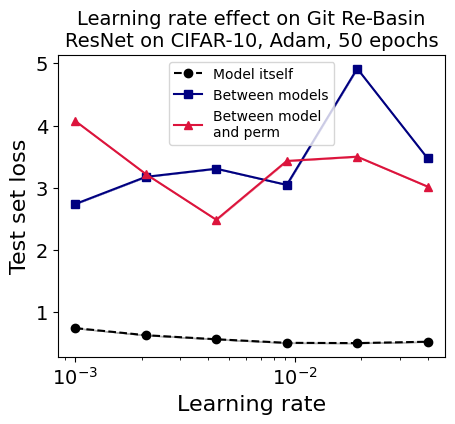

In [57]:
standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])

standard_bumps = np.reshape(standard_bumps,[reps,-1])
permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
model1_loss = np.reshape(model1_loss,[reps,-1])
model2_loss = np.reshape(model2_loss,[reps,-1])

def get_mean_and_error(vals):
  return np.mean(vals,axis=0), np.std(vals,axis=0)

mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)

fig = plt.figure(figsize = (5,4),dpi=100)
fig.patch.set_facecolor('white')

plt.title(f"Learning rate effect on Git Re-Basin\nResNet on CIFAR-10, Adam, {epochs} epochs",fontsize=14)

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",color="black",linestyle="--",label="Model itself")
plt.fill_between(LRs[:len(mean_standard_bumps)],
                 (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                 (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                 color=line.get_color(),
                 alpha=0.3
                 )

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",label="Between models")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())

line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",color="crimson",label="Between model\nand perm")
plt.fill_between(LRs[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())

# from matplotlib.patches import Rectangle
# currentAxis = plt.gca()
# currentAxis.add_patch(Rectangle((LRs[0], 0.0),LRs[3]-LRs[0],3.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)

plt.legend(fontsize=10)
plt.show()